# Introduction

This code generates the supplemental figures for the paper "Exploring controls on the timing of the phytoplankton bloom in western Baffin Bay, Canadian Arctic".

# Directory structure

binder, where is the .yml file for the conda virtual environment.

# Environment

This notebook was run in a conda virtual environment. The following commands will automatically create the environment and launch the Jupyter notebook:

```
cd <my_path>/gud_groups
conda env create -f binder/environment_timing.yml
conda activate timing
cd utils/python/MITgcmutils
python setup.py bdist_egg
cd build
pip install MITgcmutils
cd ../../../..
jupyter notebook
```

Once the environment timing is created, the Jupyter notebook can be launched simply with:

```
cd <my_path>/gud_groups
conda activate timing
jupyter notebook
```

# First, load libraries

Uncomment and run one time the cell below if you have the error:

```ModuleNotFoundError: No module named 'MITgcmutils'```

In [1]:
# import os
# import subprocess
## make sure the current working directory is gud_groups
# wd=%pwd
# os.chdir('utils/python/MITgcmutils')
# subprocess.call(['python', 'setup.py', 'bdist_egg'])
# os.chdir('build')
# subprocess.call(['pip', 'install', 'MITgcmutils'])
# os.chdir(wd)

In [2]:
%matplotlib inline

import cartopy
import cartopy.crs as ccrs
import collections
import datetime
import gsw
import gudinfo
import IPython.display
import math
import matplotlib as mpl
import matplotlib.colors
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import netcdf_tools
import numpy as np
import os.path
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import read_mitgcm
import scipy.interpolate
import scipy.io
import statsmodels.nonparametric.smoothers_lowess
import TaylorDiagram
import vstats_pos

# Parameters of the figures

In [3]:
# dpi='figure' # default dpi
dpi=600
# ext='png'
ext='jpeg'

# Select year

In [4]:
years=range(1,11)
nbyears=len(years)
iyeartempo=nbyears
first_year=np.arange(0,365)
last_year=np.arange(365*(nbyears-1)+0,365*(nbyears-1)+365)
array1d_iT1y_iT=last_year
first_year366=np.arange(0,366) # first year for heatmaps

# Model

## Model: traits

Set indir.

In [5]:
indir_exp0='data/DataS6_output_mitgcm/exp0'

Create RunInfo object.

In [6]:
info=gudinfo.RunInfo(indir_exp0)

Maximum growth rate ($P^C_{max}$, $\mathrm{ d^{-1} }$).

In [7]:
stod=86400 # seconds to day
pcmax=info.f['pcmax'].to_numpy() # s^-1
pcmax=pcmax*stod                 # d^-1

Cell nutrient uptake half saturation constant on nitrate
($K_{NO_3}$, $\mathrm{ mmol\ N\ m^{-3} }$):

$K_{NO_3}=a_{K_{NO_3}}V^{b_{K_{NO_3}}}$

In [8]:
nplk=info.nplk
K=np.empty(nplk)
K[:]=np.nan
a_kn_no3=info.params['a_kn_no3'] # in mmol N m^3
vol=info.f['vol'] # in um^3
b_kn_no3=info.params['b_kn_no3'] # unitless
for iplk in range(0,nplk):
    grp=info.f['grp'][iplk]
    if (0<=grp and grp<8):
        K[iplk]=a_kn_no3[grp]*vol[iplk]**b_kn_no3[grp]

Cell minimum stoichiometric quotas of nitrogen relative to carbon ($Q^{min}_N$, $\mathrm{ mmol\ N\ (mmol\ C)^{-1} }$)

$Q^{min}_{N}=a_{Q^{min}_{N}}V^{b_{Q^{min}_{N}}}$

In [9]:
nplk=info.nplk
Q_min=np.empty(nplk)
Q_min[:]=np.nan
a_qmin_n=info.params['a_qmin_n'] # in mmol N (mmol C)^-1
vol=info.f['vol'] # in um^3
b_qmin_n=info.params['b_qmin_n'] # unitless
for iplk in range(0,nplk):
    grp=info.f['grp'][iplk]
    if (0<=grp and grp<8):
        Q_min[iplk]=a_qmin_n[grp]*vol[iplk]**b_qmin_n[grp]

Cell  nutrient uptake rate of nitrate relative to carbon ($V^{max}_{NO_3}$, $\mathrm{ mmol\ N\ (mmol\ C)^{-1}\ d^{-1} }$)

$V^{max}_{NO_3}=a_{V^{max}_{NO_3}}V^{b_{V^{max}_{NO_3}}}$

In [10]:
nplk=info.nplk
V_max_d=np.empty(nplk)
V_max_d[:]=np.nan
a_vmax_no3_s=info.params['a_vmax_no3'] # in mmol N (mmol C)^-1 s^-1
a_vmax_no3_d=a_vmax_no3_s*86400        # in mmol N (mmol C)^-1 d^-1
vol=info.f['vol'] # in um^3
b_vmax_no3=info.params['b_vmax_no3'] # unitless
for iplk in range(0,nplk):
    grp=info.f['grp'][iplk]
    if (0<=grp and grp<8):
        V_max_d[iplk]=a_vmax_no3_d[grp]*vol[iplk]**b_vmax_no3[grp]

## Plot: traits

In [11]:
type_id=np.arange(1,52)

pos_Prochlorococcus=np.arange( 0, 1)
pos_Synechococcus  =np.arange( 1, 2)
pos_smalleuk       =np.arange( 2, 4)
pos_cocco          =np.arange( 4, 9)
pos_diazo          =np.arange( 9,13)
pos_Trichodesmium  =np.arange(13,14)
pos_diatoms        =np.arange(14,23)
pos_mixodino       =np.arange(23,33)
pos_zoo            =np.arange(33,49)

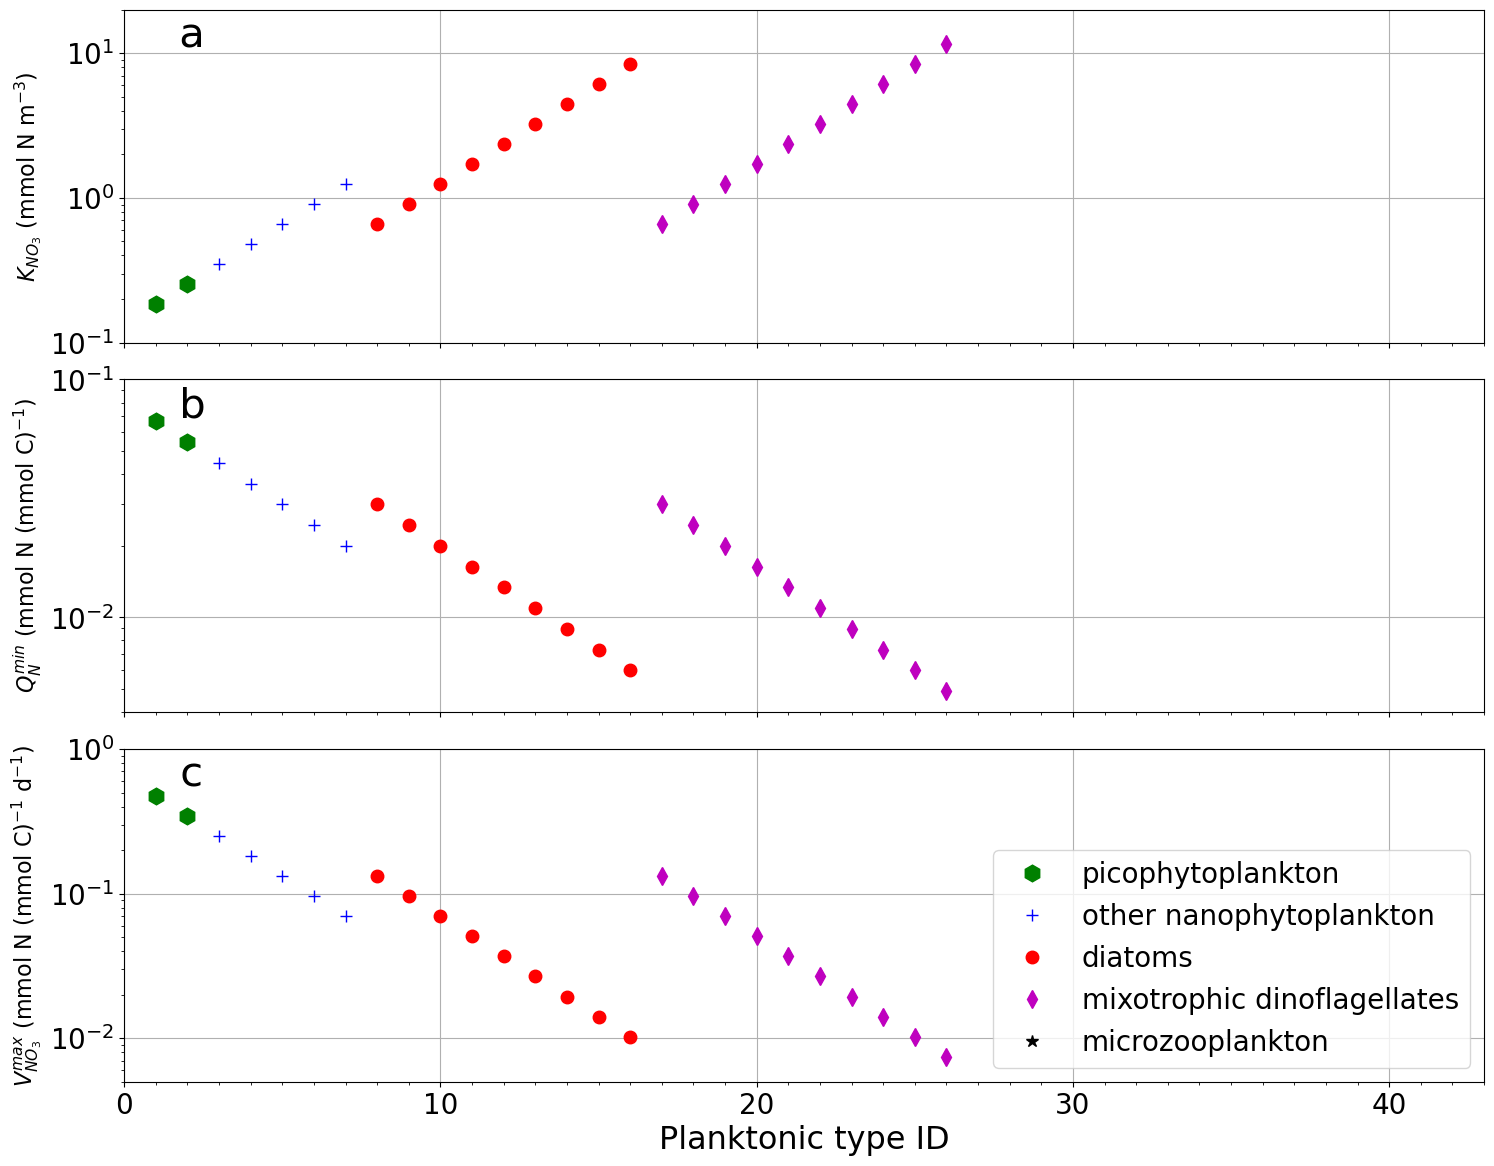

In [12]:
def make_plots(axs):
    box=dict(pad=5,alpha=0)
    
    # --- CELL NUTRIENT UPTAKE HALF SATURATION CONSTANT ON NITRATE
    ax=axs[0]
    h3=ax.plot(type_id[pos_smalleuk]-2,  K[pos_smalleuk],'gh',
               markersize=12)
    h4=ax.plot(type_id[pos_cocco]-2,     K[pos_cocco],   'b+')
    h7=ax.plot(type_id[pos_diatoms]-2-5, K[pos_diatoms], 'ro')
    h8=ax.plot(type_id[pos_mixodino]-2-5,K[pos_mixodino],'md')
    h9=ax.plot(type_id[pos_zoo]-2-5,     K[pos_zoo],     'k*')
    ax.set_xticklabels([])
    ax.xaxis.set_major_locator(mticker.MultipleLocator(10))
    ax.xaxis.set_minor_locator(mticker.MultipleLocator( 1))
    ax.set_xlim([0,43])
    ax.set_ylabel('$K_{NO_3}\ (\mathrm{ mmol\ N\ m^{-3} })$')
    ax.set_yscale('log')
    ax.set_ylim([0.1,20])
    ax.grid()
    plt.text(0.05,0.92,' a ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    
    # --- CELL MINIMUM STOICHIOMETRIC QUOTAS OF NITROGEN RELATIVE TO CARBON
    ax=axs[1]
    h3=ax.plot(type_id[pos_smalleuk]-2,  Q_min[pos_smalleuk],'gh',
               markersize=12)
    h4=ax.plot(type_id[pos_cocco]-2,     Q_min[pos_cocco],   'b+')
    h7=ax.plot(type_id[pos_diatoms]-2-5, Q_min[pos_diatoms], 'ro')
    h8=ax.plot(type_id[pos_mixodino]-2-5,Q_min[pos_mixodino],'md')
    h9=ax.plot(type_id[pos_zoo]-2-5,     Q_min[pos_zoo],     'k*')
    ax.set_xticklabels([])
    ax.xaxis.set_major_locator(mticker.MultipleLocator(10))
    ax.xaxis.set_minor_locator(mticker.MultipleLocator( 1))
    ax.set_xlim([0,43])
    ax.set_ylabel('$Q^{min}_N\ (\mathrm{ mmol\ N\ (mmol\ C)^{-1} })$')
    ax.set_yscale('log')
    ax.set_ylim([0.004,0.1])
    ax.grid()
    plt.text(0.05,0.92,' b ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    
    # --- CELL NUTRIENT UPTAKE RATE OF NITRATE RELATIVE TO CARBON
    ax=axs[2]
    h3=ax.plot(type_id[pos_smalleuk]-2,  V_max_d[pos_smalleuk],'gh',
               markersize=12,label='picophytoplankton')
    h4=ax.plot(type_id[pos_cocco]-2,     V_max_d[pos_cocco],   'b+',
              label='other nanophytoplankton')
    h7=ax.plot(type_id[pos_diatoms]-2-5, V_max_d[pos_diatoms], 'ro',
              label='diatoms')
    h8=ax.plot(type_id[pos_mixodino]-2-5,V_max_d[pos_mixodino],'md',
              label='mixotrophic dinoflagellates')
    h9=ax.plot(type_id[pos_zoo]-2-5,     V_max_d[pos_zoo],     'k*',
              label='microzooplankton')
    ax.set_xlabel('Planktonic type ID',fontsize=23)
    ax.xaxis.set_major_locator(mticker.MultipleLocator(10))
    ax.xaxis.set_minor_locator(mticker.MultipleLocator( 1))
    ax.set_xlim([0,43])
    ax.set_ylabel('$V^{max}_{NO_3}\ (\mathrm{ mmol\ N\ (mmol\ C)^{-1}\ d^{-1} })$')
    ax.set_yscale('log')
    ax.set_ylim([0.005,1])
    ax.grid()
    ax.legend(loc='lower right')
    plt.text(0.05,0.92,' c ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)

    # --- POSITION
    axs[0].set_position( [0.10,0.69  ,0.85,0.27])
    axs[1].set_position( [0.10,0.39  ,0.85,0.27])
    axs[2].set_position( [0.10,0.09  ,0.85,0.27])

with plt.style.context('mplstyles/traits.mplstyle'):    
    # Plot
    fig,axs=plt.subplots(3,1,figsize=(16, 12.32))
    make_plots(axs)
    fig.align_ylabels(axs[:])

    # --- SAVE
    outfile='figures_timing_sup_progress/sup_traits.'+ext
    plt.savefig(outfile,dpi=dpi)

Supplemental Figure $<$sup_traits$>$.
Parameters controlling the half saturation for growth on nitrate
($k_{NO_3}$), $\mathrm{ mmol\ N\ m^{-3} }$, Fig. $<$traits$>$c)
for each numerical type (each numerical species).
(a) Cell nutrient uptake half saturation constant on nitrate
($K_{NO_3}$, $\mathrm{ mmol\ N\ m^{-3} }$).
(b) Cell minimum stoichiometric quotas of nitrogen relative to carbon ($Q_N^{min}$, $\mathrm{ mmol\ N\ (mmol\ C)^{-1} }$). (c) Cell nutrient uptake rate of nitrate relative to carbon
($V_{NO_3}^{max}$, $\mathrm{ mmol\ N\ (mmol\ C)^{-1}\ d^{-1} }$).


# Grid

drF is the r cell face separation, meaning the thickness of each depth layer (in m).

It corresponds to delR on https://mitgcm.readthedocs.io/en/latest/getting_started/getting_started.html#grid

In [13]:
gridfile='data/DataS6_output_mitgcm/exp0/grid.t001.nc';
drF=netcdf_tools.read_netcdf(gridfile,'drF')

RC is the r coordiante of cell center (in m).
We switch sign to have positive depths.

In [14]:
RC=-netcdf_tools.read_netcdf(gridfile,'RC')

RF is the r coordinate of cell interface (in m). We switch sign to have positive depths.

In [15]:
RF=-netcdf_tools.read_netcdf(gridfile,'RF')

# Observations

## Observations: sea ice concentration

The values of observed sea ice concentrations were boolean values of 0
and 1 because sea ice melted suddenly in only one day.
Here, these values were retrieved from the file of the forcing fields
of sea ice concentration.
We made sure these values corresponded to the expected values.

In [16]:
infile_sic=\
'data/DataS3_observations_Qikiqtarjuaq/siarea.qik.2016.365.32bits.bin'
array1d_iT_sic=np.fromfile(infile_sic,dtype='>f')

Sea ice break-up was on 18 July 2016, doy (0-based)=199.

In [17]:
obs_breakup=next(i for i,v in list(enumerate(array1d_iT_sic)) if v==0)

assert obs_breakup==199,\
'the day of year (0-based) of break-up from the file %s (obs_breakup=%r)'\
' is different from the day of year of break-up'\
' from Oziel et al., 2019 in Elem. Sci. Anth. (July 18=199).'\
% (infile_sic,obs_breakup)

## Observations: snow and ice thickness

The file Ice thickness from https://www.seanoe.org/data/00487/59892/ contains $in\ situ$ snow and ice thickness at the Green Edge sea ice camps 2015 and 2016 ($67.48^\circ N$, $-63.79^\circ E$). Variable 'sample_thickness_cm_average' is the snow or ice thickness ($cm$).

### Observations: snow and ice thickness: load dataset

In [18]:
def load_thickness():
    fname='data/DataS3_observations_Qikiqtarjuaq/66407.csv'
    df = (
        pd.read_csv(
            fname,
            dtype={
                'mission': 'string',
                'date': str,
                'date_time': str,
                'latitude': np.float32,
                'longitude': np.float32,
                'sample_type': 'category',
                'sample_thickness_cm_average': np.float32,
                'sample_thickness_cm_sd': np.float32,
                'pi': 'category'
            },
            parse_dates=['date','date_time']
        )
    )
    df['doy']=df['date'].apply(lambda x:x.timetuple().tm_yday)
    df['sample_thickness_m_average']=df['sample_thickness_cm_average'] \
    .apply(lambda x:x/100)
    return df

In [19]:
thickness_df=load_thickness()

### Observations: snow and ice thickness: select

We select the observations of snow thickness at the ice camp 2016.

In [20]:
snow_thickness_df=thickness_df[(thickness_df.mission=='ice_camp_2016') \
                               & (thickness_df.sample_type=='snow')]
# snow_thickness_df[['date','sample_thickness_m_average']]

The start of the period without observed snow cover was defined as the
start of the melt pond period.
It was on 15 June 2016 (Oziel et al., 2019 in *Elem. Sci. Anth.*).

In [21]:
obs_nosnow=166 # 0-based

We select the observations of ice thickness at the ice camp 2016.

In [22]:
ice_thickness_df=thickness_df[(thickness_df.mission=='ice_camp_2016') \
                              & (thickness_df.sample_type=='ice')]

## Observations: nutrients

The file Nutrients from https://www.seanoe.org/data/00487/59892/ contains $in\ situ$ nutrients at the Qikiqtarjuaq sea ice camps 2015 and 2016 ($67.48^\circ N$, $-63.79^\circ E$). Variables 'no3_um_l', 'po4_um_l', and 'sioh4_um_l' are the nitrate, phosphate, and silicic acid concentrations, respectively ($\mathrm{ \mu }$M).

### Observations: nutrients: load dataset

In [23]:
def load_nutrients():
    fname='data/DataS3_observations_Qikiqtarjuaq/66412.csv'
    df = (
        pd.read_csv(
            fname,
            dtype={
                'mission': 'string',
                'date': str,
                'date_time': str,
                'latitude': np.float32,
                'longitude': np.float32,
                'sample_type': 'category',
                'sample_source': 'category',
                'snow_thickness': 'category',
                'code_operation': 'category',
                'station': 'category',
                'station_type': 'category',
                'cast': np.float32,
                'bottle': np.float32,
                'bottom_depth_m': np.float32,
                'target_depth_m': 'string',
                'depth_m': np.float32,
                'filter_type': 'category',
                'quality_flag': 'category',
                'dilution_factor': np.float32,
                'no3_um_l': np.float32,
                'no2_um_l': np.float32,
                'no2_and_no3': np.float32,
                'po4_um_l': np.float32,
                'sioh4_um_l': np.float32,
                'n_ice_samples_ice_camp_2016': np.float32,
                'method': 'category',
                'pi': 'category'
            },
            parse_dates=['date','date_time']
        )
        .rename(
            columns=dict(
                depth_m='depth',
                no3_um_l='no3',
                po4_um_l='po4',
                sioh4_um_l='sioh4'
            )
        )
    )
    df['doy']=df['date'].apply(lambda x:x.timetuple().tm_yday)
    return df

In [24]:
nutrients_df=load_nutrients()

### Observations: nutrients: select

We select the observations of nitrate at the ice camp 2016 in the water column made with a GFF filter.

In [25]:
nutrients_df=nutrients_df[(nutrients_df.mission=='ice_camp_2016') \
              & (nutrients_df.sample_type=='water') \
             & (nutrients_df.filter_type=='gff')]

Find duplicates.

In [26]:
g=nutrients_df.groupby('doy')['depth'].value_counts()
g.where(g>1).dropna()

Series([], Name: count, dtype: float64)

No duplicates.

## Observations Qikiqtarjuaq 2016: chlorophyll *a*

The file Pigments, nutrients, Chlorophyll a and Phaeopigments (concentration) from https://www.seanoe.org/data/00487/59892/ contains $in\ situ$ chlorophyll *a* at the Qikiqtarjuaq sea ice camps 2015 and 2016 ($67.48^\circ N$, $-63.79^\circ E$). Variables 'conc_mg_m3' is the chlorophyll *a* concentration measured by HPLC (mg Chl $\mathrm{ m^{-3} }$).

### Observations Qikiqtarjuaq 2016: chlorophyll *a*: load dataset

In [27]:
def load_pigment():
    fname='data/DataS3_observations_Qikiqtarjuaq/66417.csv'
    df = (
        pd.read_csv(
            fname,
            dtype={
                'mission': 'string',
                'date': str,
                'date_time': str,
                'latitude': np.float32,
                'longitude': np.float32,
                'sample_id': 'string',
                'sample_code': 'string',
                'sample_type': 'category',
                'sample_source': 'category',
                'snow_thickness': 'category',
                'leg': 'category',
                'code_operation': 'category',
                'station': 'category',
                'station_type': 'category',
                'cast': np.float32,
                'bottle': np.float32,
                'target_depth_m': 'string',
                'depth_m': np.float32,
                'pigment': 'category',
                'conc_mg_m2': np.float32,
                'conc_ug_l': np.float32,
                'conc_mg_m3': np.float32,
                'filtered_vol_l': np.float32,
                'vol_after_melt_l': np.float32,
                'ice_added_vol_of_water': np.float32,
                'ice_total_vol_water': np.float32,
                'ice_calculated_vol_ice': np.float32,
                'dilution_factor': np.float32,
                'quality_control_peaks': 'category',
                'nb_core': np.float32,
                'nb_core_9cm_dia': np.float32,
                'core_area_9cm_dia': np.float32,
                'nb_core_14cm_dia': np.float32,
                'core_area_14cm_dia': np.float32,
                'area_m2': np.float32,
                'description_of_sample': 'category',
                'n': np.float32,
                'observations': 'category',
                'method': 'category',
                'pi': 'category'
            },
            parse_dates=['date','date_time']
        )
        .rename(
            columns=dict(
                depth_m='depth',
                conc_ug_l='chlfluo',
                conc_mg_m3='chlHPLC'
            )
        )
    )
    df['doy']=df['date'].apply(lambda x:x.timetuple().tm_yday)
    return df

In [28]:
chlHPLC_df=load_pigment()

### Observations Qikiqtarjuaq 2016: chlorophyll *a*: select

We select the observations of chlorophyll a concentrations at the ice camp 2016 measured by HPLC.

In [29]:
chlHPLC_df=chlHPLC_df[(chlHPLC_df.mission=='ice_camp_2016') \
              & (chlHPLC_df.sample_type=='water') \
             & (chlHPLC_df.pigment=='Total Chlorophyll a') \
             & (chlHPLC_df.method=='HPLC')]

remove negative chlorophyll a

In [30]:
chlHPLC_df['chlHPLC'][ chlHPLC_df['chlHPLC']<0 ]

Series([], Name: chlHPLC, dtype: float32)

find duplicates

In [31]:
g=chlHPLC_df.groupby('doy')['depth'].value_counts()
g.where(g>1).dropna()

doy  depth
146  1.5      2.0
     10.0     2.0
Name: count, dtype: float64

inspect duplicates for doy=146

In [32]:
chlHPLC_oneday_df=chlHPLC_df[['depth','chlHPLC','doy']][(chlHPLC_df.doy==146) | (chlHPLC_df.doy==148)]
chlHPLC_oneday_df

depth  chlHPLC  doy
20357    0.5   0.1056  146
20358    1.5   0.0899  146
20359    5.0   0.0906  146
20360   10.0   0.0905  146
20361   20.0   0.1011  146
20362   40.0   0.0633  146
20363    0.5   0.0971  148
20364    1.5   0.1483  146
20365    5.0   0.1086  148
20366   10.0   0.0890  146
20367   20.0   0.0735  148
20368   40.0   0.0399  148

By human judgement, I replace the doy of rows 20364 and 20366 with 148.

In [33]:
chlHPLC_df.loc[[20364,20366],'doy']=148

In [34]:
chlHPLC_oneday_df=chlHPLC_df[['depth','chlHPLC','doy']][(chlHPLC_df.doy==146) | (chlHPLC_df.doy==148)]
chlHPLC_oneday_df

depth  chlHPLC  doy
20357    0.5   0.1056  146
20358    1.5   0.0899  146
20359    5.0   0.0906  146
20360   10.0   0.0905  146
20361   20.0   0.1011  146
20362   40.0   0.0633  146
20363    0.5   0.0971  148
20364    1.5   0.1483  148
20365    5.0   0.1086  148
20366   10.0   0.0890  148
20367   20.0   0.0735  148
20368   40.0   0.0399  148

Identify days of year for which the number of observations is less than or equal to 2. There are not measurements at enough depths to be able to calculate a meaningful vertical integration.

In [35]:
g=chlHPLC_df.groupby('doy')['doy'].value_counts()
g.where(g<=2).dropna()

doy
120    2.0
Name: count, dtype: float64

In [36]:
chlHPLC_oneday_df=chlHPLC_df[['depth','chlHPLC','doy']][(chlHPLC_df.doy==120)]
chlHPLC_oneday_df

depth  chlHPLC  doy
20299    1.5   0.0355  120
20300    5.0   0.0253  120

By human judgement, I drop these observations.

In [37]:
chlHPLC_df=chlHPLC_df.drop(chlHPLC_df[(chlHPLC_df.doy==120)].index)

### Observations Qikiqtarjuaq 2016: chlorophyll *a*: vertically integrated chlorophyll *a* (0-100m)

in $\mathrm{ mg\ Chla\ m^{-2} }$

In [38]:
#doy: 123
depths_case1 =np.array([      1.5, 5,   10,   20,    40])
weights_case1=np.array([      3.25,4.25, 7.5, 15,    70])
#doys: 125,127
depths_case2 =np.array([0.5, 1.5, 5,          20,    40])
weights_case2=np.array([1,   2.25,9.25,       17.5,  70])
#doys:130,132,134,137,139,144,146,148,151,153,155,158,160,162,165,167,169,172,176
depths_case3 =np.array([0.5,1.5,  5,   10,   20,    40])
weights_case3=np.array([1,  2.25, 4.25, 7.5, 15,    70])
#doy: 141
depths_case4 =np.array([0.5,1.5,  5,   10,           40])
weights_case4=np.array([1,  2.25, 4.25,17.5,         75])
#doy: 174
depths_case5 =np.array([0.5,1.5,        10,   20,    40])
weights_case5=np.array([1,  4.75,        9.25,15,    70])
#doys: 179,181,183,186,188,190
depths_case6 =np.array([0.5,1.5,        10,   20,30,    60])
weights_case6=np.array([1,  4.75,        9.25,10,20,    55])
#doys: 193,195,200
depths_case7 =np.array([     1.5,        10,   20,30,    60,  75])
weights_case7=np.array([     5.75,        9.25,10,20,    22.5,32.5])
#doys: 197,204
depths_case8 =np.array([     1.5,        10,   20,30,  45,60])
weights_case8=np.array([     5.75,        9.25,10,12.5,15,47.5])

In [39]:
nT=365
array1d_iT_obsvintchlHPLC=np.full(nT,np.NaN)
for iT in np.arange(0,nT):
    obsvintchlHPLC=np.NaN
    chlHPLC=[]
    doy=iT+1
    chlHPLC_oneday_df=chlHPLC_df[['depth','chlHPLC']][(chlHPLC_df.doy==doy)]
    depths=chlHPLC_oneday_df['depth']
    if set(depths_case1).issubset(set(depths)):
        for depth in depths_case1:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case1)
    elif set(depths_case2).issubset(set(depths)):
        for depth in depths_case2:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case2)
    elif set(depths_case3).issubset(set(depths)):
        for depth in depths_case3:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case3)
    elif set(depths_case4).issubset(set(depths)):
        for depth in depths_case4:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case4)
    elif set(depths_case5).issubset(set(depths)):
        for depth in depths_case5:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case5)
    elif set(depths_case6).issubset(set(depths)):
        for depth in depths_case6:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case6)
    elif set(depths_case7).issubset(set(depths)):
        for depth in depths_case7:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case7)
    elif set(depths_case8).issubset(set(depths)):
        for depth in depths_case8:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsvintchlHPLC=np.dot(chlHPLC,weights_case8)
    array1d_iT_obsvintchlHPLC[iT]=obsvintchlHPLC

### Observations Qikiqtarjuaq 2016: chlorophyll $a$: mean chlorophyll a (0-40m)

in $mg\ Chla\ m^{-3}$

In [40]:
#doy: 123
depths_case1 =np.array([       1.5,  5,    10,    20,     40])
weights_case1=np.array([       3.25, 4.25,  7.5,  15,     10])
#doys: 125,127
depths_case2 =np.array([ 0.5,  1.5,  5,           20,     40])
weights_case2=np.array([ 1,    2.25, 9.25,         17.5,  10])
#doys:130,132,134,137,139,144,146,148,151,153,155,158,160,162,165,167,169,172,176
depths_case3 =np.array([ 0.5, 1.5,   5,    10,    20,     40])
weights_case3=np.array([ 1,   2.25,  4.25,  7.5,  15,     10])
#doy: 141
depths_case4 =np.array([ 0.5, 1.5,   5,    10,            40])
weights_case4=np.array([ 1,   2.25,  4.25, 17.5,          15])
#doy: 174
depths_case5 =np.array([ 0.5, 1.5,         10,    20,     40])
weights_case5=np.array([ 1,   4.75,         9.25, 15,     10])
#doys: 179,181,183,186,188,190
depths_case6 =np.array([ 0.5, 1.5,         10,    20, 30,     60])
weights_case6=np.array([ 1,   4.75,         9.25, 10, 15,      0])
#doys: 193,195,200
depths_case7 =np.array([      1.5,         10,    20, 30,     60,   75])
weights_case7=np.array([      5.75,         9.25, 10, 15,      0,    0])
#doys: 197,204
depths_case8 =np.array([      1.5,         10,    20, 30,   45, 60])
weights_case8=np.array([      5.75,         9.25, 10, 12.5, 2.5,  0])

In [41]:
nT=365
array1d_iT_obsmeanchlHPLC=np.full(nT,np.NaN)
for iT in np.arange(0,nT):
    obsmeanchlHPLC=np.NaN
    chlHPLC=[]
    doy=iT+1
    chlHPLC_oneday_df=chlHPLC_df[['depth','chlHPLC']][(chlHPLC_df.doy==doy)]
    depths=chlHPLC_oneday_df['depth']
    if set(depths_case1).issubset(set(depths)):
        for depth in depths_case1:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsmeanchlHPLC=np.average(np.array(chlHPLC),weights=weights_case1)
    elif set(depths_case2).issubset(set(depths)):
        for depth in depths_case2:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsmeanchlHPLC=np.average(np.array(chlHPLC),weights=weights_case2)
    elif set(depths_case3).issubset(set(depths)):
        for depth in depths_case3:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsmeanchlHPLC=np.average(np.array(chlHPLC),weights=weights_case3)
    elif set(depths_case4).issubset(set(depths)):
        for depth in depths_case4:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsmeanchlHPLC=np.average(np.array(chlHPLC),weights=weights_case4)
    elif set(depths_case5).issubset(set(depths)):
        for depth in depths_case5:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsmeanchlHPLC=np.average(np.array(chlHPLC),weights=weights_case5)
    elif set(depths_case6).issubset(set(depths)):
        for depth in depths_case6:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsmeanchlHPLC=np.average(np.array(chlHPLC),weights=weights_case6)
    elif set(depths_case7).issubset(set(depths)):
        for depth in depths_case7:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsmeanchlHPLC=np.average(np.array(chlHPLC),weights=weights_case7)
    elif set(depths_case8).issubset(set(depths)):
        for depth in depths_case8:
            chlHPLCtempo \
            =chlHPLC_oneday_df['chlHPLC'][(chlHPLC_oneday_df.depth==depth)]
            assert chlHPLCtempo.size==1
            chlHPLCtempo=chlHPLCtempo.iat[0]
            chlHPLC.append(chlHPLCtempo)
        obsmeanchlHPLC=np.average(np.array(chlHPLC),weights=weights_case8)
    array1d_iT_obsmeanchlHPLC[iT]=obsmeanchlHPLC

### Observations Qikiqtarjuaq 2016: chlorophyll $a$: timing

#### Observations Qikiqtarjuaq 2016: chlorophyll $a$: timing: date of bloom initiation

The bloom initiation was identified when the accumulation rates ($d^{-1}$) were positive for one week (Boss and Behrenfeld, 2010):

accumulation_rate=$\frac{chl_{iT}-chl_{iT-1}}{chl_{iT-1}}$

$In\ situ$ data was smoothed with LOWESS (locally weighted scatterplot smoothing) and interpolated before calculating the accumulation rates.

For $in\ situ$ data, by applying the definition of Boss & Behrenfeld (2010) of 7 days with a positive accumulation rate ($d^{-1}$), the date of bloom initiation would have been May 9.
This date was questionable because light was low on May 9, there was no continuous decrease of nutrients and there was no continuous increase of Chl $a$.
Also, changing the number of days with a positive accumulation rate from 7 days to 8 days changed the date of bloom initiation from May 9 to May 27 indicating a high sensitivity on the number of days with a positive accumulation rate.
This was an indication that human judgment was needed to identify the date of the bloom initiation.
We supposed that the small peak observable on May 9 may not be due to local phytoplankton but instead to the flushing of sea ice algae or to the horizontal advection of phytoplankton.
The algorithm was applied after May 9 and found a date of bloom initiation on May 27.
Note that Oziel et al. (2019) in $Elem.\ Sci\ Anth.$ also found a date of bloom initiation at the end of May from the same observations.

In [42]:
x=first_year
y=array1d_iT_obsvintchlHPLC
df=pd.DataFrame({'Day of year':x,'Observed Chl a vert. integrated (0-100m)':y})

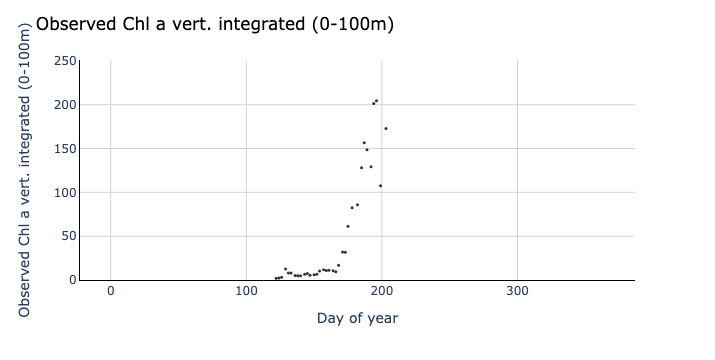

In [43]:
# Create a scatter plot
fig = px.scatter(df, x=df['Day of year'], y=df['Observed Chl a vert. integrated (0-100m)'],
                 opacity=0.8, color_discrete_sequence=['black'])

# Change chart background color
fig.update_layout(dict(plot_bgcolor = 'white'))

# Update axes lines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black',
                range=[0,251])

# Set figure title
fig.update_layout(title=dict(text="Observed Chl a vert. integrated (0-100m)", 
                             font=dict(color='black')))

# Update marker size
fig.update_traces(marker=dict(size=3))

fig.show()

Figure. Scatterplot of day of year and observed Chl a vert. integrated (0-100m).

In [44]:
y_hat=statsmodels.nonparametric.smoothers_lowess.lowess(y,x,frac=1/4)

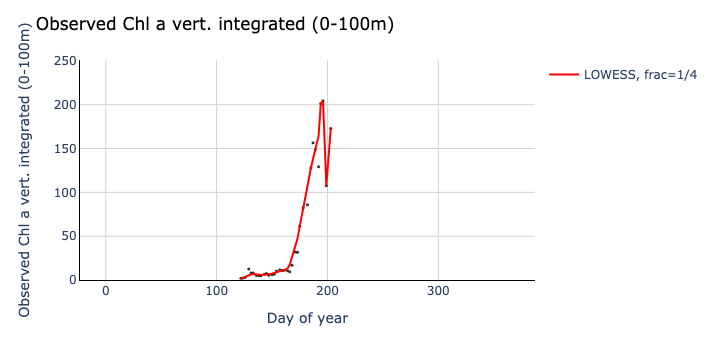

In [45]:
# Create a scatter plot
fig = px.scatter(df, x=df['Day of year'], y=df['Observed Chl a vert. integrated (0-100m)'],
                 opacity=0.8, color_discrete_sequence=['black'])

# Add the prediction line
fig.add_traces(go.Scatter(x=y_hat[:,0], y=y_hat[:,1], name='LOWESS, frac=1/4', line=dict(color='red')))

# Change chart background color
fig.update_layout(dict(plot_bgcolor = 'white'))

# Update axes lines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black',
                range=[0,251])

# Set figure title
fig.update_layout(title=dict(text="Observed Chl a vert. integrated (0-100m)", 
                             font=dict(color='black')))

# Update marker size
fig.update_traces(marker=dict(size=3))

fig.show()

In [46]:
# ------- Define interploation functions -------
# Linear - draws a line between the two nearest points and calculates y value based on the slope of that line
f_linear = scipy.interpolate.interp1d(y_hat[:,0],
                                      y=y_hat[:,1],
                                      bounds_error=False) 

# Create a new set of points with x values
indices_not_nan=np.argwhere(~np.isnan(y)).flatten()
start=indices_not_nan[0]
end  =indices_not_nan[-1]
xnew=np.empty(end-start+1)
for iT in range(start,end+1):
    xnew[iT-start]=iT
    
# Find y values based on the interpolation method
array1d_iT_obsvintchlHPLClowess=f_linear(xnew)

start_edge=np.empty(start)
start_edge[:]=np.NaN
end_edge=np.empty(365-1-end)
end_edge[:]=np.NaN
array1d_iT_obsvintchlHPLClowess=np.concatenate((start_edge,
                                                array1d_iT_obsvintchlHPLClowess,
                                                end_edge))

In [47]:
x=first_year
y=array1d_iT_obsvintchlHPLClowess
df=pd.DataFrame({'Day of year':x,'Smoothed and interpolated observed Chl a vert. integrated (0-100m)':y})

In [48]:
indices_not_nan=np.argwhere(~np.isnan(array1d_iT_obsvintchlHPLClowess)).flatten()
start=indices_not_nan[0]
end  =indices_not_nan[-1]
# no NaN between first and last smoothed observed value
assert np.array_equal(indices_not_nan,np.arange(start,end+1)), (
    'There is at least one NaN in array1d_iT_obsvintchlHPLCsmooth before '
    'its first and last valid values.')
array1d_iT_r2016=np.empty(365)
array1d_iT_r2016[:]=np.NaN
for iT in range(start+1,end):
    chliT=array1d_iT_obsvintchlHPLClowess[iT]
    chljT=array1d_iT_obsvintchlHPLClowess[iT-1]
    acc=(chliT-chljT)/chljT
    array1d_iT_r2016[iT]=acc

In [49]:
x=first_year
y=array1d_iT_r2016
df=pd.DataFrame({'Day of year':x,'Accumulation rates':y})

In [50]:
found=False
iT=136 # starting after the small peak of 129 (May 9) + 7
while not found and iT<=364:
    array1d_iT_accweekbefore=array1d_iT_r2016[np.arange(iT-6,iT+1)]
    if(np.all(~np.isnan(array1d_iT_accweekbefore)) \
       and \
       np.all(array1d_iT_accweekbefore>0)):
        found=True
    else:
        iT=iT+1
tI=iT
year=2016 # any leap year
# transform day of year into date
# https://stackoverflow.com/questions/2427555/python-question-year-and-day-of-year-to-date
# see answer of Ignacio Vazquez-Abrams
tIs=datetime.datetime(year,1,1) + datetime.timedelta(tI)

Day of year

In [51]:
tI=tI+1
tI

148

In [52]:
tIs.strftime("%B %d")

'May 27'

In [53]:
cI=array1d_iT_obsvintchlHPLClowess[tI-1]

(in $mg\ Chl\ m^{-2}$)

In [54]:
cI

6.4125088304456135

#### Observations Qikiqtarjuaq 2016: chlorophyll $a$: timing: date of bloom peak

The date of the bloom peak was the date of the maximum (vertically integrated) chlorophyll $a$.

In [55]:
tP=np.nanargmax(array1d_iT_obsvintchlHPLC)
tP=tP.item()
year=2016
# transform day of year into date
# https://stackoverflow.com/questions/2427555/python-question-year-and-day-of-year-to-date
# see answer of Ignacio Vazquez-Abrams
tPs=datetime.datetime(year,1,1) + datetime.timedelta(tP)

(in $mg\ Chl\ m^{-2}$)

In [56]:
cP=np.nanmax(array1d_iT_obsvintchlHPLC)

In [57]:
cP

204.44257855415344

Day of year

In [58]:
tP=tP+1
tP

197

In [59]:
tPs.strftime("%B %d")

'July 15'

# NEMO-LIM3

## NEMO-LIM3: simulated sea ice freeze-up

In [60]:
infile_sicFile='data/DataS4_output_nemo_lim3/siarea.nemo.2016.365.32bits.bin'
array1d_iT_forsic=np.fromfile(infile_sicFile,dtype='>f4')

The simulated sea ice freeze-up was on 24 November, doy (0-based)=328.

In [61]:
sim_freezeup\
=next(i for i,v in reversed(list(enumerate(array1d_iT_forsic))) if v < 0.50)

In [62]:
sim_freezeup

328

# Plot: Observations Qikiqtarjuaq 2016: chlorophyll *a*

Plot *in situ* phytoplankton accumulation rates ($\mathrm{ d^{-1} }$).

/var/folders/vq/5y09539n705gpb79d6ysx09r0000gr/T/ipykernel_19767/4245389142.py:70: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.



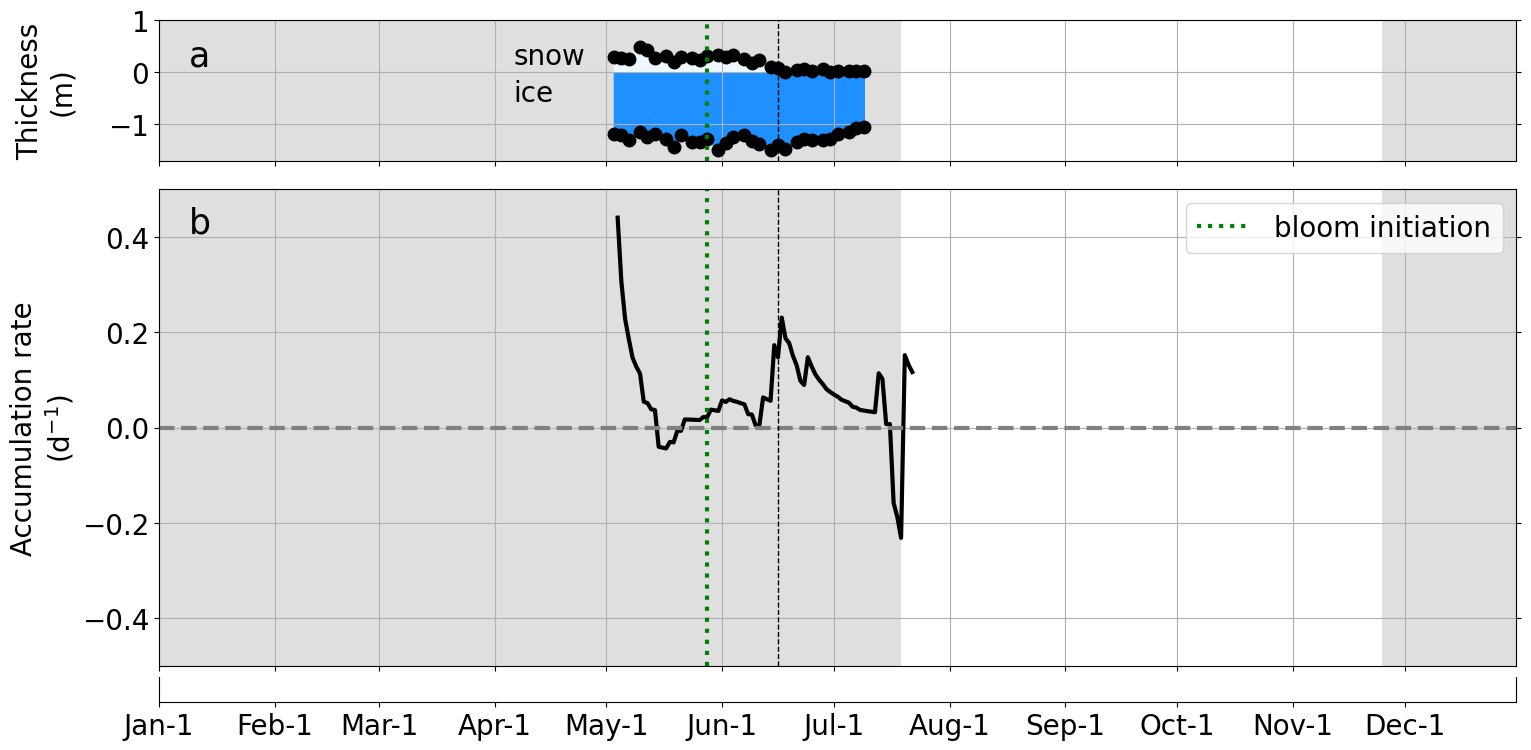

In [63]:
def make_plots(axs):
    box=dict(pad=5,alpha=0)
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')
    xlims=(first_year[0],first_year[-1])
    xmin=xlims[0]
    xmax=xlims[1]

    # --- SNOW AND ICE THICKNESS
    ax=axs[0]
    ymin=-1.7
    ymax=1.0
    xsnow=(snow_thickness_df['doy']-1).to_numpy()
    ysnow=snow_thickness_df['sample_thickness_m_average'].to_numpy()
    h1=ax.plot(xsnow,ysnow,
               'o',color='black',label='obs')
    xsnow_to_fill=np.arange(xsnow[0],xsnow[-1]+1)
    ysnow_to_fill=np.interp(xsnow_to_fill,xsnow,ysnow)
    h2=ax.fill_between(xsnow_to_fill,ysnow_to_fill,
                       linestyle='-',color='aliceblue')
    ax.text(95,0.3,'snow',
            horizontalalignment = 'left',verticalalignment = 'center')
    xice=(ice_thickness_df['doy']-1).to_numpy()
    yice=-ice_thickness_df['sample_thickness_m_average'].to_numpy()
    h3=ax.plot(xice,yice,'o',color='black')
    xice_to_fill=np.arange(xice[0],xice[-1]+1)
    yice_to_fill=np.interp(xice_to_fill,xice,yice)
    h4=ax.fill_between(xice_to_fill,yice_to_fill,
                       linestyle='-',color='dodgerblue')
    ax.text(95,-0.40,'ice',
            horizontalalignment = 'left',verticalalignment = 'center')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylim(ymin,ymax)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('Thickness\n(m)',bbox=box)
    ax.grid()
#     ax.legend(loc='upper right')
    plt.text(0.03,0.75,' a ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    ax.axvline(tI-1,color='green',linestyle=':',label='bloom initiation')
    ax.axvline(obs_nosnow,color='black',linewidth=1,linestyle='--')

    # --- ACCUMULATION RATE
    ax=axs[1]
    ymin=-0.5
    ymax= 0.5
    h1=ax.plot(first_year,array1d_iT_r2016,'-',color='black',lw=3)
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylim(ymin,ymax)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('Accumulation rate\n($\mathrm{ d^{-1} }$)')
    ax.grid()
    ax.plot(xlims,[0,0],'k--',color='gray')
    plt.text(0.03,0.93,' b ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    ax.axvline(obs_nosnow,color='black',linewidth=1,linestyle='--')
    ax.axvline(tI-1,color='green',linestyle=':',label='bloom initiation')
    ax.legend(loc='upper right')
    
    # --- ADDITIONAL X-AXIS
    ax=axs[2]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)

    # --- POSITION
    axs[0].set_position( [0.12,0.75   ,0.75,0.179])
    axs[1].set_position( [0.12,0.107  ,0.75,0.607])
    axs[2].set_position( [0.12,0.061  ,0.75,0.032])

with plt.style.context('mplstyles/r.mplstyle'):
    # Plot
    fig,axs=plt.subplots(3,1,figsize=(18.1,7.858))
    make_plots(axs)
    fig.align_ylabels(axs[:])

    # --- SAVE
    outfile='figures_timing_sup_progress/sup_r.'+ext
    plt.savefig(outfile,dpi=dpi)

# Observations from literature

In [64]:
obsphotofile='data/DataS7_literature.csv'
obsphoto_df=pd.read_csv(obsphotofile)

Maximum photosynthesis rate at saturation irradiance in nutrient replete conditions ($P^C_{max} \gamma^T$, $\mathrm{ d^{-1} }$).

In [65]:
obsPCmax_df=obsphoto_df[obsphoto_df.parameter=='PCmax']

Lineare initial slope of the Chl a-specific photosynthesis versus irradiance curve ($\alpha^{chl}$, $\mathrm{ g\ C\ (g\ Chl\ a)^{-1}\ h^{-1}\ (\mu mol\ photons\ m^{-2}\ s^{-1})^{-1} }$).

In [66]:
obsalphachl_df=obsphoto_df[obsphoto_df.parameter=='alphastar']

Light saturation parameter ($E_k$, $\mathrm{ \mu mol\ photons\ m^{-2}\ s^{-1} }$).

In [67]:
obsEk_df=obsphoto_df[obsphoto_df.parameter=='Ek']

# Model MITgcm

The file car.0000000000.t001.nc was the output of the reference (EXP-0) simulation.

In [68]:
carfile='data/DataS6_output_mitgcm/exp0/car.0000000000.t001.nc'

## Model MITgcm: PAR

($\mathrm{ mol\ photons\ m^{-2}\ d^{-1} }$)

In [69]:
stod=86400 # 3600*24 s per d
array2d_idepth_iT_PARfullumolEonm2s\
=netcdf_tools.read_netcdf(carfile,'PAR').squeeze().transpose()
if np.all(array2d_idepth_iT_PARfullumolEonm2s==0):
    #define GUD_PARUICE
    array2d_idepth_iT_PAR_icefullumolEonm2s\
    =netcdf_tools.read_netcdf(carfile, 'PAR_ice').squeeze().transpose()
    array2d_idepth_iT_PAR_icefull\
    =array2d_idepth_iT_PAR_icefullumolEonm2s*1e-6*stod
    array2d_idepth_iT_PAR_owfullumolEonm2s\
    =netcdf_tools.read_netcdf(carfile, 'PAR_ow').squeeze().transpose()
    array2d_idepth_iT_PAR_owfull\
    =array2d_idepth_iT_PAR_owfullumolEonm2s*1e-6*stod
    (ndepths,ndays)=array2d_idepth_iT_PAR_icefull.shape
    array2d_idepth_iT_icefull\
    =np.tile(array1d_iT_sic,(ndepths,ndays//365))
    array2d_idepth_iT_meanPARfull\
    =array2d_idepth_iT_PAR_owfull*(1-array2d_idepth_iT_icefull)\
    +array2d_idepth_iT_PAR_icefull*array2d_idepth_iT_icefull
else:
    #undef GUD_PARUICE
    array2d_idepth_iT_meanPARfull\
    =array2d_idepth_iT_PARfullumolEonm2s*1e-6*stod
array2d_idepth_iT_meanPAR=array2d_idepth_iT_meanPARfull[:,array1d_iT1y_iT]

($\mathrm{ \mu mol\ photons\ m^{-2}\ s^{-1} }$)

In [70]:
array2d_idepth_iT_meanPARumolEonm2s=array2d_idepth_iT_meanPAR/1e-6/stod

## Model MITgcm: nutrients

In [71]:
array2d_idepth_iT_modno3full=netcdf_tools.read_netcdf(carfile, 'TRAC04').squeeze().transpose()
array2d_idepth_iT_modno3=array2d_idepth_iT_modno3full[:,array1d_iT1y_iT]
array2d_idepth_iT_modsioh4full=netcdf_tools.read_netcdf(carfile, 'TRAC06').squeeze().transpose()
array2d_idepth_iT_modsioh4=array2d_idepth_iT_modsioh4full[:,array1d_iT1y_iT]
array2d_idepth_iT_modpo4full=netcdf_tools.read_netcdf(carfile, 'TRAC05').squeeze().transpose()
array2d_idepth_iT_modpo4=array2d_idepth_iT_modpo4full[:,array1d_iT1y_iT]

## Model MITgcm: Chl $a$

In [72]:
indir_exp0='data/DataS6_output_mitgcm/exp0'

In [73]:
chlfile=os.path.join(indir_exp0,'chl.0000000000.t001.nc')
# mg Chl m^-3
array2d_idepth_iT_modchlfull\
=read_mitgcm.get_array2d_idepth_iT_chlfull(chlfile)
array2d_idepth_iT_modchl\
=array2d_idepth_iT_modchlfull[:,array1d_iT1y_iT]

### Model MITgcm: Chl $a$: mean Chl $a$ (0-40m)

Mean Chl $a$ (0-40m) in $\mathrm{ mg\ Chl\ m^{-3} }$.

In [74]:
array1d_iT_modmeanchl=vstats_pos.mean(
    array2d_idepth_iT_tracer=array2d_idepth_iT_modchl,
    array1d_idepth_delR=drF,
    depth_end=40)

## Model MITgcm: $\mathrm{ C_{phyto} }$

In [75]:
indir_exp0='data/DataS6_output_mitgcm/exp0'

In [76]:
cphytofile=os.path.join(indir_exp0,'car.0000000000.t001.nc')
# mg C m^-3
array2d_idepth_iT_modcphytofull\
=read_mitgcm.get_array2d_idepth_iT_phytobiofull(cphytofile)
array2d_idepth_iT_modcphyto\
=array2d_idepth_iT_modcphytofull[:,array1d_iT1y_iT]

## Model MITgcm: $\mathrm{ C_{phyto} }$: mean $\mathrm{ C_{phyto} }$ (0-40m)

Mean phytoplankton biomass (0-40m) in $\mathrm{ mg\ C\ m^{-3} }$.

In [77]:
array1d_iT_modmeancphyto=vstats_pos.mean(
    array2d_idepth_iT_tracer=array2d_idepth_iT_modcphyto,
    array1d_idepth_delR=drF,
    depth_end=40)

## Model: photosynthetic parameters

Temperature

In [78]:
tavefile='data/DataS6_output_mitgcm/exp0/tave.0000000000.t001.nc'
array2d_idepth_iT_Ttavefull=netcdf_tools.read_netcdf(tavefile,'Ttave').squeeze().transpose()
array2d_idepth_iT_Ttavefull[-1,:]=np.nan
array2d_idepth_iT_Ttave=array2d_idepth_iT_Ttavefull[:,array1d_iT1y_iT]
minT=np.nanmin(array2d_idepth_iT_Ttave)
maxT=np.nanmax(array2d_idepth_iT_Ttave)

In [79]:
IPython.display.Markdown(
'''The interval of temperature ($^{\circ} C$) is
$[%f,%f].$'''
    %(minT,maxT)
)

The interval of temperature ($^{\circ} C$) is
$[-1.755564,2.919083].$

$\gamma^T$

The modification of growth rate by temperature (unitless, between 0 and 1) is

$\gamma^T=\tau_T e^{A_T(\frac{1}{T+273.15}-\frac{1}{T_N})}$

where

$\tau_T$ is the normalization factor for temperature function $=0.8$ (unitless)

$A_T$ is a coefficient $=-4000$ K

$T$ is the ambient temperature (K)

$T_N$ is the reference temperature
$=20\mathrm{ ^{\circ}C }+273.15\mathrm{ ^{\circ}C }=293.15$ K

In [80]:
tau_T=0.8 # unitless
A_T=-4000 # K
T_N=20+273.15 # K
mingammaT=tau_T*math.exp(A_T*(1/(minT+273.15)-1/T_N))
maxgammaT=tau_T*math.exp(A_T*(1/(maxT+273.15)-1/T_N))

In [81]:
IPython.display.Markdown(
'''The interval of $\gamma^T$ (unitless)
in the simulation is
$[%f,%f].$'''
    %(mingammaT,maxgammaT)
)

The interval of $\gamma^T$ (unitless)
in the simulation is
$[0.267952,0.343909].$

Maximum photosynthesis rate at saturation irradiance in nutrient replete conditions ($P^C_{max} \gamma^T$, $\mathrm{ d^{-1} }$)

In [82]:
minpcmaxgammaT=pcmax[15-1]*mingammaT
maxpcmaxgammaT=pcmax[15-1]*maxgammaT

In [83]:
IPython.display.Markdown(
'''The interval of $P^C_{max}\ \gamma^T(T)$ for the diatom 6.6 $\mu$m in $d^{-1}$ is
$[%f,%f].$'''
    %(minpcmaxgammaT,maxpcmaxgammaT)
)

The interval of $P^C_{max}\ \gamma^T(T)$ for the diatom 6.6 $\mu$m in $d^{-1}$ is
$[0.699651,0.897982].$

Lineare initial slope of the Chl a-specific photosynthesis versus irradiance curve ($\alpha^{chl}$, $\mathrm{ g\ C\ (g\ Chl\ a)^{-1}\ h^{-1}\ (\mu mol\ photons\ m^{-2}\ s^{-1})^{-1} }$)

In [84]:
alphachl=info.f['alphachl'] # mmol C (mg Chl a)^-1 (umol photons m^-2)^-1
alphachl=alphachl[15-1]

For your information, $\alpha^{chl}$ is the same for all numerical phytoplankton types.

We convert the units to compare with literature.

In [85]:
modalphachl_modunits=alphachl # mmol C (mg Chl a)^-1 (umol photons m^-2)^-1
mmolC2molC=1E-3               # mol C (mmol C )^-1
molarmassC=12.011             # g C (mol C)^-1
mgChla2gChla=1E3              # mg Chl a (g Chl a)^-1
s2h=3600                      # sh^-1
modalphachl=modalphachl_modunits*mmolC2molC*molarmassC*mgChla2gChla*s2h

In [86]:
IPython.display.Markdown(
r'''$\alpha^{chl} = %.3G
\ g\ C\ (g\ Chl\ a)^{-1}\ h^{-1}\ (\mu mol\ photons\ m^{-2}\ s^{-1})^{-1}$.'''
    %(modalphachl)
)

$\alpha^{chl} = 0.0346
\ g\ C\ (g\ Chl\ a)^{-1}\ h^{-1}\ (\mu mol\ photons\ m^{-2}\ s^{-1})^{-1}$.

Light saturation parameter when there is light or no light ($E_k$, $\mathrm{ \mu mol\ photons\ m^{-2}\ s^{-1} }$)

Maximum photosynthesis rate at saturation irradiance
in nutrient replete conditions for numerical diatom 6.6 $\mu$m
in $\mathrm{ d^{-1} }$

$P^C_m(j=15) = P^C_{max}(j=15) * \gamma^T(T)$

In [87]:
array2d_idepth_iT_modPCmrep15=pcmax[15-1] \
* tau_T*np.exp(A_T*(1/(array2d_idepth_iT_Ttave+273.15)-1/T_N))

Chlorophyll $a$ for numerical diatom 6.6 $\mu$m
($\mathrm{ mg\ Chl\ a\ m^{-3} }$)

In [88]:
chlfile='data/DataS6_output_mitgcm/exp0/chl.0000000000.t001.nc'
array2d_idepth_iT_diatom7umchlfull\
=netcdf_tools.read_netcdf(chlfile, 'TRAC84').squeeze().transpose()
array2d_idepth_iT_diatom7umchlfull[-1,:]=np.nan
array2d_idepth_iT_diatom7umchl\
=array2d_idepth_iT_diatom7umchlfull[:,array1d_iT1y_iT]

Biomass for numerical diatom 6.6 $\mu$m ($\mathrm{ mmol\ C\ m^{-3} }$)

In [89]:
array2d_idepth_iT_diatom7umbiofull\
=netcdf_tools.read_netcdf(carfile, 'TRAC35').squeeze().transpose()
array2d_idepth_iT_diatom7umbiofull[-1,:]=np.nan
array2d_idepth_iT_diatom7umbio\
=array2d_idepth_iT_diatom7umbiofull[:,array1d_iT1y_iT]

Chl $a$: C ratio for numerical diatom 6.6 $\mu$m
($\mathrm{ mg\ Chl\ {a}\ (mmol\ C)^{-1} }$)

In [90]:
array2d_idepth_iT_modtheta15\
=array2d_idepth_iT_diatom7umchl/array2d_idepth_iT_diatom7umbio

Light saturation parameter for numerical diatom 6.6 $\mu$m
($E_k$, $\mathrm{ \mu mol\ photons\ m^{-2}\ s^{-1} }$)

$E_k= \frac{P^C_m}{\alpha^{chl} \cdot \theta \cdot \frac{86400\ s}{d}}$

where

$E_k$: light saturation parameter
($\mathrm{ \mu mol\ photons\ m^{-2}\ s^{-1} }$).

$P^C_m$: carbon-specific maximum photosynthesis rate
($\mathrm{ d^{-1} }$).

$\alpha^{chl}$: linear initial slope of the Chl *a*-specific photosynthesis versus irradiance curve
($\mathrm{ mmol\ C\ (mg\ Chl\ a)^{-1}\ (\mu mol\ photons\ m^{-2})^{-1} }$).

$\theta$: Chl a : C ratio
($\mathrm{ mg\ Chl\ a\ (mmol\ C)^{-1} }$).

In [91]:
s2d=86400 # s d^-1
array2d_idepth_iT_modEk15=\
array2d_idepth_iT_modPCmrep15 \
/ (modalphachl_modunits * array2d_idepth_iT_modtheta15 * s2d)

Light saturation parameter when there is light  ($E_k$, $\mathrm{ \mu mol\ photons\ m^{-2}\ s^{-1} }$)

In [92]:
array2d_idepth_iT_modEk15light=array2d_idepth_iT_modEk15.copy()
array2d_idepth_iT_modEk15light[array2d_idepth_iT_meanPARumolEonm2s<5]=np.nan

##  Plot: compare traits from literature data and simulation

In [93]:
obsPCmax_df=obsPCmax_df.copy() # to avoid a SettingWithCopyWarning
obsPCmax_df.sort_values(by=['species'],inplace=True)
obsalphachl_df=obsalphachl_df.copy() # to avoid a SettingWithCopyWarning
obsalphachl_df.sort_values(by=['species'],inplace=True)
obsEk_df=obsEk_df.copy() # to avoid a SettingWithCopyWarning
obsEk_df.sort_values(by=['species'],inplace=True)
array1d_i_modEk15light=array2d_idepth_iT_modEk15light.flatten()
pos=~np.isnan(array1d_i_modEk15light)
array1d_i_modEk15light=array1d_i_modEk15light[pos]

/var/folders/vq/5y09539n705gpb79d6ysx09r0000gr/T/ipykernel_19767/3592232768.py:20: UserWarning:

FixedFormatter should only be used together with FixedLocator



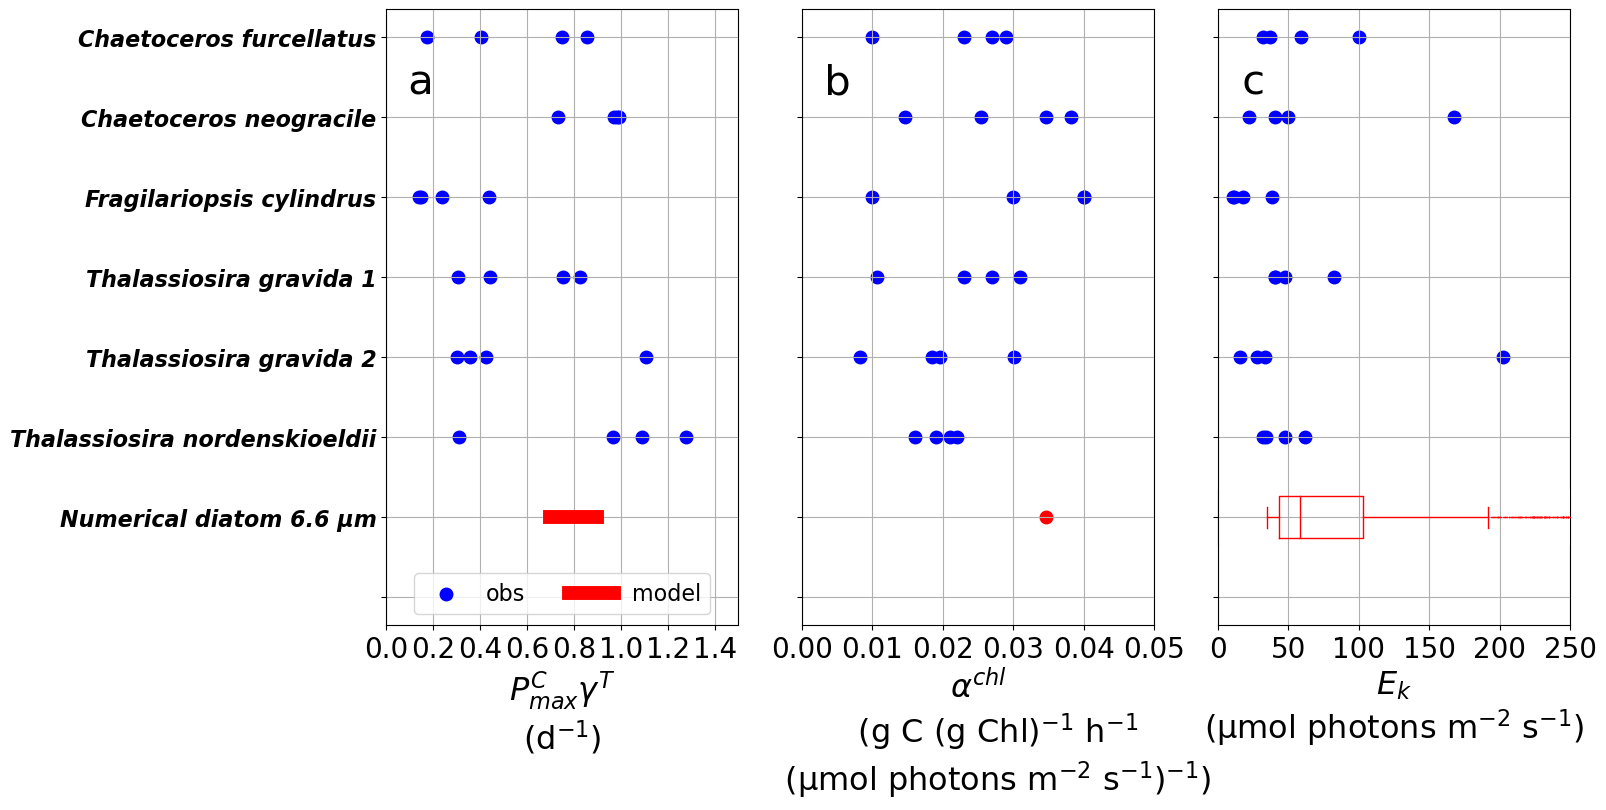

In [94]:
def make_plots(axs):
    
    # --- MAXIMUM PHOTOSYNTHESIS RATE AT SATURATION IRRADIANCE
    # --- IN NUTRIENT REPLETE CONDITIONS
    # --- (P^C_max * gamma^T)
    ax=axs[0,0]
    xlim=(0,1.5)
    h1=ax.scatter(obsPCmax_df.value,obsPCmax_df.species,
                  color='b',label='obs')
    h2=ax.axhline('',
            xmin=minpcmaxgammaT/xlim[1],
            xmax=maxpcmaxgammaT/xlim[1],
            color='red',lw=10)
    h3=ax.axhline('foo',
                 lw=0)
    # to have the ytick labels in alphabetical order from top to bottom
    ax.invert_yaxis()
    # in italics
    # FULL GENUS
    ax.set_yticklabels(['Chaetoceros furcellatus',
                        'Chaetoceros neogracile',
                        'Fragilariopsis cylindrus',
                        'Thalassiosira gravida 1',
                        'Thalassiosira gravida 2',
                        'Thalassiosira nordenskioeldii',
                        'Numerical diatom 6.6 μm'
                       ],
                       fontstyle='italic',
                       fontweight='bold')
    ax.set_xlim(xlim)
    ax.set_xlabel('$P^C_{max} \gamma^T$\n($\mathrm{ d^{-1} }$)')
    ax.grid()
    plt.text(0.10,0.88,' a ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    ax.legend([h1,h2],['obs','model'],ncol=2,loc='lower center')
    
    # --- NOTHING
    axs[1,0].axis('off')
    
    # --- LINEAR INITIAL SLOPE OF THE CHL A-SPECIFIC PHOTOSYNTHESIS
    # --- VERSUS IRRADIANCE CURVE
    # --- (ALPHA^CHL)
    ax=axs[0,1]
    xlim=(0,0.05)
    h1=ax.scatter(obsalphachl_df.value,
                  obsalphachl_df.species,
                  c='b',label='obs')
    h2=ax.scatter(modalphachl,
                  '',
                  color='red')
    h3=ax.axhline('foo',
                  lw=0)
    # to have the ytick labels in alphabetical order from top to bottom
    ax.invert_yaxis()
    ax.set_yticklabels([])
    ax.set_xlim(xlim)
    ax.set_xlabel('''$\\alpha^{chl}$\n\
    $\mathrm{ (g\ C\ (g\ Chl)^{-1}\ h^{-1} }$\n\
    $\mathrm{ (\mu mol\ photons\ m^{-2}\ s^{-1})^{-1}) }$''')
    ax.grid()
    plt.text(0.10,0.88,' b ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    
    # --- NOTHING
    axs[1,1].axis('off')
    
    # --- LIGHT SATURATION PARAMETER
    # --- (E_k)
    ax=axs[0,2]
    xlim=(0,250)
    h1=ax.scatter(obsEk_df.value,
                  obsEk_df.species,
                  c='b',label='obs')
    h3=ax.axhline('foo',
                  lw=0)
    h4=ax.axhline('foo2',
                  lw=0)
    # to have the ytick labels in alphabetical order from top to bottom
    ax.invert_yaxis()
    ax.set_yticklabels([])
    ax.set_xlabel('$E_k$\n$\mathrm{ (\mu mol\ photons\ m^{-2}\ s^{-1}) }$')
    ax.set_xlim(xlim)
    ax.grid()
    plt.text(0.10,0.88,' c ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)

    ax=axs[1,2]
    boxplot=ax.boxplot(array1d_i_modEk15light,
                       vert=False,
                       widths=0.75,
                       boxprops=dict(color='red'),
                       flierprops=dict(marker='o',
                                       markerfacecolor='red',
                                       markeredgecolor='none',
                                       markersize=1),
                       medianprops=dict(color='red'),
                       capprops=dict(color='red'),
                       whiskerprops=dict(color='red'))
    ax.set_xlim(xlim)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
#     ax.spines['left'].set_visible(False)
    ax.tick_params(length=0)
    ax.grid()
    
    # --- POSITION
    # FULL GENUS
    axs[0,0].set_position( [0.24,0.21  ,0.22,0.77])
    axs[0,1].set_position( [0.50,0.21  ,0.22,0.77])
    axs[0,2].set_position( [0.76,0.21  ,0.22,0.77])
    axs[1,2].set_position( [0.76,0.31  ,0.22,0.07])
    
    return boxplot

with plt.style.context('mplstyles/lacour17.mplstyle'):    
    # Plot
    fig,axs=plt.subplots(2,3,figsize=(16, 8))
    boxplot=make_plots(axs)

    # --- SAVE
    plt.savefig('figures_timing_sup_progress/lacour17.'+ext,dpi=dpi)

Where IQR is the interquartile range (Q3-Q1), the upper whisker will extend to last datum less than Q3+whis*IQR (https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.boxplot.html).

In [95]:
upper_whisker=[item.get_xdata()[1] for item in boxplot['whiskers']][1]
fliers=array1d_i_modEk15light[array1d_i_modEk15light>upper_whisker]
nb_fliers=fliers.size
nb_total=array1d_i_modEk15light.size

Number of outliers

In [96]:
nb_fliers

357

Number of data points

In [97]:
nb_total

3357

# Output from model CGRF

input file: 1D_GDPS_qsw_y2016.nc

name: qsw

Variable qsw is the downwelling shortwave radiation just above surface
in energy units ($\mathrm{ E_s(z=0^+,SW) }$ in $\mathrm{ W m^{-2} }$).
It is at indices (2,2) meaning centre of grid point was used. File 1D_GDPS_qsw_y2016.nc is the output of CMC GDPS reforecasts (CGRF, Smith et al., 2014, https://doi.org/10.1002/qj.2194.) CMC: Canadian Meteorological Centre's. GDPS: global deterministic prediction system. The data was provided by Gregory Smith (Environment Canada). Gaetan Olivier (UBO) preprocessed it to get the data at the Green Edge 2016 ice camp (67.48N, -63.79E).

The goal was to calculate scalar PAR just below open water in photons
density flux
($\mathrm{ E_{0,w}(z=0^-,PAR[Q]) }$
in $\mathrm{ \mu mol\ photons\ m^{-2}\ s^{-1} }$)
from $\mathrm{ E_s(z=0^+,SW) }$.

Daily downwelling shortwave radiation just above surface in energy units
($\mathrm{ E_s(z=0^+,SW) }$ in $\mathrm{ W m^{-2} }$).

In [98]:
ndays=365
qswow_file='data/DataS8_output_cgrf/1D_GDPS_qsw_y2016.nc'
array1d_iT_qswowabovehourly=netcdf_tools.read_netcdf(qswow_file,'qsw')
array1d_iT_qswowabovehourly=array1d_iT_qswowabovehourly[:,1,1]
array1d_idoy_qswowabove=np.zeros(ndays)
for idoy in first_year:
    qswowabovedaily=0
    for iT in np.arange(idoy*24,(idoy+1)*24):
        qswowabovedaily=qswowabovedaily+array1d_iT_qswowabovehourly[iT]
    qswowabovedaily=qswowabovedaily/24
    array1d_idoy_qswowabove[idoy]=qswowabovedaily

Daily downwelling shortwave radiation just below open water
in energy units
($\mathrm{ E_s(z=0^-,SW) }$ in $\mathrm{ W m^{-2} }$).

In [99]:
albedo=0.066 # model PISCES, ref.: Aumont et al. (2015)
array1d_idoy_qswow=array1d_idoy_qswowabove*(1-albedo)

Daily scalar PAR just below open water in energy units
($\mathrm{ E_{0,w}(z=0^-,PAR[W]) }$ in $\mathrm{ W m^{-2} }$).

In [100]:
Wm2_to_PAR=0.43 # model PISCES, ref.: Aumont et al. (2015)
array1d_idoy_PARow=array1d_idoy_qswow*Wm2_to_PAR

Daily scalar irradiance just below open water for band lambda in energy units
($\mathrm{ E_{0,w,\lambda}(z=0^-,PAR[W]) }$ in $\mathrm{ W m^{-2} }$).

In [101]:
onecolor=1/3
array1d_idoy_blueWm2ow=array1d_idoy_PARow*onecolor
array1d_idoy_greenWm2ow=array1d_idoy_PARow*onecolor
array1d_idoy_redWm2ow=array1d_idoy_PARow*onecolor

Daily scalar irradiance just below open water for band lambda
in photons density flux
($\mathrm{ E_{0,w,\lambda}(z=0^-,PAR[Q]) }$
in
$\mathrm{ \mu mol\ photons\ m^{-2}\ s^{-1} }$).

ref: https://gud.mit.edu/MITgcm/source/pkg/gud/gud_radtrans_direct.F?v=gud

In [102]:
rmus=1/0.83
planck = 6.6256e-34  # Plancks constant J sec
c = 2.998e8          # speed of light m/sec
hc = 1.0/(planck*c)
oavo = 1.0/6.023e23  # 1/Avogadros number
hcoavo = hc*oavo
wb_center=np.array([450,550,650]) # [blue, green, red]
rlamm=wb_center*1e-9 # lambda in m
WtouEins=1e6*rlamm*hcoavo

In [103]:
array1d_idoy_blueow =array1d_idoy_blueWm2ow *WtouEins[0]
array1d_idoy_greenow=array1d_idoy_greenWm2ow*WtouEins[1]
array1d_idoy_redow  =array1d_idoy_redWm2ow  *WtouEins[2]

Daily scalar PAR just below open water in photons density flux
($\mathrm{ E_{0,w}(z=0^-,PAR[Q]) }$
in
$\mathrm{ \mu mol\ photons\ m^{-2}\ s^{-1} }$).

In [104]:
array1d_idoy_PARowuEin=array1d_idoy_blueow\
+array1d_idoy_greenow\
+array1d_idoy_redow

# Plot: PAR

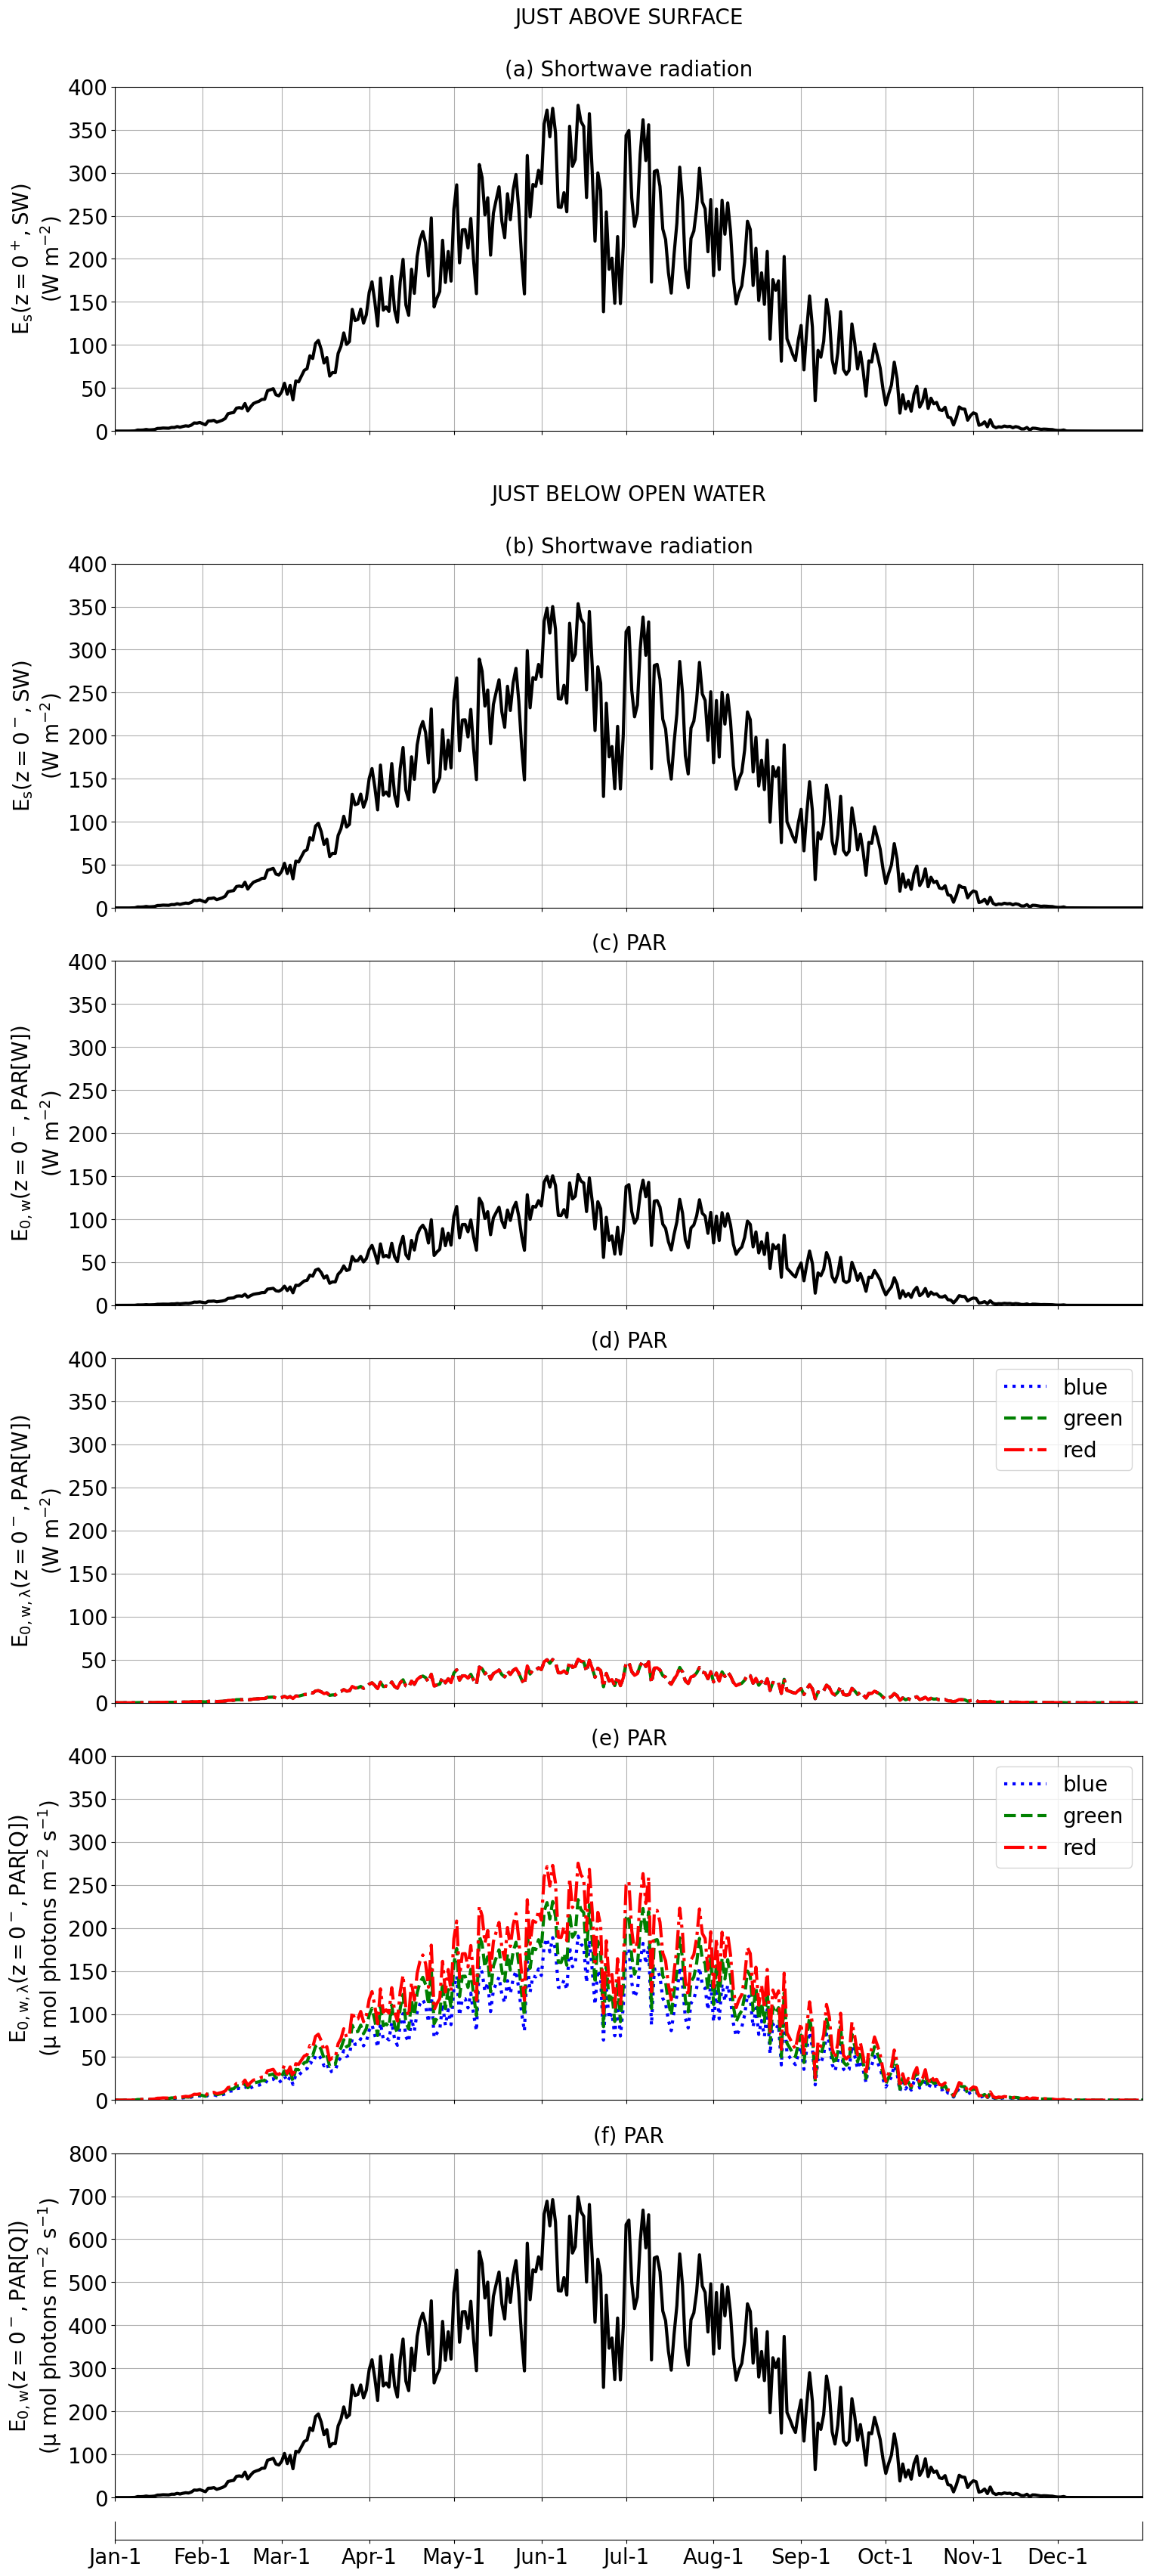

In [105]:
def make_plots(axs):
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')
    
    # --- DOWNWELLING SHORTWAVE RADIATION JUST ABOVE SURFACE
    # --- IN ENERGY UNITS
    ax=axs[0]
    ax.plot(first_year,array1d_idoy_qswowabove,color='black')
    ax.set_ylabel('$\mathrm{ E_s(z=0^+,SW) }$\n'
                  '($\mathrm{ W\ m^{-2} }$)')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,400)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.grid()
    plt.text(0.50,1.20,
             'JUST ABOVE SURFACE',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes)
    plt.text(0.50,1.05,
             '(a) Shortwave radiation',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes)
    
    # --- DOWNWELLING SHORTWAVE RADIATION JUST BELOW OPEN WATER
    # --- IN ENERGY UNITS
    ax=axs[1]
    ax.plot(first_year,array1d_idoy_qswow,color='black')
    ax.set_ylabel('$\mathrm{ E_s(z=0^-,SW) }$\n'
                  '($\mathrm{ W\ m^{-2} }$)')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,400)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.grid()
    plt.text(0.50,1.20,
             'JUST BELOW OPEN WATER',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes)
    plt.text(0.50,1.05,
             '(b) Shortwave radiation',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes)
    
    # --- DAILY SCALAR PAR JUST BELOW OPEN WATER IN ENERGY UNITS
    ax=axs[2]
    ax.plot(first_year,array1d_idoy_PARow,color='black')
    ax.set_ylabel('$\mathrm{ E_{0,w}(z=0^-,PAR[W]) }$\n'
                  '($\mathrm{ W\ m^{-2} }$)')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,400)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.grid()
    plt.text(0.50,1.05,
             '(c) PAR',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes)
    
    # --- DAILY SCALAR IRRADIANCE JUST BELOW OPEN WATER FOR BAND LAMBDA
    # --- IN ENERGY UNITS
    ax=axs[3]
    ax.plot(first_year,array1d_idoy_blueWm2ow,
                  ':',color='blue',label='blue')
    ax.plot(first_year,array1d_idoy_greenWm2ow,
                  '--',color='green',label='green')
    ax.plot(first_year,array1d_idoy_redWm2ow,
                  '-.',color='red',label='red')
    ax.legend()
    ax.set_ylabel('$\mathrm{ E_{0,w,\lambda}(z=0^-,PAR[W]) }$\n'
                  '($\mathrm{ W\ m^{-2} }$)')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,400)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.grid()
    plt.text(0.50,1.05,
             '(d) PAR',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes)
    
    # --- DAILY SCALAR IRRADIANCE JUST BELOW OPEN WATER FOR BAND LAMBDA
    # --- IN PHOTONS DENSITY FLUX
    ax=axs[4]
    ax.plot(first_year,array1d_idoy_blueow,
                  ':',color='blue',label='blue')
    ax.plot(first_year,array1d_idoy_greenow,
                  '--',color='green',label='green')
    ax.plot(first_year,array1d_idoy_redow,
                  '-.',color='red',label='red')
    ax.legend()
    ax.set_ylabel('$\mathrm{ E_{0,w,\lambda}(z=0^-,PAR[Q]) }$\n'
                  '($\mathrm{ \mu\ mol\ photons\ m^{-2}\ s^{-1} }$)')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,400)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.grid()
    plt.text(0.50,1.05,
             '(e) PAR',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes)
    
    # --- DAILY SCALAR PAR JUST BELOW OPEN WATER IN PHOTONS DENSITY FLUX
    ax=axs[5]
    ax.plot(first_year,array1d_idoy_PARowuEin,color='black')
    ax.set_ylabel('$\mathrm{ E_{0,w}(z=0^-,PAR[Q]) }$\n'
                  '($\mathrm{ \mu\ mol\ photons\ m^{-2}\ s^{-1} }$)')
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_ylim(0,800)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.grid()
    plt.text(0.50,1.05,
             '(f) PAR',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes)
    
    # --- ADDITIONAL X-AXIS
    ax=axs[6]
    ax.set_xlim(first_year[0],first_year[-1])
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # --- POSITION
    axs[0].set_position( [0.13,0.81  ,0.85,0.13])
    axs[1].set_position( [0.13,0.63  ,0.85,0.13])
    axs[2].set_position( [0.13,0.48  ,0.85,0.13])
    axs[3].set_position( [0.13,0.33  ,0.85,0.13])
    axs[4].set_position( [0.13,0.18  ,0.85,0.13])
    axs[5].set_position( [0.13,0.03  ,0.85,0.13])
    axs[6].set_position( [0.13,0.014 ,0.85,0.007])

with plt.style.context('mplstyles/par.mplstyle'):   
    # Plot
    fig,axs=plt.subplots(nrows=7,figsize=(16.00, 35.05))
    make_plots(axs)

    # --- SAVE
    plt.savefig('figures_timing_sup_progress/par.'+ext,dpi=dpi)

## Plot: Concentrations of nitrate, silicic acid, phosphate, and Chl $a$

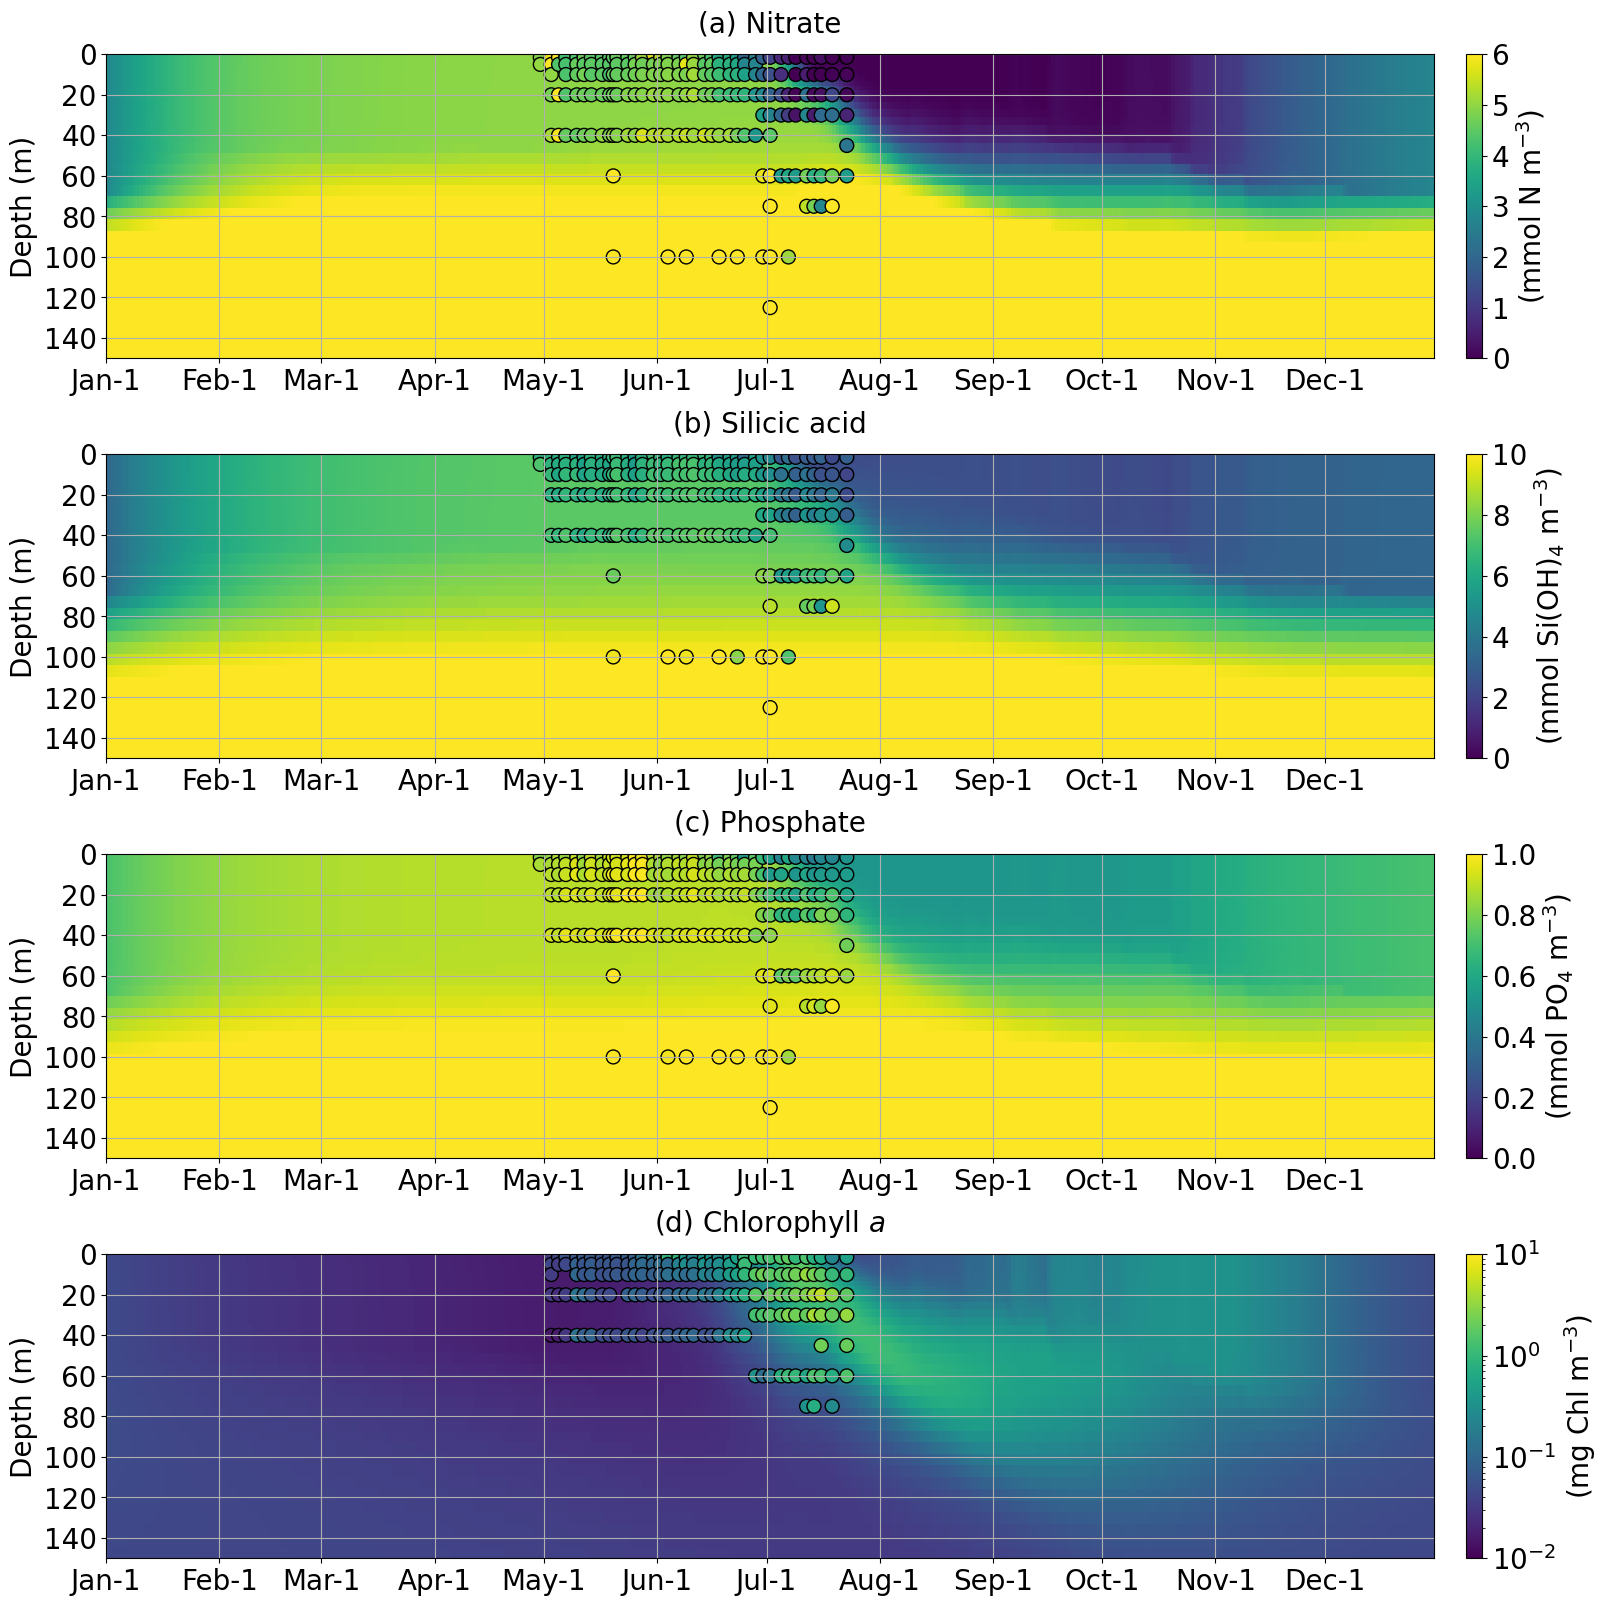

In [106]:
def make_plots(axs):
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')
    RF_above151=RF[RF<151]
    
    # --- NITRATE
    ax=axs[0]
    h=ax.pcolormesh(first_year366,
                    RF_above151,
                    array2d_idepth_iT_modno3[0:(RF_above151.size)-1,:],
                    cmap='viridis',
                    vmin=0,
                    vmax=6)
    ax.scatter(nutrients_df['doy']-1,
               nutrients_df['depth'],
               c=nutrients_df['no3'],
               cmap='viridis',
               vmin=0,
               vmax=6,
               s=100,
               edgecolor='k')
    ax.set_xticklabels([])
    ax.set_ylabel('Depth (m)')
    ax.set_xlim(first_year366[0],first_year[-1])
    ax.set_ylim(150,0)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    cbaxes = fig.add_axes([0.92,0.78, 0.01,0.19])
    cbar=plt.colorbar(h,
                      cax = cbaxes)
    cbar.set_label('(mmol N $\mathrm{ m^{-3} }$)')
    plt.text(0.50,1.10,'(a) Nitrate',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes)
    
    # --- SILICIC ACID
    ax=axs[1]
    h=ax.pcolormesh(first_year366,
                    RF_above151,
                    array2d_idepth_iT_modsioh4[0:(RF_above151.size)-1,:],
                    cmap='viridis',
                    vmin=0,
                    vmax=10)
    ax.scatter(nutrients_df['doy']-1,
               nutrients_df['depth'],
               c=nutrients_df['sioh4'],
               cmap='viridis',
               vmin=0,
               vmax=10,
               s=100,
               edgecolor='k')
    ax.set_xticklabels([])
    ax.set_ylabel('Depth (m)')
    ax.set_xlim(first_year366[0],first_year[-1])
    ax.set_ylim(150,0)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    cbaxes = fig.add_axes([0.92,0.53, 0.01,0.19])
    cbar=plt.colorbar(h,
                      cax = cbaxes)
    cbar.set_label('(mmol Si$\mathrm{ {(OH)}_4 }$ $\mathrm{ m^{-3} }$)')
    plt.text(0.50,1.10,'(b) Silicic acid',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes)
    
    # --- PHOSPHATE
    ax=axs[2]
    h=ax.pcolormesh(first_year366,
                    RF_above151,
                    array2d_idepth_iT_modpo4[0:(RF_above151.size)-1,:],
                    cmap='viridis',
                    vmin=0,
                    vmax=1)
    ax.scatter(nutrients_df['doy']-1,
               nutrients_df['depth'],
               c=nutrients_df['po4'],
               cmap='viridis',
               vmin=0,
               vmax=1,
               s=100,
               edgecolor='k')
    ax.set_xticklabels([])
    ax.set_ylabel('Depth (m)')
    ax.set_xlim(first_year366[0],first_year[-1])
    ax.set_ylim(150,0)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    cbaxes = fig.add_axes([0.92,0.28, 0.01,0.19])
    cbar=plt.colorbar(h,
                      cax = cbaxes)
    cbar.set_label('(mmol $\mathrm{ PO_4 }$ $\mathrm{ m^{-3} }$)')
    plt.text(0.50,1.10,'(c) Phosphate',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes)
    
    # --- CHLOROPHYLL A
    ax=axs[3]
    h=ax.pcolormesh(first_year366,
                    RF_above151,
                    array2d_idepth_iT_modchl[0:(RF_above151.size)-1,:],
                    cmap='viridis',
                    norm=mpl.colors.LogNorm(vmin=1E-2, vmax=10))
    ax.scatter(chlHPLC_df['doy']-1,
               chlHPLC_df['depth'],
               c=chlHPLC_df['chlHPLC'],
               cmap='viridis',
               norm=mpl.colors.LogNorm(vmin=1E-2, vmax=10),
               s=100,
               edgecolor='k')
    ax.set_xticklabels([])
    ax.set_ylabel('Depth (m)')
    ax.set_xlim(first_year366[0],first_year[-1])
    ax.set_ylim(150,0)
    ax.grid()
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    cbaxes = fig.add_axes([0.92,0.03, 0.01,0.19])
    cbar=plt.colorbar(h,
                      cax = cbaxes)
    cbar.set_label('(mg Chl $\mathrm{ m^{-3} }$)')
    plt.text(0.50,1.10,'(d) Chlorophyll $a$',
             horizontalalignment = 'center', verticalalignment='center',
             transform=ax.transAxes)
    
    # --- POSITION
    axs[0].set_position( [0.07,0.78  ,0.83,0.19])
    axs[1].set_position( [0.07,0.53  ,0.83,0.19])
    axs[2].set_position( [0.07,0.28  ,0.83,0.19])
    axs[3].set_position( [0.07,0.03  ,0.83,0.19])

with plt.style.context('mplstyles/concentrations_nutrients_Chla.mplstyle'):    
    # Plot
    fig,axs=plt.subplots(4,1,figsize=(16,16))
    make_plots(axs)

    # --- SAVE
    plt.savefig('figures_timing_sup_progress/sup_concentrations_nutrients_Chla.'+ext,dpi=dpi)

# Taylor diagram

In [107]:
"""
project simulation onto observations

Args:
    obs_df(pandas.DataFrame):
        The columns contains 'doy' and 'depth'.
        The rows are the observations.
        Observations of in situ variables.
    array2d_idepth_iT_mod(numpy.array):
        Array of 2 dimensions.
        The first dimension is the indices of the depths.
        The second dimension is the indices of the time steps.
        The values are the simulated tracer.
    mod_varname(str):
        The desired name of the variable in the output mod_df.
    array1d_idepth_delR(numpy.array):
        Array of 1 dimension.
        The first dimension is the indices of the depths.
        The values are the the r cell face separations, meaning the
        thickness of each depth layer (in m).
        It corresponds to delR on
        https://mitgcm.readthedocs.io/en/latest/getting_started/getting_started.html#grid

Returns:
    mod_df(pandas.DataFrame):
    The columns are 'doy',depth',mod_varname.
    The rows are the interpolated simulated values for each in situ
    observations.
    doy is day of year (1-based).
    depth is depth in m.
    mod_varname is the interpolated simulated value of the tracer.
"""

def project_mod_on_obs(obs_df,
                       array2d_idepth_iT_mod,
                       mod_varname,
                       array1d_idepth_delR):
    array1d_iobs_mod=list()
    for iobs,row in obs_df.iterrows():
        doy=row['doy']
        depthobs=row['depth']
        assert depthobs>=0, \
        "depthobs is negative: %r" %(depthobs)
        assert depthobs<RC[-1], \
        "depthobs %r is below maximal depth of model grid %r" %(depthobs,RC[-1])
        y_interp=scipy.interpolate.interp1d(
            array1d_idepth_delR,
            array2d_idepth_iT_mod[:,doy-1].flatten(),
            bounds_error=False,
            fill_value="extrapolate")
        mod=y_interp(depthobs).item()
        array1d_iobs_mod.append(mod)
    mod_df=pd.DataFrame({
        'doy':obs_df['doy'],
        'depth':obs_df['depth'],
        mod_varname:array1d_iobs_mod
    })
    return mod_df

The values at 0.51 m on the model grid are extrapolated to 0 m.
It is the only extrapolation.

In [108]:
no3mod_df=project_mod_on_obs(obs_df=nutrients_df,
                             array2d_idepth_iT_mod\
                             =array2d_idepth_iT_modno3,
                             mod_varname='no3',
                             array1d_idepth_delR=RC)
sioh4mod_df=project_mod_on_obs(obs_df=nutrients_df,
                             array2d_idepth_iT_mod\
                             =array2d_idepth_iT_modsioh4,
                             mod_varname='sioh4',
                             array1d_idepth_delR=RC)
po4mod_df=project_mod_on_obs(obs_df=nutrients_df,
                             array2d_idepth_iT_mod\
                             =array2d_idepth_iT_modpo4,
                             mod_varname='po4',
                             array1d_idepth_delR=RC)
nutrientsmod_df=pd.concat([no3mod_df,
                           sioh4mod_df['sioh4'],
                           po4mod_df['po4']],
                          axis=1)
chlmod_df=project_mod_on_obs(obs_df=chlHPLC_df,
                             array2d_idepth_iT_mod\
                             =array2d_idepth_iT_modchl,
                             mod_varname='chl',
                             array1d_idepth_delR=RC)

In [109]:
"""
compute normalized standard deviation and correlation coefficient

Args:
    obs_df(pandas.DataFrame):
        The columns contains 'doy' and 'depth'.
        The rows are the observations.
        Observations of in situ variables.
    obs_varname(str):
        The name of the variable in obs_df.
    mod_df(pandas.DataFrame):
        The columns are 'doy',depth',mod_varname.
        The rows are the interpolated simulated values for each in situ
        observations.
        doy is day of year (1-based).
        depth is depth in m.
        mod_varname is the interpolated simulated value of the tracer.
    mod_varname(str):
        The name of the variable in mod_df.

Returns:
    (nstd,corrcoeff)(float,float):
    nstd: standard deviation between obs_varname and mod_varname
    corrcoeff: correlation coefficient between obs_varname and mod_varname
"""
def get_nstd_corrcoef(obs_df,obs_varname,mod_df,mod_varname):
    assert mod_df['doy'].equals(obs_df['doy']), \
    "column doy in mod_df is different from column doy in obs_df"
    assert mod_df['depth'].equals(obs_df['depth']), \
    "column depth in mod_df is different from column depth in obs_df"
    s=obs_df[obs_varname].copy()
    s[s==0]=np.NaN
    array1d_iobs_logobs=np.log10(s)
    array1d_iobs_logmod=np.log10(mod_df[mod_varname])
    refnstd=np.nanstd(array1d_iobs_logobs,ddof=1) \
    /np.nanstd(array1d_iobs_logobs,ddof=1)
    assert refnstd==1,\
    "the reference normalized standard deviation (REF) is not 1"
    nstdlog=np.nanstd(array1d_iobs_logmod,ddof=1) \
    /np.nanstd(array1d_iobs_logobs,ddof=1)
    corrcoeflog=(pd.DataFrame(
        {'array1d_iobs_logobs':array1d_iobs_logobs,
         'array1d_iobs_logmod':array1d_iobs_logmod}) \
                 .corr()).iloc[0,1]
    return nstdlog,corrcoeflog

In [110]:
nstdlogno3,corrcoeflogno3=get_nstd_corrcoef(obs_df=nutrients_df,
                                           obs_varname='no3',
                                           mod_df=nutrientsmod_df,
                                           mod_varname='no3')
nstdlogsioh4,corrcoeflogsioh4=get_nstd_corrcoef(obs_df=nutrients_df,
                                                obs_varname='sioh4',
                                                mod_df=nutrientsmod_df,
                                                mod_varname='sioh4')
nstdlogpo4,corrcoeflogpo4=get_nstd_corrcoef(obs_df=nutrients_df,
                                            obs_varname='po4',
                                            mod_df=nutrientsmod_df,
                                            mod_varname='po4')
nstdlogchl,corrcoeflogchl=get_nstd_corrcoef(obs_df=chlHPLC_df,
                                            obs_varname='chlHPLC',
                                            mod_df=chlmod_df,
                                            mod_varname='chl')

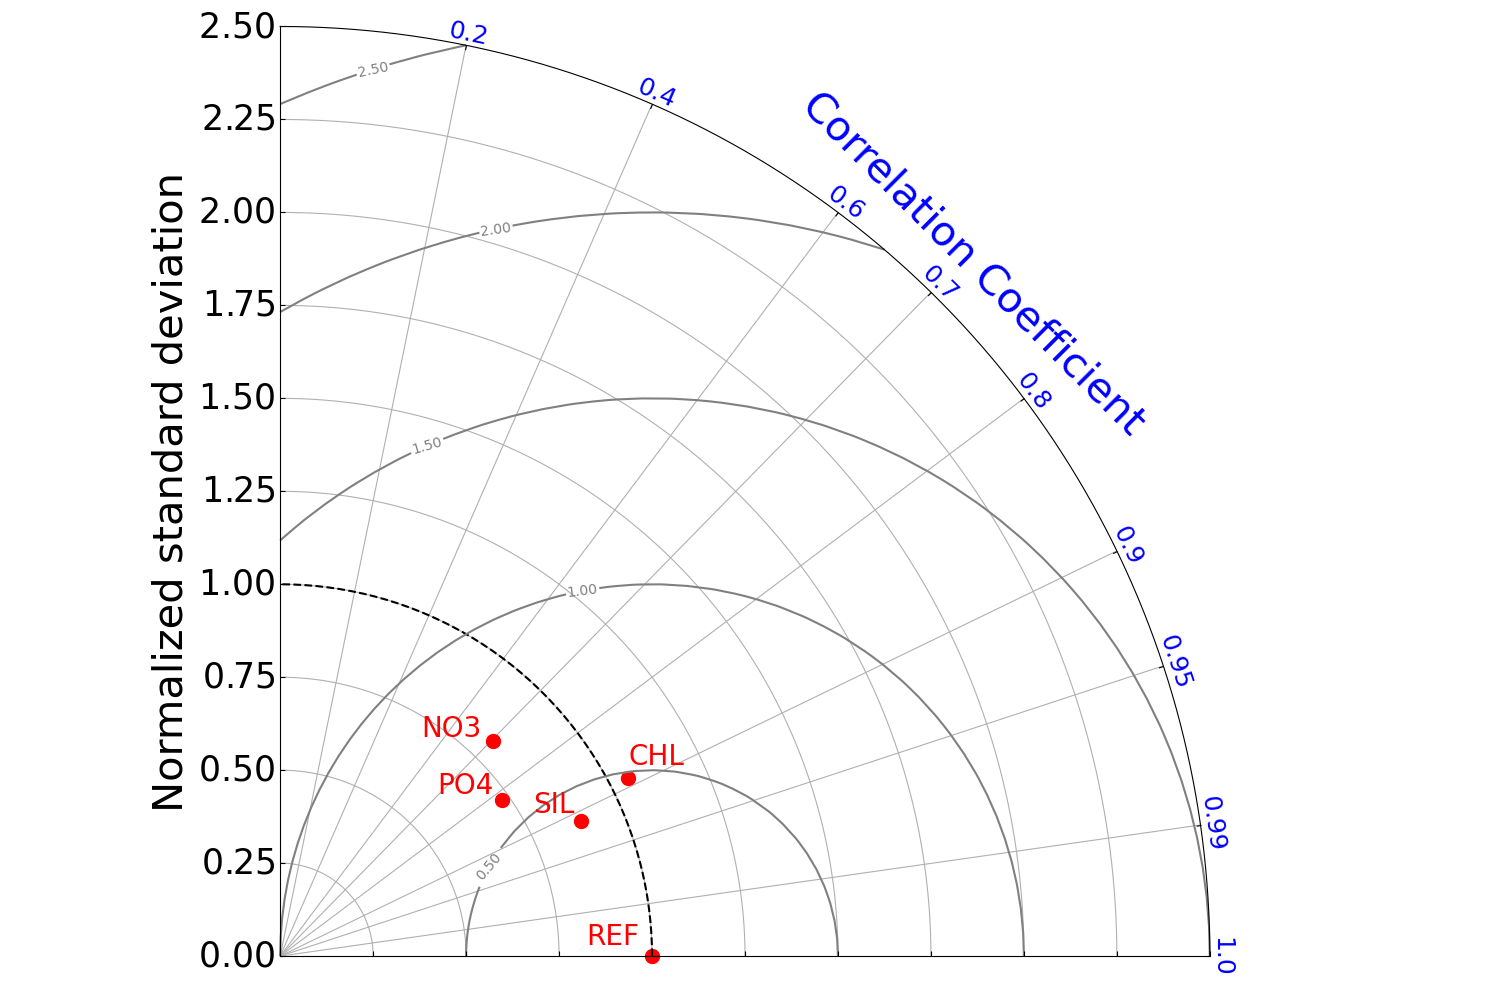

In [111]:
def make_plots(axs):
    plt.axis('off')
    refnstd=1
    dia=TaylorDiagram.TaylorDiagram(refnstd,
                                    fig=fig,
                                    rect=111,
                                    label='Reference',
                                    srange=(0,2.5),
                                    extend=False)
    dia.add_sample(nstdlogchl,
                   corrcoeflogchl,
                   marker='o',
                   ms=10,
                   ls='',
                   mfc='red',
                   mec='red')
    dia.add_sample(nstdlogno3,
                   corrcoeflogno3,
                   marker='o',
                   ms=10,
                   ls='',
                   mfc='red',
                   mec='red')
    dia.add_sample(nstdlogsioh4,
                   corrcoeflogsioh4,
                   marker='o',
                   ms=10,
                   ls='',
                   mfc='red',
                   mec='red')
    dia.add_sample(nstdlogpo4,
                   corrcoeflogpo4,
                   marker='o',
                   ms=10,
                   ls='',
                   mfc='red',
                   mec='red')
    dia.add_grid()
    contours=dia.add_contours(colors='0.5')
    plt.clabel(contours, inline=1, fontsize=10, fmt='%.2f')
    plt.text(0.44,0.22,'CHL',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, color='red', fontsize=20)
    plt.text(0.30,0.25,'NO3',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, color='red', fontsize=20)
    plt.text(0.37,0.17,'SIL',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, color='red', fontsize=20)
    plt.text(0.31,0.19,'PO4',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, color='red', fontsize=20)
    plt.text(0.41,0.03,'REF',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, color='red', fontsize=20)
    plt.tight_layout()
with plt.style.context('mplstyles/taylor.mplstyle'):   
    # Plot
    fig=plt.figure(figsize=(15,10))
    ax=fig.add_subplot(111)
    make_plots(axs)

    # --- SAVE
    plt.savefig('figures_timing_sup_progress/sup_taylor.'+ext,dpi=dpi)

# EXP-1

Differing minimum biomass.

## EXP-1: infiles

In [112]:
infile_car_EXP1_grp_Xmin_1Eminus3\
='data/DataS6_output_mitgcm/exp1_Cmin1Eminus3/car.0000000000.t001.nc'
infile_car_EXP1_grp_Xmin_1Eminus2\
='data/DataS6_output_mitgcm/exp1_Cmin1Eminus2/car.0000000000.t001.nc'
infile_car_EXP1_grp_Xmin_1Eminus1\
='data/DataS6_output_mitgcm/exp1_Cmin1Eminus1/car.0000000000.t001.nc'

## EXP-1: $\mathrm{ \sum C_{phyto} }$

$\mathrm{ \sum C_{phyto} }$ is the vertically integrated 
$\mathrm{ C_{phyto} }$ (0-100m)
in $\mathrm{ mg\ C\ m^{-2} }$.

In [113]:
depth_end=100 # m

### EXP-1: $\mathrm{ \sum C_{phyto} }$: groups

$\mathrm{ \sum C_{phyto} }$ for each phytoplankton group.

#### EXP-1: $\mathrm{ \sum C_{phyto} }$: groups: grp_Xmin=$\mathrm{ 1*10^{-3}\ mmol\ C\ m^{-3}\ {type}^{-1} }$

In [114]:
array1d_iT_biodiatoms_EXP1_grp_Xmin_1Eminus3\
=read_mitgcm.get_array1d_iT_biodiatoms(
    infile=infile_car_EXP1_grp_Xmin_1Eminus3,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biodiatoms_EXP1_grp_Xmin_1Eminus3\
=array1d_iT_biodiatoms_EXP1_grp_Xmin_1Eminus3/1000 # mg C -> g C

array1d_iT_biodino_EXP1_grp_Xmin_1Eminus3\
=read_mitgcm.get_array1d_iT_biodino(
    infile=infile_car_EXP1_grp_Xmin_1Eminus3,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biodino_EXP1_grp_Xmin_1Eminus3\
=array1d_iT_biodino_EXP1_grp_Xmin_1Eminus3/1000 # mg C -> g C

array1d_iT_bioother_EXP1_grp_Xmin_1Eminus3\
=read_mitgcm.get_array1d_iT_bioother(
    infile=infile_car_EXP1_grp_Xmin_1Eminus3,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_bioother_EXP1_grp_Xmin_1Eminus3\
=array1d_iT_bioother_EXP1_grp_Xmin_1Eminus3/1000 # mg C -> g C

array1d_iT_biopico_EXP1_grp_Xmin_1Eminus3\
=read_mitgcm.get_array1d_iT_biopico(
    infile=infile_car_EXP1_grp_Xmin_1Eminus3,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biopico_EXP1_grp_Xmin_1Eminus3\
=array1d_iT_biopico_EXP1_grp_Xmin_1Eminus3/1000 # mg C -> g C

#### EXP-1: $\mathrm{ \sum C_{phyto} }$: groups: grp_Xmin=$\mathrm{ 1*10^{-2}\ mmol\ C\ m^{-3}\ {type}^{-1} }$ (default)

In [115]:
array1d_iT_biodiatoms_EXP1_grp_Xmin_1Eminus2\
=read_mitgcm.get_array1d_iT_biodiatoms(
    infile=infile_car_EXP1_grp_Xmin_1Eminus2,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biodiatoms_EXP1_grp_Xmin_1Eminus2\
=array1d_iT_biodiatoms_EXP1_grp_Xmin_1Eminus2/1000 # mg C -> g C

array1d_iT_biodino_EXP1_grp_Xmin_1Eminus2\
=read_mitgcm.get_array1d_iT_biodino(
    infile=infile_car_EXP1_grp_Xmin_1Eminus2,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biodino_EXP1_grp_Xmin_1Eminus2\
=array1d_iT_biodino_EXP1_grp_Xmin_1Eminus2/1000 # mg C -> g C

array1d_iT_bioother_EXP1_grp_Xmin_1Eminus2\
=read_mitgcm.get_array1d_iT_bioother(
    infile=infile_car_EXP1_grp_Xmin_1Eminus2,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_bioother_EXP1_grp_Xmin_1Eminus2\
=array1d_iT_bioother_EXP1_grp_Xmin_1Eminus2/1000 # mg C -> g C

array1d_iT_biopico_EXP1_grp_Xmin_1Eminus2\
=read_mitgcm.get_array1d_iT_biopico(
    infile=infile_car_EXP1_grp_Xmin_1Eminus2,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biopico_EXP1_grp_Xmin_1Eminus2\
=array1d_iT_biopico_EXP1_grp_Xmin_1Eminus2/1000 # mg C -> g C

#### EXP-1: $\mathrm{ \sum C_{phyto} }$: groups: grp_Xmin=$\mathrm{ 1*10^{-1}\ mmol\ C\ m^{-3}\ {type}^{-1} }$

In [116]:
array1d_iT_biodiatoms_EXP1_grp_Xmin_1Eminus1\
=read_mitgcm.get_array1d_iT_biodiatoms(
    infile=infile_car_EXP1_grp_Xmin_1Eminus1,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biodiatoms_EXP1_grp_Xmin_1Eminus1\
=array1d_iT_biodiatoms_EXP1_grp_Xmin_1Eminus1/1000 # mg C -> g C

array1d_iT_biodino_EXP1_grp_Xmin_1Eminus1\
=read_mitgcm.get_array1d_iT_biodino(
    infile=infile_car_EXP1_grp_Xmin_1Eminus1,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biodino_EXP1_grp_Xmin_1Eminus1\
=array1d_iT_biodino_EXP1_grp_Xmin_1Eminus1/1000 # mg C -> g C

array1d_iT_bioother_EXP1_grp_Xmin_1Eminus1\
=read_mitgcm.get_array1d_iT_bioother(
    infile=infile_car_EXP1_grp_Xmin_1Eminus1,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_bioother_EXP1_grp_Xmin_1Eminus1\
=array1d_iT_bioother_EXP1_grp_Xmin_1Eminus1/1000 # mg C -> g C

array1d_iT_biopico_EXP1_grp_Xmin_1Eminus1\
=read_mitgcm.get_array1d_iT_biopico(
    infile=infile_car_EXP1_grp_Xmin_1Eminus1,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biopico_EXP1_grp_Xmin_1Eminus1\
=array1d_iT_biopico_EXP1_grp_Xmin_1Eminus1/1000 # mg C -> g C

### EXP-1: $\mathrm{ \sum C_{phyto} }$: sizes

$\mathrm{ \sum C_{phyto} }$ for each phytoplankton size class.

#### EXP-1: $\mathrm{ \sum C_{phyto} }$: sizes: grp_Xmin=$\mathrm{ 1*10^{-3}\ mmol\ C\ m^{-3}\ {type}^{-1} }$

In [117]:
array1d_iT_biophytolte4_5_EXP1_grp_Xmin_1Eminus3\
=read_mitgcm.get_array1d_iT_biophytolte4_5(
    infile=infile_car_EXP1_grp_Xmin_1Eminus3,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biophytolte4_5_EXP1_grp_Xmin_1Eminus3\
=array1d_iT_biophytolte4_5_EXP1_grp_Xmin_1Eminus3/1000 # mg C -> g C

array1d_iT_biophyto6_6_EXP1_grp_Xmin_1Eminus3\
=read_mitgcm.get_array1d_iT_biophyto6_6(
    infile=infile_car_EXP1_grp_Xmin_1Eminus3,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biophyto6_6_EXP1_grp_Xmin_1Eminus3\
=array1d_iT_biophyto6_6_EXP1_grp_Xmin_1Eminus3/1000 # mg C -> g C

array1d_iT_biophyto10_EXP1_grp_Xmin_1Eminus3\
=read_mitgcm.get_array1d_iT_biophyto10(
    infile=infile_car_EXP1_grp_Xmin_1Eminus3,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biophyto10_EXP1_grp_Xmin_1Eminus3\
=array1d_iT_biophyto10_EXP1_grp_Xmin_1Eminus3/1000 # mg C -> g C

array1d_iT_biophyto15_EXP1_grp_Xmin_1Eminus3\
=read_mitgcm.get_array1d_iT_biophyto15(
    infile=infile_car_EXP1_grp_Xmin_1Eminus3,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biophyto15_EXP1_grp_Xmin_1Eminus3\
=array1d_iT_biophyto15_EXP1_grp_Xmin_1Eminus3/1000 # mg C -> g C

array1d_iT_biophytoge20_EXP1_grp_Xmin_1Eminus3\
=read_mitgcm.get_array1d_iT_biophytoge20(
    infile=infile_car_EXP1_grp_Xmin_1Eminus3,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biophytoge20_EXP1_grp_Xmin_1Eminus3\
=array1d_iT_biophytoge20_EXP1_grp_Xmin_1Eminus3/1000 # mg C -> g C

#### EXP-1: $\mathrm{ \sum C_{phyto} }$: sizes: grp_Xmin=$\mathrm{ 1*10^{-3}\ mmol\ C\ m^{-2}\ {type}^{-1} }$

In [118]:
array1d_iT_biophytolte4_5_EXP1_grp_Xmin_1Eminus2\
=read_mitgcm.get_array1d_iT_biophytolte4_5(
    infile=infile_car_EXP1_grp_Xmin_1Eminus2,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biophytolte4_5_EXP1_grp_Xmin_1Eminus2\
=array1d_iT_biophytolte4_5_EXP1_grp_Xmin_1Eminus2/1000 # mg C -> g C

array1d_iT_biophyto6_6_EXP1_grp_Xmin_1Eminus2\
=read_mitgcm.get_array1d_iT_biophyto6_6(
    infile=infile_car_EXP1_grp_Xmin_1Eminus2,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biophyto6_6_EXP1_grp_Xmin_1Eminus2\
=array1d_iT_biophyto6_6_EXP1_grp_Xmin_1Eminus2/1000 # mg C -> g C

array1d_iT_biophyto10_EXP1_grp_Xmin_1Eminus2\
=read_mitgcm.get_array1d_iT_biophyto10(
    infile=infile_car_EXP1_grp_Xmin_1Eminus2,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biophyto10_EXP1_grp_Xmin_1Eminus2\
=array1d_iT_biophyto10_EXP1_grp_Xmin_1Eminus2/1000 # mg C -> g C

array1d_iT_biophyto15_EXP1_grp_Xmin_1Eminus2\
=read_mitgcm.get_array1d_iT_biophyto15(
    infile=infile_car_EXP1_grp_Xmin_1Eminus2,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biophyto15_EXP1_grp_Xmin_1Eminus2\
=array1d_iT_biophyto15_EXP1_grp_Xmin_1Eminus2/1000 # mg C -> g C

array1d_iT_biophytoge20_EXP1_grp_Xmin_1Eminus2\
=read_mitgcm.get_array1d_iT_biophytoge20(
    infile=infile_car_EXP1_grp_Xmin_1Eminus2,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biophytoge20_EXP1_grp_Xmin_1Eminus2\
=array1d_iT_biophytoge20_EXP1_grp_Xmin_1Eminus2/1000 # mg C -> g C

#### EXP-1: $\mathrm{ \sum C_{phyto} }$: sizes: grp_Xmin=$\mathrm{ 1*10^{-3}\ mmol\ C\ m^{-1}\ {type}^{-1} }$

In [119]:
array1d_iT_biophytolte4_5_EXP1_grp_Xmin_1Eminus1\
=read_mitgcm.get_array1d_iT_biophytolte4_5(
    infile=infile_car_EXP1_grp_Xmin_1Eminus1,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biophytolte4_5_EXP1_grp_Xmin_1Eminus1\
=array1d_iT_biophytolte4_5_EXP1_grp_Xmin_1Eminus1/1000 # mg C -> g C

array1d_iT_biophyto6_6_EXP1_grp_Xmin_1Eminus1\
=read_mitgcm.get_array1d_iT_biophyto6_6(
    infile=infile_car_EXP1_grp_Xmin_1Eminus1,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biophyto6_6_EXP1_grp_Xmin_1Eminus1\
=array1d_iT_biophyto6_6_EXP1_grp_Xmin_1Eminus1/1000 # mg C -> g C

array1d_iT_biophyto10_EXP1_grp_Xmin_1Eminus1\
=read_mitgcm.get_array1d_iT_biophyto10(
    infile=infile_car_EXP1_grp_Xmin_1Eminus1,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biophyto10_EXP1_grp_Xmin_1Eminus1\
=array1d_iT_biophyto10_EXP1_grp_Xmin_1Eminus1/1000 # mg C -> g C

array1d_iT_biophyto15_EXP1_grp_Xmin_1Eminus1\
=read_mitgcm.get_array1d_iT_biophyto15(
    infile=infile_car_EXP1_grp_Xmin_1Eminus1,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biophyto15_EXP1_grp_Xmin_1Eminus1\
=array1d_iT_biophyto15_EXP1_grp_Xmin_1Eminus1/1000 # mg C -> g C

array1d_iT_biophytoge20_EXP1_grp_Xmin_1Eminus1\
=read_mitgcm.get_array1d_iT_biophytoge20(
    infile=infile_car_EXP1_grp_Xmin_1Eminus1,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biophytoge20_EXP1_grp_Xmin_1Eminus1\
=array1d_iT_biophytoge20_EXP1_grp_Xmin_1Eminus1/1000 # mg C -> g C

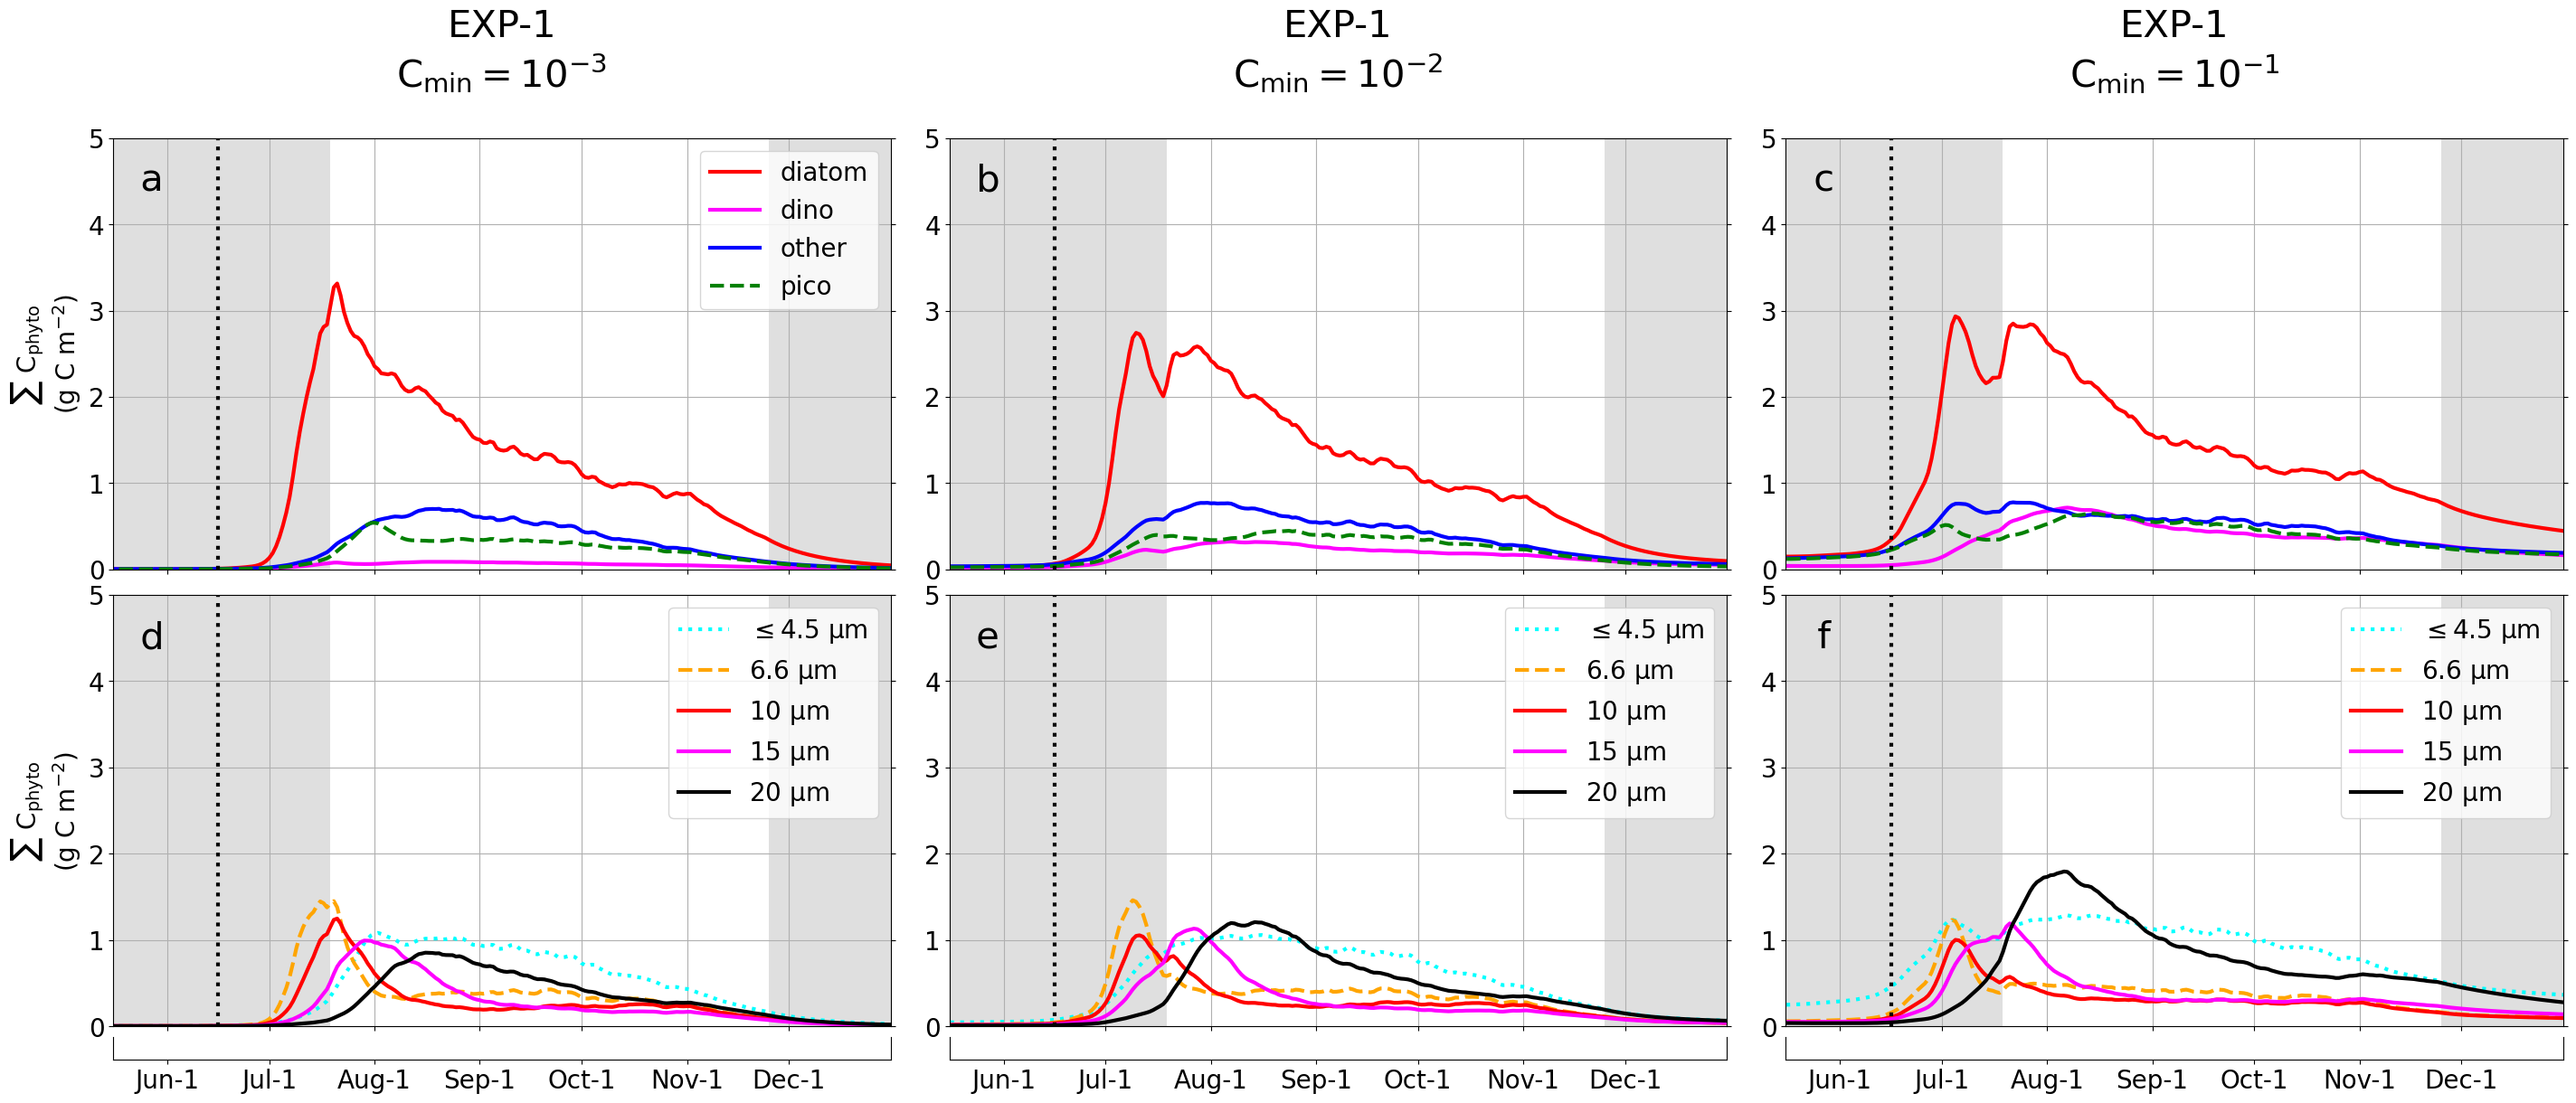

In [120]:
def make_plots(axs):
    box=dict(pad=5,alpha=0)
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')
    locs=np.array([151,
              181, 212, 243, 273, 304, 334])
    labels=('Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')
    xmin=135 # 15 May (0-based)
    xmax=364 # 31 December (0-based)
    xlims=(xmin,xmax)
    ymin=0
    ymax=5
    ylims=(ymin,ymax)
    
    # --- (A) EXP-1: SUM C_PHYTO: GROUPS: GRP_XMIN=1*10^-3
    ax=axs[0,0]
    h_biodiatoms_EXP1_grp_Xmin_1Eminus3=ax.plot(
        first_year,
        array1d_iT_biodiatoms_EXP1_grp_Xmin_1Eminus3,
        '-',color='red',label='diatom')
    h_biodino_EXP1_grp_Xmin_1Eminus3=ax.plot(
        first_year,
        array1d_iT_biodino_EXP1_grp_Xmin_1Eminus3,
        '-',color='magenta',label='dino')
    h_bioother_EXP1_grp_Xmin_1Eminus3=ax.plot(
        first_year,
        array1d_iT_bioother_EXP1_grp_Xmin_1Eminus3,
        '-',color='blue',label='other')
    h_biopico_EXP1_grp_Xmin_1Eminus3=ax.plot(
        first_year,
        array1d_iT_biopico_EXP1_grp_Xmin_1Eminus3,
        '--',color='green',label='pico')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('$\mathrm{ \sum\ C_{phyto} }$\n'
                  '($\mathrm{ g\ C\ m^{-2} }$)')
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(ylims)
    ax.grid()
    ax.legend(loc='upper right')
    plt.text(0.05,0.90,' a ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    plt.text(0.5,1.2,'EXP-1\n$\mathrm{ C_{min}=10^{-3} }$',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    ax.axvline(obs_nosnow,color='black',linestyle=':')
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup-xmin,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=xmax-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    
    # --- (B) EXP-1: SUM C_PHYTO: GROUPS: GRP_XMIN=1*10^-2 (DEFAULT)
    ax=axs[0,1]
    h_biodiatoms_EXP1_grp_Xmin_1Eminus2=ax.plot(
        first_year,
        array1d_iT_biodiatoms_EXP1_grp_Xmin_1Eminus2,
        '-',color='red',label='diatom')
    h_biodino_EXP1_grp_Xmin_1Eminus2=ax.plot(
        first_year,
        array1d_iT_biodino_EXP1_grp_Xmin_1Eminus2,
        '-',color='magenta',label='dino')
    h_bioother_EXP1_grp_Xmin_1Eminus2=ax.plot(
        first_year,
        array1d_iT_bioother_EXP1_grp_Xmin_1Eminus2,
        '-',color='blue',label='other')
    h_biopico_EXP1_grp_Xmin_1Eminus2=ax.plot(
        first_year,
        array1d_iT_biopico_EXP1_grp_Xmin_1Eminus2,
        '--',color='green',label='pico')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(ylims)
    ax.grid()
    plt.text(0.05,0.90,' b ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    plt.text(0.5,1.2,'EXP-1\n$\mathrm{ C_{min}=10^{-2} }$',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    ax.axvline(obs_nosnow,color='black',linestyle=':')
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup-xmin,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=xmax-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    
    # --- (C) EXP-1: SUM C_PHYTO: GROUPS: GRP_XMIN=1*10^-1
    ax=axs[0,2]
    h_biodiatoms_EXP1_grp_Xmin_1Eminus1=ax.plot(
        first_year,
        array1d_iT_biodiatoms_EXP1_grp_Xmin_1Eminus1,
        '-',color='red',label='diatom')
    h_biodino_EXP1_grp_Xmin_1Eminus1=ax.plot(
        first_year,
        array1d_iT_biodino_EXP1_grp_Xmin_1Eminus1,
        '-',color='magenta',label='dino')
    h_bioother_EXP1_grp_Xmin_1Eminus1=ax.plot(
        first_year,
        array1d_iT_bioother_EXP1_grp_Xmin_1Eminus1,
        '-',color='blue',label='other')
    h_biopico_EXP1_grp_Xmin_1Eminus1=ax.plot(
        first_year,
        array1d_iT_biopico_EXP1_grp_Xmin_1Eminus1,
        '--',color='green',label='pico')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(ylims)
    ax.grid()
    plt.text(0.05,0.90,' c ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    plt.text(0.5,1.2,'EXP-1\n$\mathrm{ C_{min}=10^{-1} }$',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    ax.axvline(obs_nosnow,color='black',linestyle=':')
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup-xmin,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=xmax-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    
    # --- (D) EXP-1: SUM C_PHYTO: SIZES: GRP_XMIN=1*10^-3
    ax=axs[1,0]
    h_biophytolte4_5_EXP1_grp_Xmin_1Eminus3=ax.plot(
        first_year,
        array1d_iT_biophytolte4_5_EXP1_grp_Xmin_1Eminus3,
        ':',color='cyan',label='$\mathrm{ \leq 4.5\ \mu m }$')
    h_biophyto6_6_EXP1_grp_Xmin_1Eminus3=ax.plot(
        first_year,
        array1d_iT_biophyto6_6_EXP1_grp_Xmin_1Eminus3,
        '--',color='orange',label='$\mathrm{ 6.6\ \mu m }$')
    h_biophyto10_EXP1_grp_Xmin_1Eminus3=ax.plot(
        first_year,
        array1d_iT_biophyto10_EXP1_grp_Xmin_1Eminus3,
        '-',color='red',label='$\mathrm{ 10\ \mu m }$')
    h_biophyto15_EXP1_grp_Xmin_1Eminus3=ax.plot(
        first_year,
        array1d_iT_biophyto15_EXP1_grp_Xmin_1Eminus3,
        '-',color='magenta',label='$\mathrm{ 15\ \mu m }$')
    h_biophytoge20_EXP1_grp_Xmin_1Eminus3=ax.plot(
        first_year,
        array1d_iT_biophytoge20_EXP1_grp_Xmin_1Eminus3,
        '-',color='black',label='$\mathrm{ 20\ \mu m }$')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('$\mathrm{ \sum\ C_{phyto} }$\n'
                  '($\mathrm{ g\ C\ m^{-2} }$)')
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(ylims)
    ax.grid()
    ax.legend(loc='upper right')
    plt.text(0.05,0.90,' d ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    ax.axvline(obs_nosnow,color='black',linestyle=':')
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup-xmin,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=xmax-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    
    # --- (E) EXP-1: SUM C_PHYTO: SIZES: GRP_XMIN=1*10^-2
    ax=axs[1,1]
    h_biophytolte4_5_EXP1_grp_Xmin_1Eminus2=ax.plot(
        first_year,
        array1d_iT_biophytolte4_5_EXP1_grp_Xmin_1Eminus2,
        ':',color='cyan',label='$\mathrm{ \leq 4.5\ \mu m }$')
    h_biophyto6_6_EXP1_grp_Xmin_1Eminus2=ax.plot(
        first_year,
        array1d_iT_biophyto6_6_EXP1_grp_Xmin_1Eminus2,
        '--',color='orange',label='$\mathrm{ 6.6\ \mu m }$')
    h_biophyto10_EXP1_grp_Xmin_1Eminus2=ax.plot(
        first_year,
        array1d_iT_biophyto10_EXP1_grp_Xmin_1Eminus2,
        '-',color='red',label='$\mathrm{ 10\ \mu m }$')
    h_biophyto15_EXP1_grp_Xmin_1Eminus2=ax.plot(
        first_year,
        array1d_iT_biophyto15_EXP1_grp_Xmin_1Eminus2,
        '-',color='magenta',label='$\mathrm{ 15\ \mu m }$')
    h_biophytoge20_EXP1_grp_Xmin_1Eminus2=ax.plot(
        first_year,
        array1d_iT_biophytoge20_EXP1_grp_Xmin_1Eminus2,
        '-',color='black',label='$\mathrm{ 20\ \mu m }$')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(ylims)
    ax.grid()
    ax.legend(loc='upper right')
    plt.text(0.05,0.90,' e ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    ax.axvline(obs_nosnow,color='black',linestyle=':')
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup-xmin,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=xmax-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    
    # --- (F) EXP-1: SUM C_PHYTO: SIZES: GRP_XMIN=1*10^-1
    ax=axs[1,2]
    h_biophytolte4_5_EXP1_grp_Xmin_1Eminus1=ax.plot(
        first_year,
        array1d_iT_biophytolte4_5_EXP1_grp_Xmin_1Eminus1,
        ':',color='cyan',label='$\mathrm{ \leq 4.5\ \mu m }$')
    h_biophyto6_6_EXP1_grp_Xmin_1Eminus1=ax.plot(
        first_year,
        array1d_iT_biophyto6_6_EXP1_grp_Xmin_1Eminus1,
        '--',color='orange',label='$\mathrm{ 6.6\ \mu m }$')
    h_biophyto10_EXP1_grp_Xmin_1Eminus1=ax.plot(
        first_year,
        array1d_iT_biophyto10_EXP1_grp_Xmin_1Eminus1,
        '-',color='red',label='$\mathrm{ 10\ \mu m }$')
    h_biophyto15_EXP1_grp_Xmin_1Eminus1=ax.plot(
        first_year,
        array1d_iT_biophyto15_EXP1_grp_Xmin_1Eminus1,
        '-',color='magenta',label='$\mathrm{ 15\ \mu m }$')
    h_biophytoge20_EXP1_grp_Xmin_1Eminus1=ax.plot(
        first_year,
        array1d_iT_biophytoge20_EXP1_grp_Xmin_1Eminus1,
        '-',color='black',label='$\mathrm{ 20\ \mu m }$')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(ylims)
    ax.grid()
    ax.legend(loc='upper right')
    plt.text(0.05,0.90,' f ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    ax.axvline(obs_nosnow,color='black',linestyle=':')
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup-xmin,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=xmax-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    
    
    # --- ADDITIONAL X-AXIS
    ax=axs[2,0]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # --- ADDITIONAL X-AXIS
    ax=axs[2,1]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # --- ADDITIONAL X-AXIS
    ax=axs[2,2]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # --- POSITION
    axs[0,0].set_position([0.074,0.460, 0.292,0.372])
    axs[0,1].set_position([0.388,0.460, 0.292,0.372])
    axs[0,2].set_position([0.702,0.460, 0.292,0.372])
    axs[1,0].set_position([0.074,0.066, 0.292,0.372])
    axs[1,1].set_position([0.388,0.066, 0.292,0.372])
    axs[1,2].set_position([0.702,0.066, 0.292,0.372])
    axs[2,0].set_position([0.074,0.037, 0.292,0.020])
    axs[2,1].set_position([0.388,0.037, 0.292,0.020])
    axs[2,2].set_position([0.702,0.037, 0.292,0.020])
    
    

with plt.style.context('mplstyles/exp1_groups.mplstyle'):
    # Plot
    fig,axs=plt.subplots(nrows=3,ncols=3,figsize=(29.445,12.825))
    make_plots(axs)
    fig.align_ylabels(axs[:])
    

    # --- SAVE
    outfile='figures_timing_sup_progress/sup_exp1_groups.'+ext
    plt.savefig(outfile,dpi=dpi)

**Figure \<sup_exp1_groups\>.**
**Sensitivity simulations by phytoplankton groups and size classes: EXP-1 prescribed minimum biomass.**
The minimum biomass ($\mathrm{ C_{min} }$)
was prescribed at $10^{-3}$, $10^{-2}$ and $10^{-1}$
$\mathrm{ mmol\ C\ m^{-3} }$ for each of the 26 numerical phytoplankton types.
**First row:** Vertically integrated biomass for each functional group (0-100m).
pico: picophytoplankton.
other nano: other nanophytoplankton.
dino: mixotrophic dinoflagellate.
**Second row:** Vertically integrated biomass (0-100m) for different size classes or intervals of size classes.
The size classes were described with their equivalent spherical diameter (ESD).
Note that the interval of size classes <= 4.5 μm gathered together four size classes of the model and that the interval of size classes >= 20 μm gathered together eight size classes of the model.
The vertical dotted line is the date of the snow melt completion.
The grey rectangles represent the time of year before the sea ice
break-up and after the sea ice freeze-up.

# EXP-2

Differing light under sea ice.

## EXP-2: infiles

In [121]:
infile_car_EXP2_2\
='data/DataS6_output_mitgcm/exp2_2/car.0000000000.t001.nc'
infile_car_EXP2_1\
='data/DataS6_output_mitgcm/exp2_1/car.0000000000.t001.nc'
infile_car_EXP0\
='data/DataS6_output_mitgcm/exp0/car.0000000000.t001.nc'

## EXP-2: $\mathrm{ \sum C_{phyto} }$

$\mathrm{ \sum C_{phyto} }$ is the vertically integrated 
$\mathrm{ C_{phyto} }$ (0-100m)
in $\mathrm{ mg\ C\ m^{-2} }$.

In [122]:
depth_end=100 # m

### EXP-2: $\mathrm{ \sum C_{phyto} }$: groups

$\mathrm{ \sum C_{phyto} }$ for each phytoplankton group.

#### EXP-2: $\mathrm{ \sum C_{phyto} }$: groups: EXP-2.2, opaque snow and opaque ice

In [123]:
array1d_iT_biodiatoms_EXP2_2\
=read_mitgcm.get_array1d_iT_biodiatoms(
    infile=infile_car_EXP2_2,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biodiatoms_EXP2_2\
=array1d_iT_biodiatoms_EXP2_2/1000 # mg C -> g C

array1d_iT_biodino_EXP2_2\
=read_mitgcm.get_array1d_iT_biodino(
    infile=infile_car_EXP2_2,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biodino_EXP2_2\
=array1d_iT_biodino_EXP2_2/1000 # mg C -> g C

array1d_iT_bioother_EXP2_2\
=read_mitgcm.get_array1d_iT_bioother(
    infile=infile_car_EXP2_2,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_bioother_EXP2_2\
=array1d_iT_bioother_EXP2_2/1000 # mg C -> g C

array1d_iT_biopico_EXP2_2\
=read_mitgcm.get_array1d_iT_biopico(
    infile=infile_car_EXP2_2,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biopico_EXP2_2\
=array1d_iT_biopico_EXP2_2/1000 # mg C -> g C

#### EXP-2: $\mathrm{ \sum C_{phyto} }$: groups: EXP-2.1, opaque snow and translucent ice

In [124]:
array1d_iT_biodiatoms_EXP2_1\
=read_mitgcm.get_array1d_iT_biodiatoms(
    infile=infile_car_EXP2_1,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biodiatoms_EXP2_1\
=array1d_iT_biodiatoms_EXP2_1/1000 # mg C -> g C

array1d_iT_biodino_EXP2_1\
=read_mitgcm.get_array1d_iT_biodino(
    infile=infile_car_EXP2_1,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biodino_EXP2_1\
=array1d_iT_biodino_EXP2_1/1000 # mg C -> g C

array1d_iT_bioother_EXP2_1\
=read_mitgcm.get_array1d_iT_bioother(
    infile=infile_car_EXP2_1,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_bioother_EXP2_1\
=array1d_iT_bioother_EXP2_1/1000 # mg C -> g C

array1d_iT_biopico_EXP2_1\
=read_mitgcm.get_array1d_iT_biopico(
    infile=infile_car_EXP2_1,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biopico_EXP2_1\
=array1d_iT_biopico_EXP2_1/1000 # mg C -> g C

#### EXP-2: $\mathrm{ \sum C_{phyto} }$: groups: EXP-0, translucent snow and translucent ice (reference)

In [125]:
array1d_iT_biodiatoms_EXP0\
=read_mitgcm.get_array1d_iT_biodiatoms(
    infile=infile_car_EXP0,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biodiatoms_EXP0\
=array1d_iT_biodiatoms_EXP0/1000 # mg C -> g C

array1d_iT_biodino_EXP0\
=read_mitgcm.get_array1d_iT_biodino(
    infile=infile_car_EXP0,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biodino_EXP0\
=array1d_iT_biodino_EXP0/1000 # mg C -> g C

array1d_iT_bioother_EXP0\
=read_mitgcm.get_array1d_iT_bioother(
    infile=infile_car_EXP0,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_bioother_EXP0\
=array1d_iT_bioother_EXP0/1000 # mg C -> g C

array1d_iT_biopico_EXP0\
=read_mitgcm.get_array1d_iT_biopico(
    infile=infile_car_EXP0,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biopico_EXP0\
=array1d_iT_biopico_EXP0/1000 # mg C -> g C

### EXP-2: $\mathrm{ \sum C_{phyto} }$: sizes

$\mathrm{ \sum C_{phyto} }$ for each phytoplankton size class.

#### EXP-2: $\mathrm{ \sum C_{phyto} }$: sizes: EXP-2.2, opaque snow and opaque ice

In [126]:
array1d_iT_biophytolte4_5_EXP2_2\
=read_mitgcm.get_array1d_iT_biophytolte4_5(
    infile=infile_car_EXP2_2,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biophytolte4_5_EXP2_2\
=array1d_iT_biophytolte4_5_EXP2_2/1000 # mg C -> g C

array1d_iT_biophyto6_6_EXP2_2\
=read_mitgcm.get_array1d_iT_biophyto6_6(
    infile=infile_car_EXP2_2,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biophyto6_6_EXP2_2\
=array1d_iT_biophyto6_6_EXP2_2/1000 # mg C -> g C

array1d_iT_biophyto10_EXP2_2\
=read_mitgcm.get_array1d_iT_biophyto10(
    infile=infile_car_EXP2_2,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biophyto10_EXP2_2\
=array1d_iT_biophyto10_EXP2_2/1000 # mg C -> g C

array1d_iT_biophyto15_EXP2_2\
=read_mitgcm.get_array1d_iT_biophyto15(
    infile=infile_car_EXP2_2,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biophyto15_EXP2_2\
=array1d_iT_biophyto15_EXP2_2/1000 # mg C -> g C

array1d_iT_biophytoge20_EXP2_2\
=read_mitgcm.get_array1d_iT_biophytoge20(
    infile=infile_car_EXP2_2,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biophytoge20_EXP2_2\
=array1d_iT_biophytoge20_EXP2_2/1000 # mg C -> g C

#### EXP-2: $\mathrm{ \sum C_{phyto} }$: sizes: EXP-2.1, opaque snow and translucent ice

In [127]:
array1d_iT_biophytolte4_5_EXP2_1\
=read_mitgcm.get_array1d_iT_biophytolte4_5(
    infile=infile_car_EXP2_1,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biophytolte4_5_EXP2_1\
=array1d_iT_biophytolte4_5_EXP2_1/1000 # mg C -> g C

array1d_iT_biophyto6_6_EXP2_1\
=read_mitgcm.get_array1d_iT_biophyto6_6(
    infile=infile_car_EXP2_1,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biophyto6_6_EXP2_1\
=array1d_iT_biophyto6_6_EXP2_1/1000 # mg C -> g C

array1d_iT_biophyto10_EXP2_1\
=read_mitgcm.get_array1d_iT_biophyto10(
    infile=infile_car_EXP2_1,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biophyto10_EXP2_1\
=array1d_iT_biophyto10_EXP2_1/1000 # mg C -> g C

array1d_iT_biophyto15_EXP2_1\
=read_mitgcm.get_array1d_iT_biophyto15(
    infile=infile_car_EXP2_1,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biophyto15_EXP2_1\
=array1d_iT_biophyto15_EXP2_1/1000 # mg C -> g C

array1d_iT_biophytoge20_EXP2_1\
=read_mitgcm.get_array1d_iT_biophytoge20(
    infile=infile_car_EXP2_1,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biophytoge20_EXP2_1\
=array1d_iT_biophytoge20_EXP2_1/1000 # mg C -> g C

#### EXP-2: $\mathrm{ \sum C_{phyto} }$: sizes: EXP-0, translucent snow and translucent ice (reference)

In [128]:
array1d_iT_biophytolte4_5_EXP0\
=read_mitgcm.get_array1d_iT_biophytolte4_5(
    infile=infile_car_EXP0,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biophytolte4_5_EXP0\
=array1d_iT_biophytolte4_5_EXP0/1000 # mg C -> g C

array1d_iT_biophyto6_6_EXP0\
=read_mitgcm.get_array1d_iT_biophyto6_6(
    infile=infile_car_EXP0,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biophyto6_6_EXP0\
=array1d_iT_biophyto6_6_EXP0/1000 # mg C -> g C

array1d_iT_biophyto10_EXP0\
=read_mitgcm.get_array1d_iT_biophyto10(
    infile=infile_car_EXP0,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biophyto10_EXP0\
=array1d_iT_biophyto10_EXP0/1000 # mg C -> g C

array1d_iT_biophyto15_EXP0\
=read_mitgcm.get_array1d_iT_biophyto15(
    infile=infile_car_EXP0,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biophyto15_EXP0\
=array1d_iT_biophyto15_EXP0/1000 # mg C -> g C

array1d_iT_biophytoge20_EXP0\
=read_mitgcm.get_array1d_iT_biophytoge20(
    infile=infile_car_EXP0,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biophytoge20_EXP0\
=array1d_iT_biophytoge20_EXP0/1000 # mg C -> g C

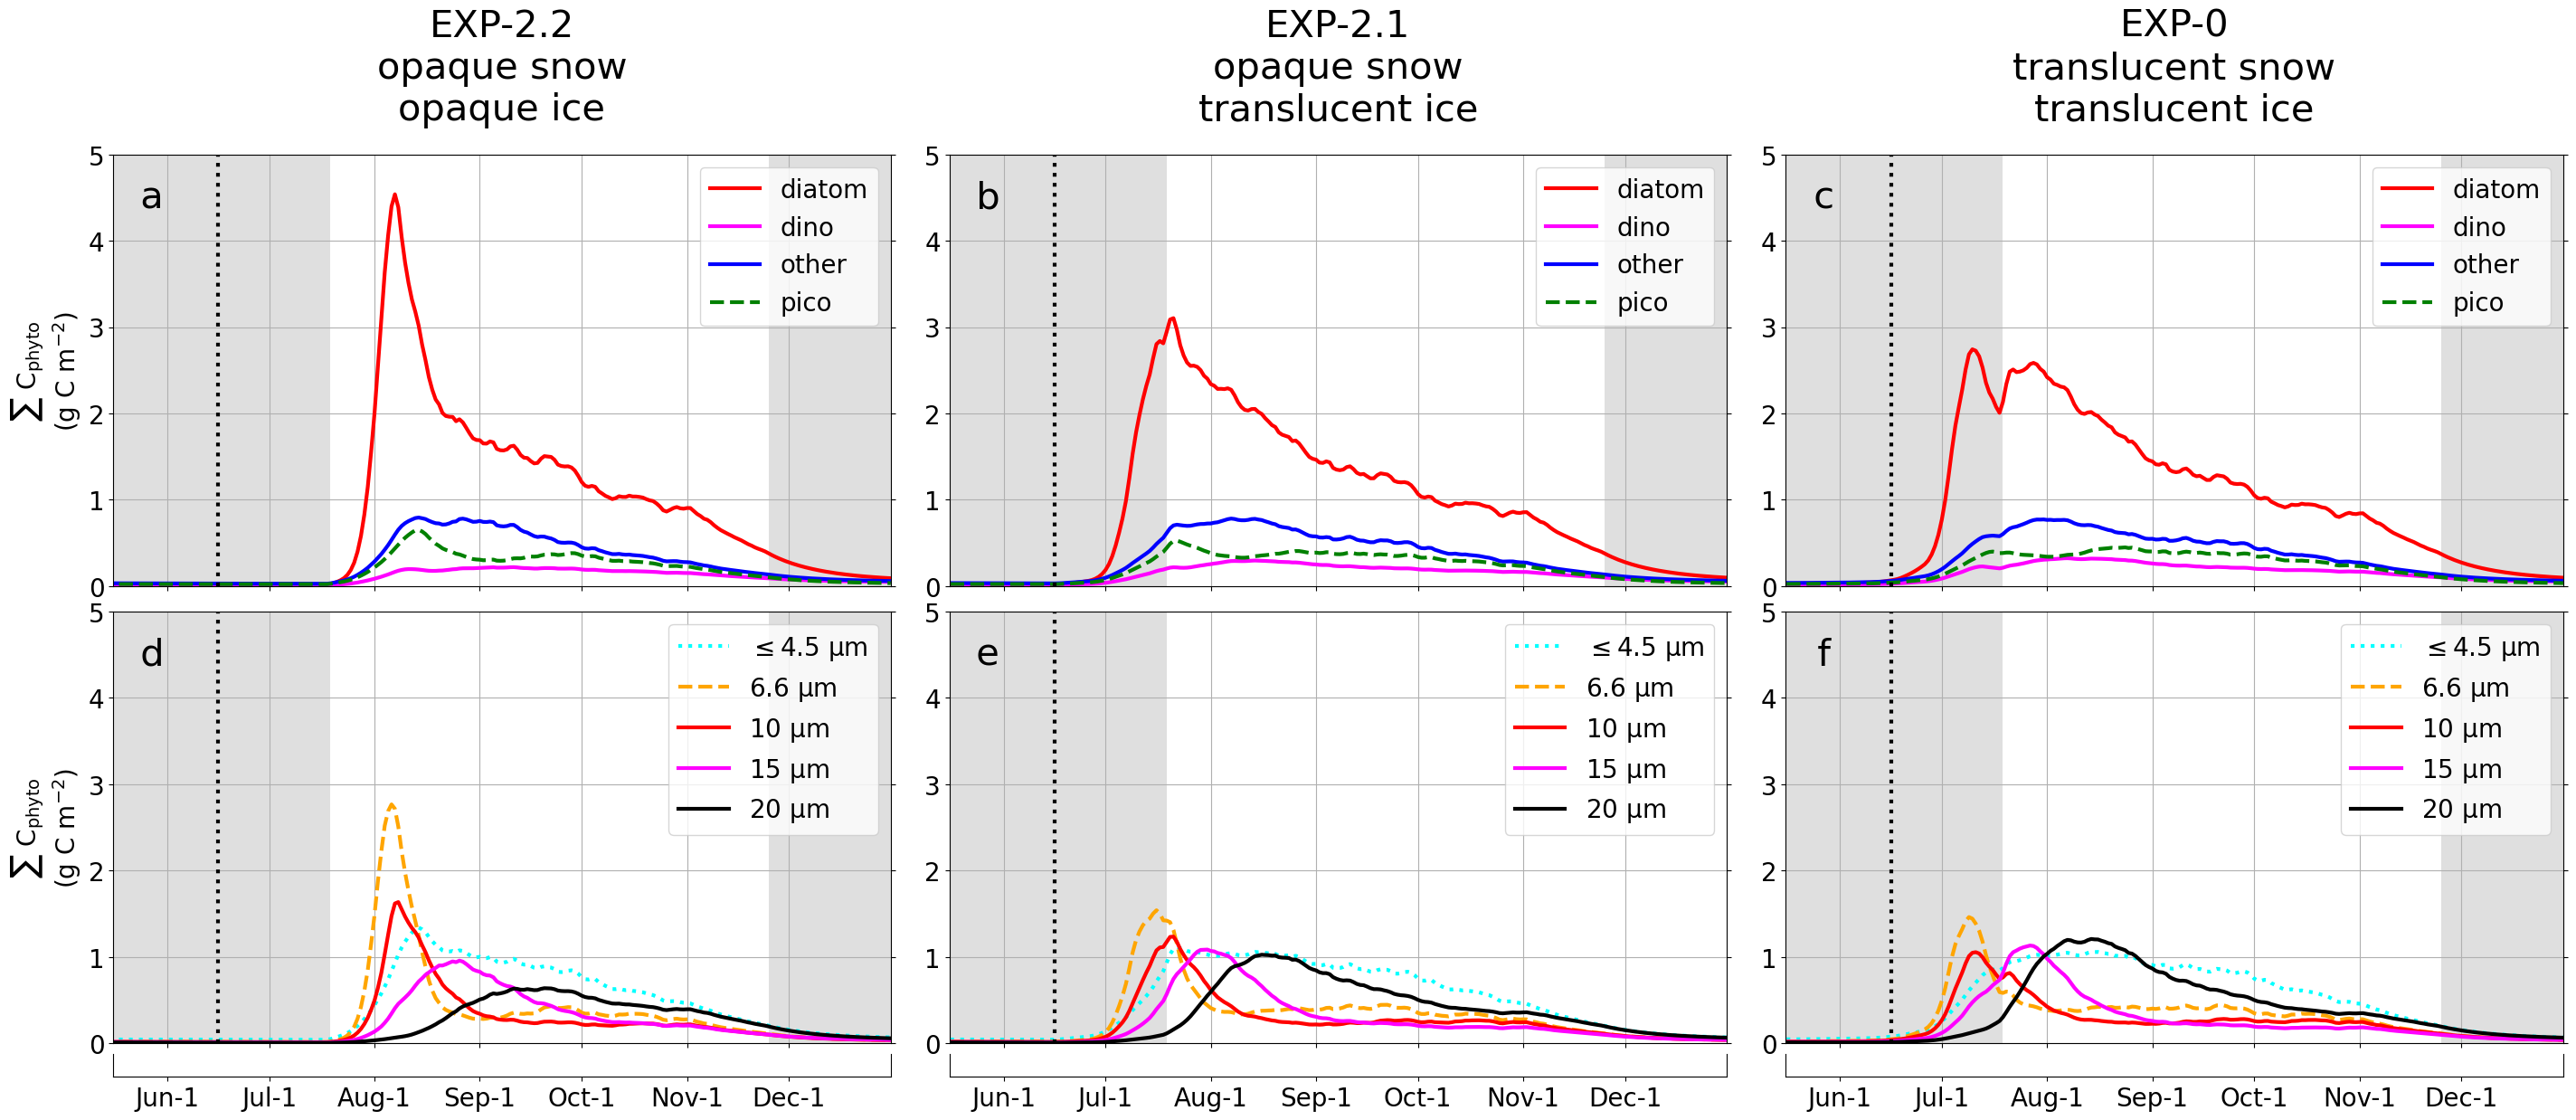

In [129]:
def make_plots(axs):
    box=dict(pad=5,alpha=0)
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')
    locs=np.array([151,
              181, 212, 243, 273, 304, 334])
    labels=('Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')
    xmin=135 # 15 May (0-based)
    xmax=364 # 31 December (0-based)
    xlims=(xmin,xmax)
    ymin=0
    ymax=5
    ylims=(ymin,ymax)
    
    # --- (A) EXP-2: SUM C_PHYTO: GROUPS:
    # ---     EXP-2.2, OPAQUE SNOW AND OPAQUE ICE
    ax=axs[0,0]
    h_biodiatoms_EXP2_2=ax.plot(
        first_year,
        array1d_iT_biodiatoms_EXP2_2,
        '-',color='red',label='diatom')
    h_biodino_EXP2_2=ax.plot(
        first_year,
        array1d_iT_biodino_EXP2_2,
        '-',color='magenta',label='dino')
    h_bioother_EXP2_2=ax.plot(
        first_year,
        array1d_iT_bioother_EXP2_2,
        '-',color='blue',label='other')
    h_biopico_EXP2_2=ax.plot(
        first_year,
        array1d_iT_biopico_EXP2_2,
        '--',color='green',label='pico')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('$\mathrm{ \sum\ C_{phyto} }$\n'
                  '($\mathrm{ g\ C\ m^{-2} }$)')
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(ylims)
    ax.grid()
    ax.legend(loc='upper right')
    plt.text(0.05,0.90,' a ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    plt.text(0.5,1.2,'EXP-2.2\nopaque snow\nopaque ice',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    ax.axvline(obs_nosnow,color='black',linestyle=':')
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup-xmin,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=xmax-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    
    # --- (B) EXP-2: SUM C_PHYTO: GROUPS:
    # ---     EXP-2.1, OPAQUE SNOW AND TRANSLUCENT ICE
    ax=axs[0,1]
    h_biodiatoms_EXP2_1=ax.plot(
        first_year,
        array1d_iT_biodiatoms_EXP2_1,
        '-',color='red',label='diatom')
    h_biodino_EXP2_1=ax.plot(
        first_year,
        array1d_iT_biodino_EXP2_1,
        '-',color='magenta',label='dino')
    h_bioother_EXP2_1=ax.plot(
        first_year,
        array1d_iT_bioother_EXP2_1,
        '-',color='blue',label='other')
    h_biopico_EXP2_1=ax.plot(
        first_year,
        array1d_iT_biopico_EXP2_1,
        '--',color='green',label='pico')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(ylims)
    ax.grid()
    ax.legend(loc='upper right')
    plt.text(0.05,0.90,' b ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    plt.text(0.5,1.2,'EXP-2.1\nopaque snow\ntranslucent ice',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    ax.axvline(obs_nosnow,color='black',linestyle=':')
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup-xmin,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=xmax-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    
    # --- (C) EXP-2: SUM C_PHYTO: GROUPS:
    # ---     EXP-0, TRANSLUCENT SNOW AND TRANSLUCENT ICE
    ax=axs[0,2]
    h_biodiatoms_EXP0=ax.plot(
        first_year,
        array1d_iT_biodiatoms_EXP0,
        '-',color='red',label='diatom')
    h_biodino_EXP0=ax.plot(
        first_year,
        array1d_iT_biodino_EXP0,
        '-',color='magenta',label='dino')
    h_bioother_EXP0=ax.plot(
        first_year,
        array1d_iT_bioother_EXP0,
        '-',color='blue',label='other')
    h_biopico_EXP0=ax.plot(
        first_year,
        array1d_iT_biopico_EXP0,
        '--',color='green',label='pico')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(ylims)
    ax.grid()
    ax.legend(loc='upper right')
    plt.text(0.05,0.90,' c ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    plt.text(0.5,1.2,'EXP-0\ntranslucent snow\ntranslucent ice',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    ax.axvline(obs_nosnow,color='black',linestyle=':')
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup-xmin,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=xmax-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    
    # --- (D) EXP-2: SUM C_PHYTO: SIZES:
    # ---     EXP-2.2, OPAQUE SNOW AND OPAQUE ICE
    ax=axs[1,0]
    h_biophytolte4_5_EXP2_2=ax.plot(
        first_year,
        array1d_iT_biophytolte4_5_EXP2_2,
        ':',color='cyan',label='$\mathrm{ \leq 4.5\ \mu m }$')
    h_biophyto6_6_EXP2_2=ax.plot(
        first_year,
        array1d_iT_biophyto6_6_EXP2_2,
        '--',color='orange',label='$\mathrm{ 6.6\ \mu m }$')
    h_biophyto10_EXP2_2=ax.plot(
        first_year,
        array1d_iT_biophyto10_EXP2_2,
        '-',color='red',label='$\mathrm{ 10\ \mu m }$')
    h_biophyto15_EXP2_2=ax.plot(
        first_year,
        array1d_iT_biophyto15_EXP2_2,
        '-',color='magenta',label='$\mathrm{ 15\ \mu m }$')
    h_biophytoge20_EXP2_2=ax.plot(
        first_year,
        array1d_iT_biophytoge20_EXP2_2,
        '-',color='black',label='$\mathrm{ 20\ \mu m }$')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('$\mathrm{ \sum\ C_{phyto} }$\n'
                  '($\mathrm{ g\ C\ m^{-2} }$)')
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(ylims)
    ax.grid()
    ax.legend(loc='upper right')
    plt.text(0.05,0.90,' d ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    ax.axvline(obs_nosnow,color='black',linestyle=':')
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup-xmin,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=xmax-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    
    # --- (E) EXP-2: SUM C_PHYTO: SIZES:
    # ---     EXP-2.1, OPAQUE SNOW AND TRANSLUCENT ICE
    ax=axs[1,1]
    h_biophytolte4_5_EXP2_1=ax.plot(
        first_year,
        array1d_iT_biophytolte4_5_EXP2_1,
        ':',color='cyan',label='$\mathrm{ \leq 4.5\ \mu m }$')
    h_biophyto6_6_EXP2_1=ax.plot(
        first_year,
        array1d_iT_biophyto6_6_EXP2_1,
        '--',color='orange',label='$\mathrm{ 6.6\ \mu m }$')
    h_biophyto10_EXP2_1=ax.plot(
        first_year,
        array1d_iT_biophyto10_EXP2_1,
        '-',color='red',label='$\mathrm{ 10\ \mu m }$')
    h_biophyto15_EXP2_1=ax.plot(
        first_year,
        array1d_iT_biophyto15_EXP2_1,
        '-',color='magenta',label='$\mathrm{ 15\ \mu m }$')
    h_biophytoge20_EXP2_1=ax.plot(
        first_year,
        array1d_iT_biophytoge20_EXP2_1,
        '-',color='black',label='$\mathrm{ 20\ \mu m }$')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(ylims)
    ax.grid()
    ax.legend(loc='upper right')
    plt.text(0.05,0.90,' e ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    ax.axvline(obs_nosnow,color='black',linestyle=':')
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup-xmin,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    
    # --- (F) EXP-2: SUM C_PHYTO: SIZES:
    # ---     EXP-0, TRANSLUCENT SNOW AND TRANSLUCENT ICE
    ax=axs[1,2]
    h_biophytolte4_5_EXP0=ax.plot(
        first_year,
        array1d_iT_biophytolte4_5_EXP0,
        ':',color='cyan',label='$\mathrm{ \leq 4.5\ \mu m }$')
    h_biophyto6_6_EXP0=ax.plot(
        first_year,
        array1d_iT_biophyto6_6_EXP0,
        '--',color='orange',label='$\mathrm{ 6.6\ \mu m }$')
    h_biophyto10_EXP0=ax.plot(
        first_year,
        array1d_iT_biophyto10_EXP0,
        '-',color='red',label='$\mathrm{ 10\ \mu m }$')
    h_biophyto15_EXP0=ax.plot(
        first_year,
        array1d_iT_biophyto15_EXP0,
        '-',color='magenta',label='$\mathrm{ 15\ \mu m }$')
    h_biophytoge20_EXP0=ax.plot(
        first_year,
        array1d_iT_biophytoge20_EXP0,
        '-',color='black',label='$\mathrm{ 20\ \mu m }$')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(ylims)
    ax.grid()
    ax.legend(loc='upper right')
    plt.text(0.05,0.90,' f ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    ax.axvline(obs_nosnow,color='black',linestyle=':')
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup-xmin,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=xmax-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    
    
    
    # --- ADDITIONAL X-AXIS
    ax=axs[2,0]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # --- ADDITIONAL X-AXIS
    ax=axs[2,1]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # --- ADDITIONAL X-AXIS
    ax=axs[2,2]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # --- POSITION
    axs[0,0].set_position([0.074,0.460, 0.292,0.372])
    axs[0,1].set_position([0.388,0.460, 0.292,0.372])
    axs[0,2].set_position([0.702,0.460, 0.292,0.372])
    axs[1,0].set_position([0.074,0.066, 0.292,0.372])
    axs[1,1].set_position([0.388,0.066, 0.292,0.372])
    axs[1,2].set_position([0.702,0.066, 0.292,0.372])
    axs[2,0].set_position([0.074,0.037, 0.292,0.020])
    axs[2,1].set_position([0.388,0.037, 0.292,0.020])
    axs[2,2].set_position([0.702,0.037, 0.292,0.020])

with plt.style.context('mplstyles/exp1_groups.mplstyle'):
    # --- PLOT
    fig,axs=plt.subplots(nrows=3,ncols=3,figsize=(29.445,12.825))
    make_plots(axs)
    fig.align_ylabels(axs[:])
    
    # --- SAVE
    outfile='figures_timing_sup_progress/sup_exp2_groups.'+ext
    plt.savefig(outfile,dpi=dpi)

**Figure \<sup_exp2_groups\>.**
**Sensitivity simulations by phytoplankton groups and size classes: EXP-2 with differing light under sea ice.**
**Left column:** EXP-2.2 with no light under snow-covered sea ice
and no light under bare sea ice.
**Middle column:** EXP-2.1 with no light under snow-covered sea ice
but light under bare sea ice.
**Right column:** EXP-0 with light under snow-covered sea ice
and under bare sea ice.
**First row:** Vertically integrated biomass for each functional group (0-100m).
pico: picophytoplankton.
other nano: other nanophytoplankton.
dino: mixotrophic dinoflagellate.
**Second row:** Vertically integrated biomass (0-100m) for different size classes or intervals of size classes.
The size classes were described with their equivalent spherical diameter (ESD).
Note that the interval of size classes <= 4.5 μm gathered together four size classes of the model and that the interval of size classes >= 20 μm gathered together eight size classes of the model.
The vertical dotted line is the date of the snow melt completion.
The grey rectangles represent the time of year before the sea ice
break-up and after the sea ice freeze-up.

# EXP-3

Differing pre-bloom nitrate.

## EXP-3: infiles

In [130]:
infile_car_EXP3_times0_50\
='data/DataS6_output_mitgcm/exp3_times0_50/car.0000000000.t001.nc'
infile_car_EXP3_times1_00\
='data/DataS6_output_mitgcm/exp3_times1_00/car.0000000000.t001.nc'
infile_car_EXP3_times2_00\
='data/DataS6_output_mitgcm/exp3_times2_00/car.0000000000.t001.nc'

## EXP-3: $\mathrm{ \sum C_{phyto} }$

$\mathrm{ \sum C_{phyto} }$ is the vertically integrated 
$\mathrm{ C_{phyto} }$ (0-100m)
in $\mathrm{ mg\ C\ m^{-2} }$.

In [131]:
depth_end=100 # m

### EXP-3: $\mathrm{ \sum C_{phyto} }$: groups

$\mathrm{ \sum C_{phyto} }$ for each phytoplankton group.

#### EXP-3: $\mathrm{ \sum C_{phyto} }$: groups: EXP-3, $\mathrm{ [NO_3]^{winter}*1/2 }$

In [132]:
array1d_iT_biodiatoms_EXP3_times0_50\
=read_mitgcm.get_array1d_iT_biodiatoms(
    infile=infile_car_EXP3_times0_50,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biodiatoms_EXP3_times0_50\
=array1d_iT_biodiatoms_EXP3_times0_50/1000 # mg C -> g C

array1d_iT_biodino_EXP3_times0_50\
=read_mitgcm.get_array1d_iT_biodino(
    infile=infile_car_EXP3_times0_50,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biodino_EXP3_times0_50\
=array1d_iT_biodino_EXP3_times0_50/1000 # mg C -> g C

array1d_iT_bioother_EXP3_times0_50\
=read_mitgcm.get_array1d_iT_bioother(
    infile=infile_car_EXP3_times0_50,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_bioother_EXP3_times0_50\
=array1d_iT_bioother_EXP3_times0_50/1000 # mg C -> g C

array1d_iT_biopico_EXP3_times0_50\
=read_mitgcm.get_array1d_iT_biopico(
    infile=infile_car_EXP3_times0_50,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biopico_EXP3_times0_50\
=array1d_iT_biopico_EXP3_times0_50/1000 # mg C -> g C

#### EXP-3: $\mathrm{ \sum C_{phyto} }$: groups: EXP-3, reference

In [133]:
array1d_iT_biodiatoms_EXP3_times1_00\
=read_mitgcm.get_array1d_iT_biodiatoms(
    infile=infile_car_EXP3_times1_00,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biodiatoms_EXP3_times1_00\
=array1d_iT_biodiatoms_EXP3_times1_00/1000 # mg C -> g C

array1d_iT_biodino_EXP3_times1_00\
=read_mitgcm.get_array1d_iT_biodino(
    infile=infile_car_EXP3_times1_00,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biodino_EXP3_times1_00\
=array1d_iT_biodino_EXP3_times1_00/1000 # mg C -> g C

array1d_iT_bioother_EXP3_times1_00\
=read_mitgcm.get_array1d_iT_bioother(
    infile=infile_car_EXP3_times1_00,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_bioother_EXP3_times1_00\
=array1d_iT_bioother_EXP3_times1_00/1000 # mg C -> g C

array1d_iT_biopico_EXP3_times1_00\
=read_mitgcm.get_array1d_iT_biopico(
    infile=infile_car_EXP3_times1_00,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biopico_EXP3_times1_00\
=array1d_iT_biopico_EXP3_times1_00/1000 # mg C -> g C

#### EXP-3: $\mathrm{ \sum C_{phyto} }$: groups: EXP-3, $\mathrm{ [NO_3]^{winter}*2 }$

In [134]:
array1d_iT_biodiatoms_EXP3_times2_00\
=read_mitgcm.get_array1d_iT_biodiatoms(
    infile=infile_car_EXP3_times2_00,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biodiatoms_EXP3_times2_00\
=array1d_iT_biodiatoms_EXP3_times2_00/1000 # mg C -> g C

array1d_iT_biodino_EXP3_times2_00\
=read_mitgcm.get_array1d_iT_biodino(
    infile=infile_car_EXP3_times2_00,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biodino_EXP3_times2_00\
=array1d_iT_biodino_EXP3_times2_00/1000 # mg C -> g C

array1d_iT_bioother_EXP3_times2_00\
=read_mitgcm.get_array1d_iT_bioother(
    infile=infile_car_EXP3_times2_00,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_bioother_EXP3_times2_00\
=array1d_iT_bioother_EXP3_times2_00/1000 # mg C -> g C

array1d_iT_biopico_EXP3_times2_00\
=read_mitgcm.get_array1d_iT_biopico(
    infile=infile_car_EXP3_times2_00,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biopico_EXP3_times2_00\
=array1d_iT_biopico_EXP3_times2_00/1000 # mg C -> g C

### EXP-3: $\mathrm{ \sum C_{phyto} }$: sizes

$\mathrm{ \sum C_{phyto} }$ for each size class.

#### EXP-3: $\mathrm{ \sum C_{phyto} }$: sizes: EXP-3, $\mathrm{ [NO_3]^{winter}*1/2 }$

In [135]:
array1d_iT_biophytolte4_5_EXP3_times0_50\
=read_mitgcm.get_array1d_iT_biophytolte4_5(
    infile=infile_car_EXP3_times0_50,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biophytolte4_5_EXP3_times0_50\
=array1d_iT_biophytolte4_5_EXP3_times0_50/1000 # mg C -> g C

array1d_iT_biophyto6_6_EXP3_times0_50\
=read_mitgcm.get_array1d_iT_biophyto6_6(
    infile=infile_car_EXP3_times0_50,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biophyto6_6_EXP3_times0_50\
=array1d_iT_biophyto6_6_EXP3_times0_50/1000 # mg C -> g C

array1d_iT_biophyto10_EXP3_times0_50\
=read_mitgcm.get_array1d_iT_biophyto10(
    infile=infile_car_EXP3_times0_50,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biophyto10_EXP3_times0_50\
=array1d_iT_biophyto10_EXP3_times0_50/1000 # mg C -> g C

array1d_iT_biophyto15_EXP3_times0_50\
=read_mitgcm.get_array1d_iT_biophyto15(
    infile=infile_car_EXP3_times0_50,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biophyto15_EXP3_times0_50\
=array1d_iT_biophyto15_EXP3_times0_50/1000 # mg C -> g C

array1d_iT_biophytoge20_EXP3_times0_50\
=read_mitgcm.get_array1d_iT_biophytoge20(
    infile=infile_car_EXP3_times0_50,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biophytoge20_EXP3_times0_50\
=array1d_iT_biophytoge20_EXP3_times0_50/1000 # mg C -> g C

#### EXP-3: $\mathrm{ \sum C_{phyto} }$: sizes: EXP-3, reference

In [136]:
array1d_iT_biophytolte4_5_EXP3_times1_00\
=read_mitgcm.get_array1d_iT_biophytolte4_5(
    infile=infile_car_EXP3_times1_00,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biophytolte4_5_EXP3_times1_00\
=array1d_iT_biophytolte4_5_EXP3_times1_00/1000 # mg C -> g C

array1d_iT_biophyto6_6_EXP3_times1_00\
=read_mitgcm.get_array1d_iT_biophyto6_6(
    infile=infile_car_EXP3_times1_00,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biophyto6_6_EXP3_times1_00\
=array1d_iT_biophyto6_6_EXP3_times1_00/1000 # mg C -> g C

array1d_iT_biophyto10_EXP3_times1_00\
=read_mitgcm.get_array1d_iT_biophyto10(
    infile=infile_car_EXP3_times1_00,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biophyto10_EXP3_times1_00\
=array1d_iT_biophyto10_EXP3_times1_00/1000 # mg C -> g C

array1d_iT_biophyto15_EXP3_times1_00\
=read_mitgcm.get_array1d_iT_biophyto15(
    infile=infile_car_EXP3_times1_00,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biophyto15_EXP3_times1_00\
=array1d_iT_biophyto15_EXP3_times1_00/1000 # mg C -> g C

array1d_iT_biophytoge20_EXP3_times1_00\
=read_mitgcm.get_array1d_iT_biophytoge20(
    infile=infile_car_EXP3_times1_00,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biophytoge20_EXP3_times1_00\
=array1d_iT_biophytoge20_EXP3_times1_00/1000 # mg C -> g C

#### EXP-3: $\mathrm{ \sum C_{phyto} }$: sizes: EXP-3, $\mathrm{ [NO_3]^{winter}*2 }$

In [137]:
array1d_iT_biophytolte4_5_EXP3_times2_00\
=read_mitgcm.get_array1d_iT_biophytolte4_5(
    infile=infile_car_EXP3_times2_00,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biophytolte4_5_EXP3_times2_00\
=array1d_iT_biophytolte4_5_EXP3_times2_00/1000 # mg C -> g C

array1d_iT_biophyto6_6_EXP3_times2_00\
=read_mitgcm.get_array1d_iT_biophyto6_6(
    infile=infile_car_EXP3_times2_00,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biophyto6_6_EXP3_times2_00\
=array1d_iT_biophyto6_6_EXP3_times2_00/1000 # mg C -> g C

array1d_iT_biophyto10_EXP3_times2_00\
=read_mitgcm.get_array1d_iT_biophyto10(
    infile=infile_car_EXP3_times2_00,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biophyto10_EXP3_times2_00\
=array1d_iT_biophyto10_EXP3_times2_00/1000 # mg C -> g C

array1d_iT_biophyto15_EXP3_times2_00\
=read_mitgcm.get_array1d_iT_biophyto15(
    infile=infile_car_EXP3_times2_00,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biophyto15_EXP3_times2_00\
=array1d_iT_biophyto15_EXP3_times2_00/1000 # mg C -> g C

array1d_iT_biophytoge20_EXP3_times2_00\
=read_mitgcm.get_array1d_iT_biophytoge20(
    infile=infile_car_EXP3_times2_00,
    array1d_iT1y_iT=array1d_iT1y_iT,
    array1d_idepth_delR=drF,
    depth_end=depth_end
)
array1d_iT_biophytoge20_EXP3_times2_00\
=array1d_iT_biophytoge20_EXP3_times2_00/1000 # mg C -> g C

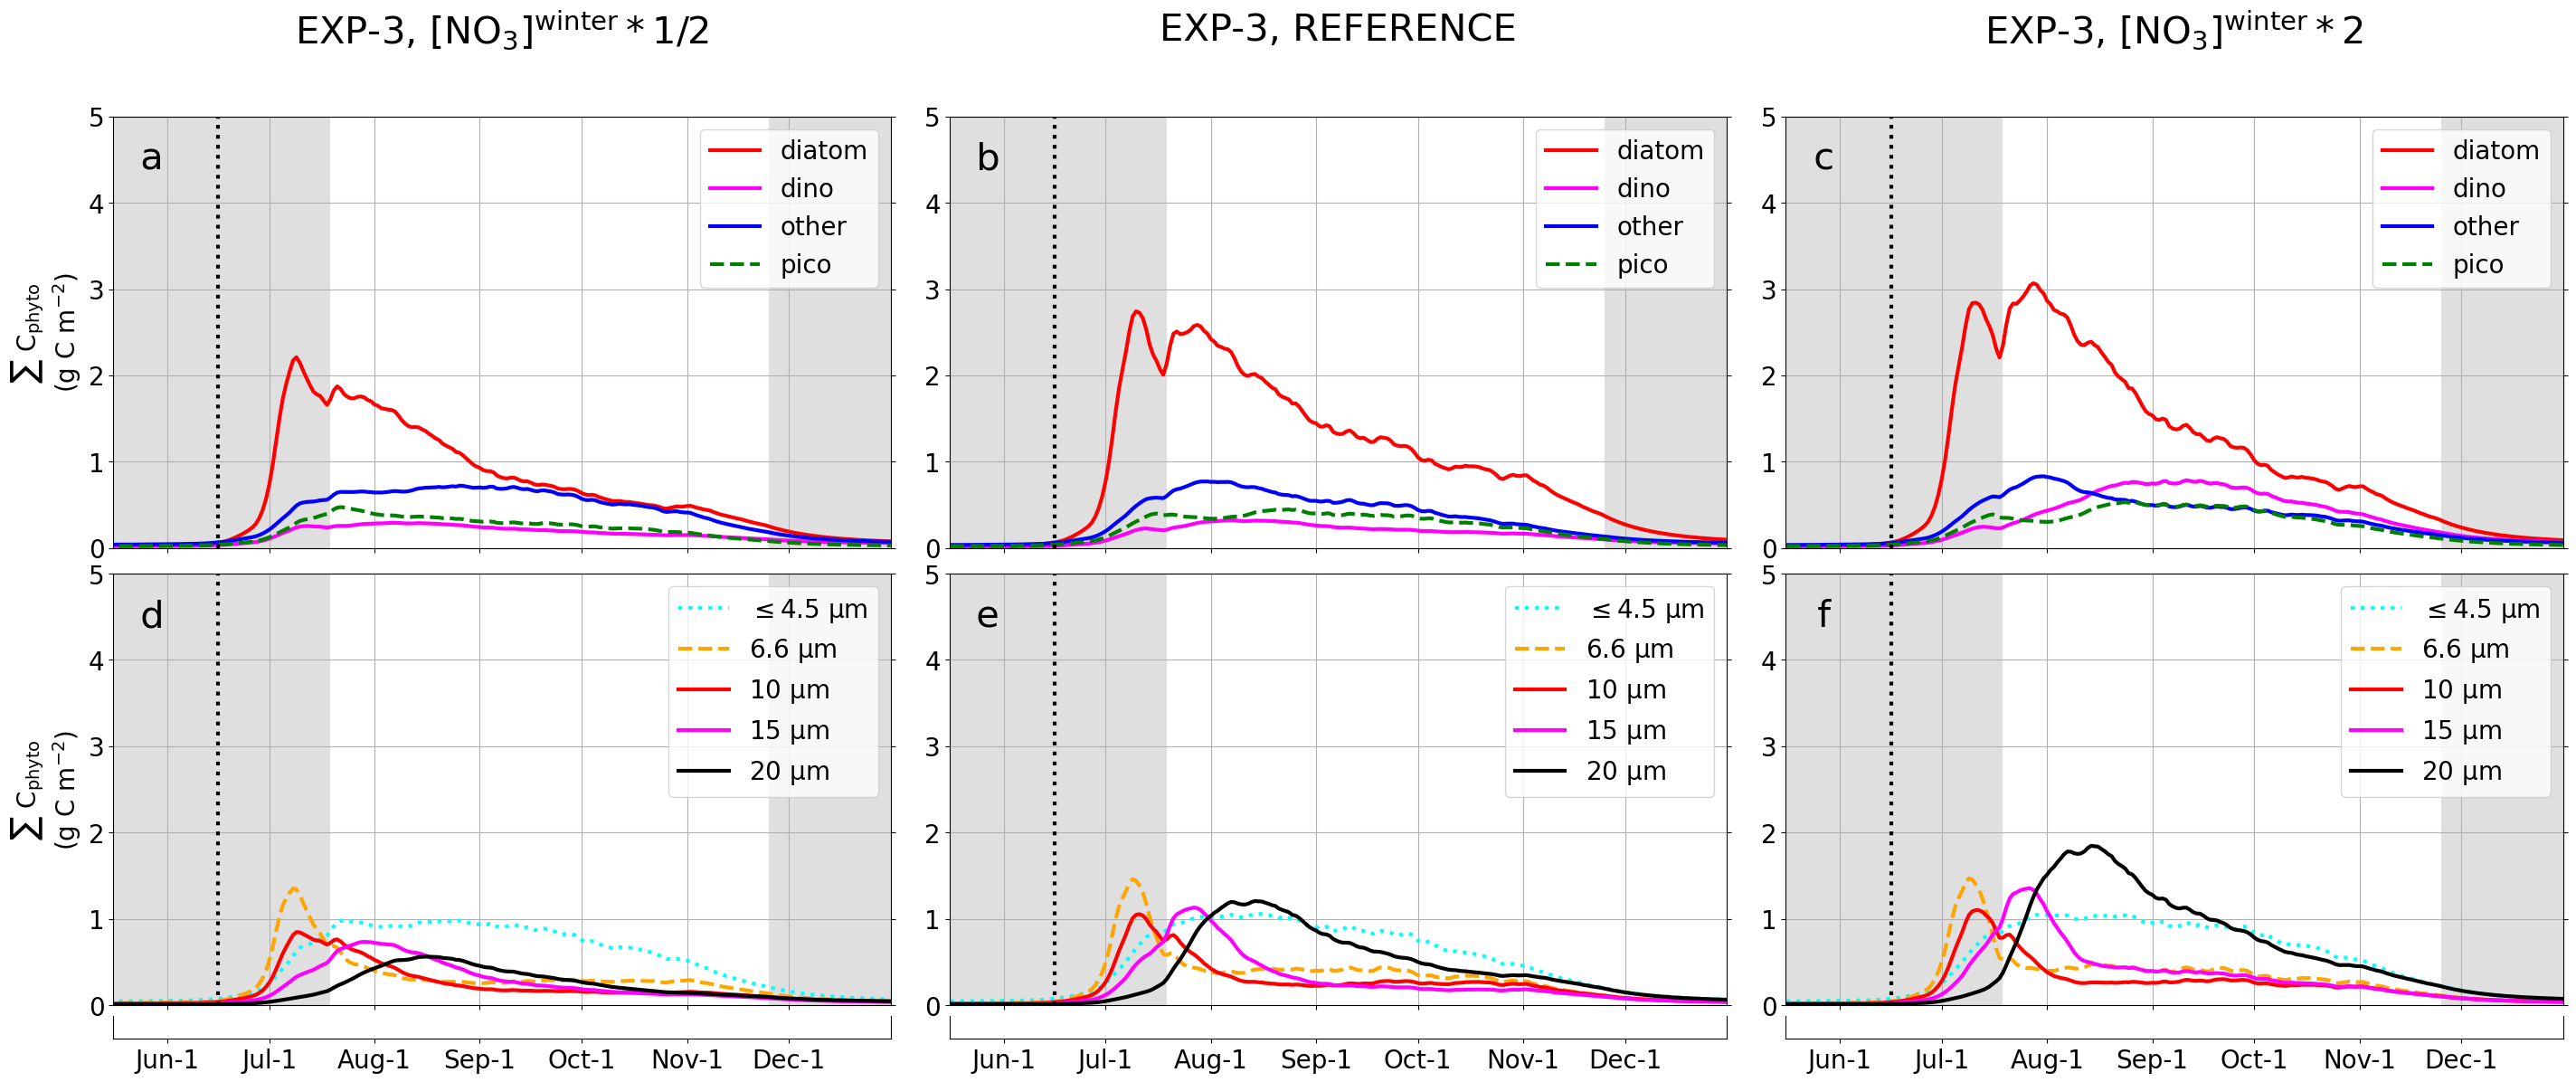

In [138]:
def make_plots(axs):
    box=dict(pad=5,alpha=0)
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')
    locs=np.array([151,
              181, 212, 243, 273, 304, 334])
    labels=('Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')
    xmin=135 # 15 May (0-based)
    xmax=364 # 31 December (0-based)
    xlims=(xmin,xmax)
    ymin=0
    ymax=5
    ylims=(ymin,ymax)
    
    # --- (A) EXP-3: SUM C_PHYTO: GROUPS:
    # ---     EXP-3, [NO_3]^WINTER*1/2
    ax=axs[0,0]
    h_biodiatoms_EXP3_times0_50=ax.plot(
        first_year,
        array1d_iT_biodiatoms_EXP3_times0_50,
        '-',color='red',label='diatom')
    h_biodino_EXP3_times0_50=ax.plot(
        first_year,
        array1d_iT_biodino_EXP3_times0_50,
        '-',color='magenta',label='dino')
    h_bioother_EXP3_times0_50=ax.plot(
        first_year,
        array1d_iT_bioother_EXP3_times0_50,
        '-',color='blue',label='other')
    h_biopico_EXP3_times0_50=ax.plot(
        first_year,
        array1d_iT_biopico_EXP3_times0_50,
        '--',color='green',label='pico')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('$\mathrm{ \sum\ C_{phyto} }$\n'
                  '($\mathrm{ g\ C\ m^{-2} }$)')
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(ylims)
    ax.grid()
    ax.legend(loc='upper right')
    plt.text(0.05,0.90,' a ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    plt.text(0.5,1.2,'EXP-3, $\mathrm{ [NO_3]^{winter}*1/2 }$',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    ax.axvline(obs_nosnow,color='black',linestyle=':')
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup-xmin,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=xmax-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    
    # --- (B) EXP-3: SUM C_PHYTO: GROUPS:
    # ---     EXP-3, REFERENCE
    ax=axs[0,1]
    h_biodiatoms_EXP3_times1_00=ax.plot(
        first_year,
        array1d_iT_biodiatoms_EXP3_times1_00,
        '-',color='red',label='diatom')
    h_biodino_EXP3_times1_00=ax.plot(
        first_year,
        array1d_iT_biodino_EXP3_times1_00,
        '-',color='magenta',label='dino')
    h_bioother_EXP3_times1_00=ax.plot(
        first_year,
        array1d_iT_bioother_EXP3_times1_00,
        '-',color='blue',label='other')
    h_biopico_EXP3_times1_00=ax.plot(
        first_year,
        array1d_iT_biopico_EXP3_times1_00,
        '--',color='green',label='pico')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(ylims)
    ax.grid()
    ax.legend(loc='upper right')
    plt.text(0.05,0.90,' b ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    plt.text(0.5,1.2,'EXP-3, REFERENCE',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    ax.axvline(obs_nosnow,color='black',linestyle=':')
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup-xmin,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=xmax-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    
    # --- (C) EXP-3: SUM C_PHYTO: GROUPS:
    # ---     EXP-3, [NO_3]^WINTER*2
    ax=axs[0,2]
    h_biodiatoms_EXP3_times2_00=ax.plot(
        first_year,
        array1d_iT_biodiatoms_EXP3_times2_00,
        '-',color='red',label='diatom')
    h_biodino_EXP3_times2_00=ax.plot(
        first_year,
        array1d_iT_biodino_EXP3_times2_00,
        '-',color='magenta',label='dino')
    h_bioother_EXP3_times2_00=ax.plot(
        first_year,
        array1d_iT_bioother_EXP3_times2_00,
        '-',color='blue',label='other')
    h_biopico_EXP3_times2_00=ax.plot(
        first_year,
        array1d_iT_biopico_EXP3_times2_00,
        '--',color='green',label='pico')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(ylims)
    ax.grid()
    ax.legend(loc='upper right')
    plt.text(0.05,0.90,' c ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    plt.text(0.5,1.2,'EXP-3, $\mathrm{ [NO_3]^{winter}*2 }$',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    ax.axvline(obs_nosnow,color='black',linestyle=':')
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup-xmin,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=xmax-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    
    # --- (D) EXP-3: SUM C_PHYTO: SIZES:
    # ---     EXP-3, [NO_3]^WINTER*1/2
    ax=axs[1,0]
    h_biophytolte4_5_EXP3_times0_50=ax.plot(
        first_year,
        array1d_iT_biophytolte4_5_EXP3_times0_50,
        ':',color='cyan',label='$\mathrm{ \leq 4.5\ \mu m }$')
    h_biophyto6_6_EXP3_times0_50=ax.plot(
        first_year,
        array1d_iT_biophyto6_6_EXP3_times0_50,
        '--',color='orange',label='$\mathrm{ 6.6\ \mu m }$')
    h_biophyto10_EXP3_times0_50=ax.plot(
        first_year,
        array1d_iT_biophyto10_EXP3_times0_50,
        '-',color='red',label='$\mathrm{ 10\ \mu m }$')
    h_biophyto15_EXP3_times0_50=ax.plot(
        first_year,
        array1d_iT_biophyto15_EXP3_times0_50,
        '-',color='magenta',label='$\mathrm{ 15\ \mu m }$')
    h_biophytoge20_EXP3_times0_50=ax.plot(
        first_year,
        array1d_iT_biophytoge20_EXP3_times0_50,
        '-',color='black',label='$\mathrm{ 20\ \mu m }$')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylabel('$\mathrm{ \sum\ C_{phyto} }$\n'
                  '($\mathrm{ g\ C\ m^{-2} }$)')
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(ylims)
    ax.grid()
    ax.legend(loc='upper right')
    plt.text(0.05,0.90,' d ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    ax.axvline(obs_nosnow,color='black',linestyle=':')
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup-xmin,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=xmax-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    
    # --- (E) EXP-3: SUM C_PHYTO: SIZES:
    # ---     EXP-3, REFERENCE
    ax=axs[1,1]
    h_biophytolte4_5_EXP3_times1_00=ax.plot(
        first_year,
        array1d_iT_biophytolte4_5_EXP3_times1_00,
        ':',color='cyan',label='$\mathrm{ \leq 4.5\ \mu m }$')
    h_biophyto6_6_EXP3_times1_00=ax.plot(
        first_year,
        array1d_iT_biophyto6_6_EXP3_times1_00,
        '--',color='orange',label='$\mathrm{ 6.6\ \mu m }$')
    h_biophyto10_EXP3_times1_00=ax.plot(
        first_year,
        array1d_iT_biophyto10_EXP3_times1_00,
        '-',color='red',label='$\mathrm{ 10\ \mu m }$')
    h_biophyto15_EXP3_times1_00=ax.plot(
        first_year,
        array1d_iT_biophyto15_EXP3_times1_00,
        '-',color='magenta',label='$\mathrm{ 15\ \mu m }$')
    h_biophytoge20_EXP3_times1_00=ax.plot(
        first_year,
        array1d_iT_biophytoge20_EXP3_times1_00,
        '-',color='black',label='$\mathrm{ 20\ \mu m }$')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(ylims)
    ax.grid()
    ax.legend(loc='upper right')
    plt.text(0.05,0.90,' e ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    ax.axvline(obs_nosnow,color='black',linestyle=':')
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup-xmin,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    
    # --- (F) EXP-3: SUM C_PHYTO: SIZES:
    # ---     EXP-3, [NO_3]^WINTER*2
    ax=axs[1,2]
    h_biophytolte4_5_EXP3_times2_00=ax.plot(
        first_year,
        array1d_iT_biophytolte4_5_EXP3_times2_00,
        ':',color='cyan',label='$\mathrm{ \leq 4.5\ \mu m }$')
    h_biophyto6_6_EXP3_times2_00=ax.plot(
        first_year,
        array1d_iT_biophyto6_6_EXP3_times2_00,
        '--',color='orange',label='$\mathrm{ 6.6\ \mu m }$')
    h_biophyto10_EXP3_times2_00=ax.plot(
        first_year,
        array1d_iT_biophyto10_EXP3_times2_00,
        '-',color='red',label='$\mathrm{ 10\ \mu m }$')
    h_biophyto15_EXP3_times2_00=ax.plot(
        first_year,
        array1d_iT_biophyto15_EXP3_times2_00,
        '-',color='magenta',label='$\mathrm{ 15\ \mu m }$')
    h_biophytoge20_EXP3_times2_00=ax.plot(
        first_year,
        array1d_iT_biophytoge20_EXP3_times2_00,
        '-',color='black',label='$\mathrm{ 20\ \mu m }$')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.yaxis.set_ticks_position('both')
    ax.set_ylim(ylims)
    ax.grid()
    ax.legend(loc='upper right')
    plt.text(0.05,0.90,' f ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    ax.axvline(obs_nosnow,color='black',linestyle=':')
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup-xmin,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=xmax-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25)
    ax.add_patch(rect)
    
    # --- ADDITIONAL X-AXIS
    ax=axs[2,0]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # --- ADDITIONAL X-AXIS
    ax=axs[2,1]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # --- ADDITIONAL X-AXIS
    ax=axs[2,2]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # --- POSITION
    axs[0,0].set_position([0.074,0.460, 0.292,0.372])
    axs[0,1].set_position([0.388,0.460, 0.292,0.372])
    axs[0,2].set_position([0.702,0.460, 0.292,0.372])
    axs[1,0].set_position([0.074,0.066, 0.292,0.372])
    axs[1,1].set_position([0.388,0.066, 0.292,0.372])
    axs[1,2].set_position([0.702,0.066, 0.292,0.372])
    axs[2,0].set_position([0.074,0.037, 0.292,0.020])
    axs[2,1].set_position([0.388,0.037, 0.292,0.020])
    axs[2,2].set_position([0.702,0.037, 0.292,0.020])

with plt.style.context('mplstyles/exp1_groups.mplstyle'):
    # --- PLOT
    fig,axs=plt.subplots(nrows=3,ncols=3,figsize=(29.445,12.825))
    make_plots(axs)
    fig.align_ylabels(axs[:])
    
    # --- SAVE
    outfile='figures_timing_sup_progress/sup_exp3_groups.'+ext
    plt.savefig(outfile,dpi=dpi)

**Figure \<sup_exp3_groups\>.**
**Sensitivity simulations by phytoplankton groups and size classes: EXP-3 prescribed pre-bloom nitrate concentrations.**
The nitrate concentrations before the bloom initiation
($\mathrm{ [NO_3]^{winter} }$)
were prescribed at 1/2 and 2 times that in the reference simulation.
**First row:** Vertically integrated biomass for each functional group (0-100m).
pico: picophytoplankton.
other nano: other nanophytoplankton.
dino: mixotrophic dinoflagellate.
**Second row:** Vertically integrated biomass (0-100m) for different size classes or intervals of size classes.
The size classes were described with their equivalent spherical diameter (ESD).
Note that the interval of size classes <= 4.5 μm gathered together four size classes of the model and that the interval of size classes >= 20 μm gathered together eight size classes of the model.
The vertical dotted line is the date of the snow melt completion.
The grey rectangles represent the time of year before the sea ice
break-up and after the sea ice freeze-up.

# Maps

Reference: https://github.com/poplarShift/ice-edge/blob/master/iceedge_analysis.ipynb.

## Maps: Function

In [139]:
'''latlon2xy convenience function to convert latlon to chosen projection,
and figure object'''
def latlon2xy(lon,lat,proj):
    xyz = proj.transform_points(ccrs.PlateCarree(),lon,lat).squeeze()
    x,y,_ = np.split(xyz,3,axis=len(xyz.shape)-1)
    x[np.isinf(x)]=np.nan
    y[np.isinf(y)]=np.nan
    return x.squeeze(),y.squeeze()

## Maps: stations

In [140]:
# STATIONS
Station=collections.namedtuple(
    'Station',
    'lon lat marker  markeredgecolor markerfacecolor markersize')
# Stations for the map of CCGS Amundsen 2018, leg 2b
station1=Station(-60.3919999999999,68.3096,'o','none','red',10)
station2=Station(-61.463,68.0358,'o','none','red',10)
station3=Station(-62.355,67.8668,'o','none','red',10)
station4=Station(-63.5639999999999,67.54,'o','none','red',10)
# Qikiqtarjuaq SIC
station5=Station(-63.783,67.482,'*','black','yellow',30)
station6=Station(-64.638,67.239,'o','none','red',10)
stations_am=[station1,station2,station3,station4,station5,station6]
# Stations for the map of Baffin Bay
station1=Station(station1.lon,station1.lat,station1.marker,
                 station1.markeredgecolor,station1.markerfacecolor,5)
station2=Station(station2.lon,station2.lat,station2.marker,
                 station2.markeredgecolor,station2.markerfacecolor,5)
station3=Station(station3.lon,station3.lat,station3.marker,
                 station3.markeredgecolor,station3.markerfacecolor,5)
station4=Station(station4.lon,station4.lat,station4.marker,
                 station4.markeredgecolor,station4.markerfacecolor,5)
# Qikiqtarjuaq SIC
station5=Station(station5.lon,station5.lat,station5.marker,
                 station5.markeredgecolor,station5.markerfacecolor,10)
station6=Station(station6.lon,station6.lat,station6.marker,
                 station6.markeredgecolor,station6.markerfacecolor,5)
stations_bb=[station1,station2,station3,station4,station5,station6]

## Maps: Plot

/var/folders/vq/5y09539n705gpb79d6ysx09r0000gr/T/ipykernel_19767/1440760513.py:57: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

/Users/maximebenoit-gagne/anaconda3/envs/timing/lib/python3.8/site-packages/shapely/constructive.py:181: RuntimeWarning:

invalid value encountered in buffer

/Users/maximebenoit-gagne/anaconda3/envs/timing/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning:

invalid value encountered in intersects

/Users/maximebenoit-gagne/anaconda3/envs/timing/lib/python3.8/site-packages/shapely/constructive.py:181: RuntimeWarning:

invalid value encountered in buffer

/Users/maximebenoit-gagne/anaconda3/envs/timing/lib/python3.8/site-packages/shapely/predicates.py:798: RuntimeWarning:

invalid value encountered in intersects

/Users/maximebenoit-gagne/anaconda3/envs/timing/lib/python

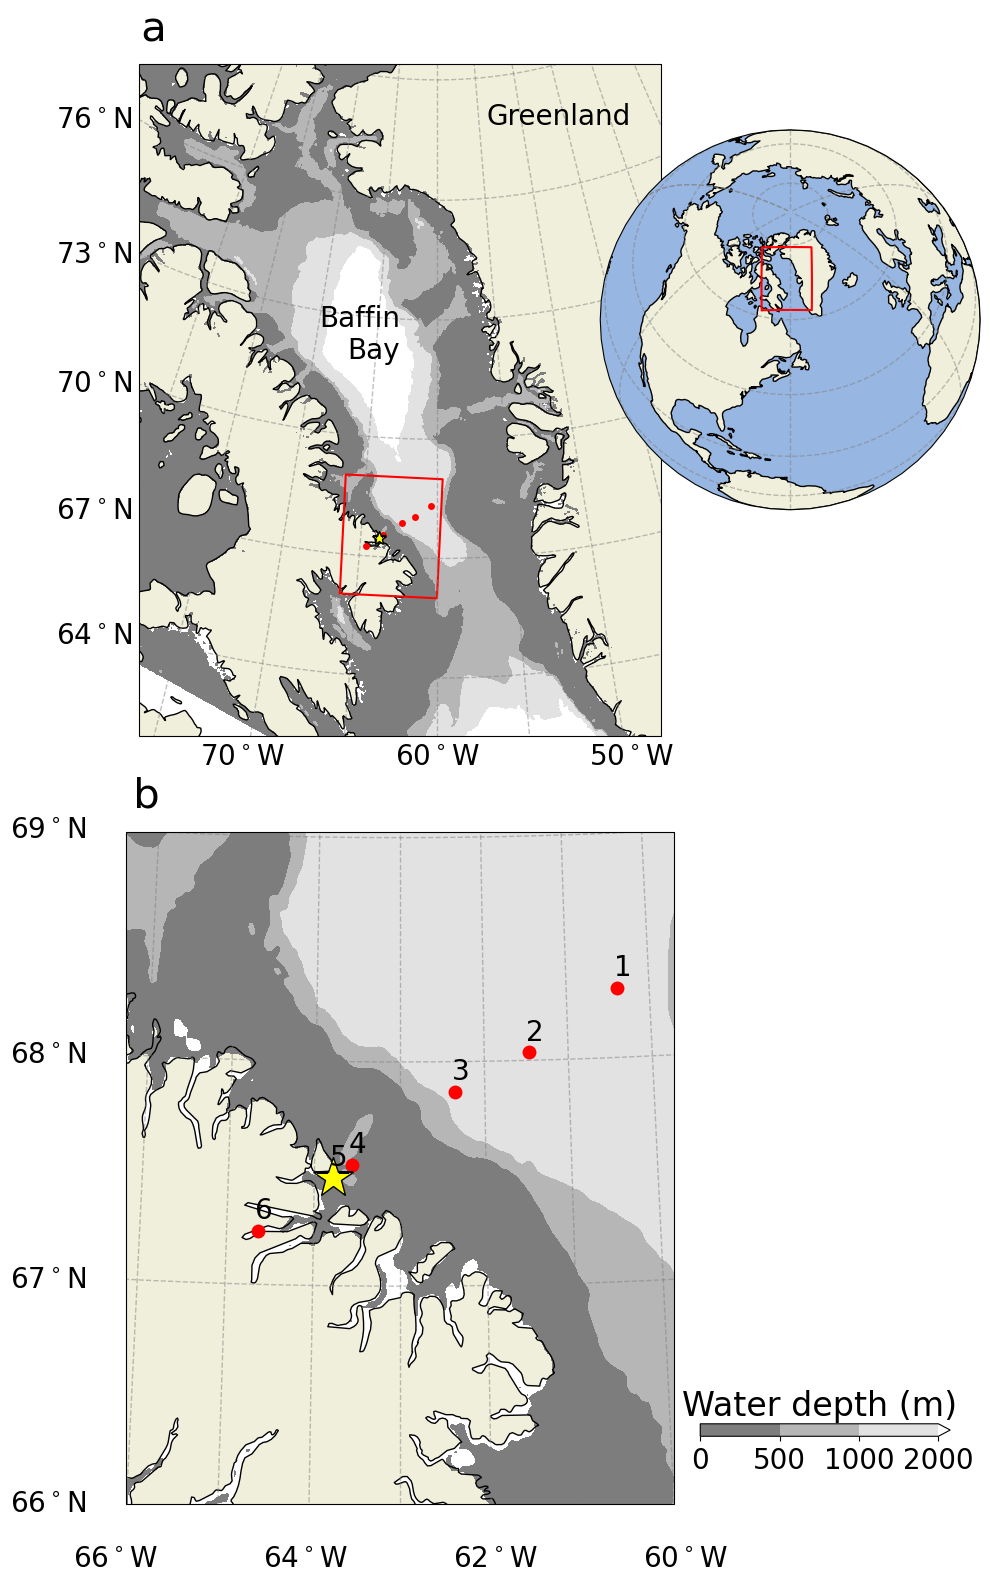

In [141]:
plotbathymetry=True
with plt.style.context('mplstyles/maps.mplstyle'):
    fig=plt.figure(figsize=(10, 16))
    
    # --- CCGS AMUNDSEN 2018, LEG 2B
    proj_am=ccrs.LambertConformal(central_longitude=-63,
                                  central_latitude=67.5,
                                  standard_parallels=(67,68))
    ax_am=fig.add_subplot(223,projection = proj_am)
    ax_am.coastlines(resolution='10m')
    ax_am.add_feature(cartopy.feature.LAND)
    if not plotbathymetry:
        ax_am.add_feature(cartopy.feature.OCEAN)
    MapExtent = [-66,-60,66,69]
    ax_am.set_extent(MapExtent, ccrs.PlateCarree())
    gl = ax_am.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                         linewidth=1, color='gray', alpha=0.5,
                         linestyle='--')
    gl.xlocator = mticker.FixedLocator(np.arange(-68,-58))
    gl.ylocator = mticker.FixedLocator(np.arange(65,70))

    # stations
    for station in stations_am:
        xstation,ystation = latlon2xy(np.array([station.lon]),
                                      np.array([station.lat]),
                                      proj_am)
        marker=station.marker
        markerfacecolor=station.markerfacecolor
        markersize=station.markersize
        markeredgecolor=station.markeredgecolor
        ax_am.plot(xstation,ystation,marker,markeredgecolor=markeredgecolor,
                   markerfacecolor=markerfacecolor,markersize=markersize)
        
    # longitude labels
    y0,_ = ax_am.get_ylim()
    for lon in [-66,-64,-62,-60]:
        x0,_ = proj_am.transform_point(lon,MapExtent[2]-1,
                                       src_crs = ccrs.PlateCarree())
        plt.text(x0,y0-2e4,'{:2d}$^\circ$W'.format(-lon),
                 horizontalalignment = 'center',verticalalignment='top')

    # latitude labels
    x0,_ = ax_am.get_xlim()
    someLons = np.arange(-80,-50)
    for lat in np.arange(66,69+1):
        # interpolate latitude circle to map boundary
        xyzArray = proj_am.transform_points(ccrs.PlateCarree(),
                                            someLons,lat*np.ones_like(someLons))
        x = xyzArray[:,0]
        y = xyzArray[:,1]
        y0 = np.interp(x0,x,y)
        plt.text(x0-2e4,y0,'{:2d}$^\circ$N'.format(lat),
                 horizontalalignment = 'right',verticalalignment='center')
    
    if plotbathymetry:
        # color bar for bathymetry
        cmap = plt.cm.get_cmap('Greys')
        cmap = cmap.from_list('Custom cmap',
                              [cmap(i) for i in range(150,50,-1)], 100)
        cmap.set_over('white')
        bounds = [0,500,1000,2000]
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    # IBCAO bathymetry
    if plotbathymetry:
        top = scipy.io.loadmat('data/DataS1_observations_IBCAO_1min_bathy.mat')
        lon_ibcao,lat_ibcao=np.meshgrid(top['x'],top['y'])
        z_ibcao=-top['IBCAO_1min']
        hb_am=ax_am.contourf(*latlon2xy(lon_ibcao,lat_ibcao,proj_am),
                             z_ibcao,levels=[0,500,1000,2000],
                             cmap=cmap,norm=norm,extend='max')
        axcb_am= fig.colorbar(hb_am,ax=ax_am,orientation='horizontal')
        axcb_am.ax.set_title('Water depth (m)')
        axcb_am.ax.set_position([0.70,-0.10, 0.25,0.20])
    
    # labels for stations
    for i,station in enumerate(stations_am):
        xstation,ystation = latlon2xy(np.array([station.lon]),
                                      np.array([station.lat]),
                                      proj_am)
        ax_am.text(xstation+3e3,ystation+1e4,i+1,
                   horizontalalignment = 'center',
                   verticalalignment='center')
    # text
    b_lon,b_lat = -66.5, 69.1,
    ax_am.text(b_lon,b_lat,' b ',
               horizontalalignment = 'left',fontsize=30,
               transform=ccrs.PlateCarree())
    
    # --- BAFFIN BAY
    proj_bb=ccrs.LambertConformal(central_longitude=-60,
                                  central_latitude=70,
                                  standard_parallels=(65,75))
    ax_bb=fig.add_subplot(221,projection=proj_bb)
    ax_bb.coastlines(resolution='50m')
    ax_bb.add_feature(cartopy.feature.LAND)
    if not plotbathymetry:
        ax_bb.add_feature(cartopy.feature.OCEAN)
    MapExtent = [-76,-48,62,79]
    ax_bb.set_extent(MapExtent, ccrs.PlateCarree())
    gl = ax_bb.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                         linewidth=1, color='gray', alpha=0.5,
                         linestyle='--')
    gl.xlocator = mticker.FixedLocator([-80,-75,-70,-65,-60,
                                        -55,-50,-45,-40,-35])
    gl.ylocator = mticker.FixedLocator(np.arange(58,84,3))

    # stations
    for station in stations_bb:
        xstation,ystation = latlon2xy(np.array([station.lon]),
                                      np.array([station.lat]),
                                      proj_bb)
        marker=station.marker
        markerfacecolor=station.markerfacecolor
        markersize=station.markersize
        markeredgecolor=station.markeredgecolor
        ax_bb.plot(xstation,ystation,marker,markeredgecolor=markeredgecolor,
                   markerfacecolor=markerfacecolor,markersize=markersize)

    # longitude labels
    y0,_ = ax_bb.get_ylim()
    for lon in [-70,-60,-50]:
        x0,_ = proj_bb.transform_point(lon,MapExtent[2]-1,
                                       src_crs = ccrs.PlateCarree())
        plt.text(x0,y0-2e4,'{:2d}$^\circ$W'.format(-lon),
                 horizontalalignment = 'center',verticalalignment='top',
                fontsize=20)

    # latitude labels
    x0,_ = ax_bb.get_xlim()
    someLons = np.arange(-120,-40,1)
    for lat in np.arange(64,78,3):
        # interpolate latitude circle to map boundary
        xyzArray = proj_bb.transform_points(ccrs.PlateCarree(),
                                            someLons,lat*np.ones_like(someLons))
        x = xyzArray[:,0]
        y = xyzArray[:,1]
        y0 = np.interp(x0,x,y)
        plt.text(x0-2e4,y0,'{:2d}$^\circ$N'.format(lat),
                 horizontalalignment = 'right',verticalalignment='center')
    
    # IBCAO bathymetry
    if plotbathymetry:
        hb_bb=ax_bb.contourf(*latlon2xy(lon_ibcao,lat_ibcao,proj_bb),
                             z_ibcao,levels=[0,500,1000,2000],
                             cmap=cmap,norm=norm,extend='max')

    # text
    a_lon,a_lat = -98, 77.5
    ax_bb.text(a_lon,a_lat,' a ',
               horizontalalignment = 'left',fontsize=30,
               transform=ccrs.PlateCarree())
    greenland_lon,greenland_lat = -38, 77
    ax_bb.text(greenland_lon,greenland_lat,'Greenland',
               horizontalalignment = 'right',
               transform=ccrs.PlateCarree())
    baffinbay_lon,baffinbay_lat = -63, 72
    ax_bb.text(baffinbay_lon,baffinbay_lat,'Baffin\nBay',
               horizontalalignment = 'right',
               transform=ccrs.PlateCarree())

    # rectangle
    extentStudyarea = ax_am.get_extent()
    vertices = np.array([
        [extentStudyarea[0], extentStudyarea[2]], # left, bottom
        [extentStudyarea[0], extentStudyarea[3]], # left, top
        [extentStudyarea[1], extentStudyarea[3]], # right, top
        [extentStudyarea[1], extentStudyarea[2]], # right, bottom
        [extentStudyarea[0], extentStudyarea[2]]
    ])
    xVert,yVert = vertices.transpose()
    xBox = np.interp(np.arange(0,4,.02),np.arange(0,4.1,1),xVert)
    yBox = np.interp(np.arange(0,4,.02),np.arange(0,4.1,1),yVert)
    xyzBoxLatlon = ccrs.PlateCarree().transform_points(ax_am.projection,
                                                       xBox,yBox)
    xBoxLatlon = xyzBoxLatlon[:,0]
    yBoxLatlon = xyzBoxLatlon[:,1]
    xyzBoxTransformed = proj_bb.transform_points(ccrs.PlateCarree(),
                                                 xBoxLatlon,yBoxLatlon)
    xBoxTransformed = xyzBoxTransformed[:,0]
    yBoxTransformed = xyzBoxTransformed[:,1]
    ax_bb.plot(xBoxTransformed,yBoxTransformed,'r')
    ax_bb.relim()
    
    # --- WORLD MAP
    proj_wm = ccrs.NearsidePerspective(central_longitude=-60,
                                       central_latitude=60)
    ax_wm = fig.add_subplot(222,projection = proj_wm)
    ax_wm.set_global()
    ax_wm.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
    ax_wm.add_feature(cartopy.feature.OCEAN)
    gl = ax_wm.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                         linewidth=1, color='gray', alpha=0.5,
                         linestyle='--')
    extentStudyarea = ax_bb.get_extent()
    vertices = np.array([
        [extentStudyarea[0], extentStudyarea[2]], # left, bottom
        [extentStudyarea[0], extentStudyarea[3]], # left, top
        [extentStudyarea[1], extentStudyarea[3]], # right, top
        [extentStudyarea[1], extentStudyarea[2]], # right, bottom
        [extentStudyarea[0], extentStudyarea[2]]
    ])
    xVert,yVert = vertices.transpose()
    xBox = np.interp(np.arange(0,4,.02),np.arange(0,4.1,1),xVert)
    yBox = np.interp(np.arange(0,4,.02),np.arange(0,4.1,1),yVert)
    xyzBoxLatlon = ccrs.PlateCarree().transform_points(ax_bb.projection,
                                                       xBox,yBox)
    xBoxLatlon = xyzBoxLatlon[:,0]
    yBoxLatlon = xyzBoxLatlon[:,1]
    xyzBoxTransformed = proj_wm.transform_points(ccrs.PlateCarree(),
                                                 xBoxLatlon,yBoxLatlon)
    xBoxTransformed = xyzBoxTransformed[:,0]
    yBoxTransformed = xyzBoxTransformed[:,1]
    ax_wm.plot(xBoxTransformed,yBoxTransformed,'r')
    
    ax_wm.set_position( [0.60,0.60 ,0.38,0.38])
    ax_bb.set_position( [0.10,0.53 ,0.60,0.42])
    ax_am.set_position( [0.10,0.05 ,0.60,0.42])

    # --- SAVE
    if plotbathymetry:
        plt.savefig('figures_timing_sup_progress/sup_maps.'+ext,dpi=dpi)
    else:
        plt.savefig('figures_timing_sup_progress/sup_maps_nobathy.'+ext,dpi=dpi)

Fig. \<sup_maps\>.
Maps of Baffin Bay and the study site.
The yellow star marker represents the Qikiqtarjuaq sea ice camp location (Oziel et al., 2019).
(a) Map of Baffin Bay.
(b) Map of the six stations of the leg 1b of the CCGS Amundsen expedition in 2018 including the location of the Qikiqtarjuaq ice camp.

## Plot: T-S diagram

Data is from *CCGS Amundsen* 2018, leg 2b.
The location is shown on Fig. \<sup_maps\> (maps_bathymetry.jpeg).
Code by Raphaël Larouche and Maxime Benoît-Gagné.

In [142]:
def density_contour(ax, sgrid, tgrid):
    """
    Plot of density contour.
    :param ax:
    :param sgrid:
    :param tgrid:
    :return:
    """
    dens = gsw.sigma0(*np.meshgrid(sgrid, tgrid))
    c_dens = ax.contour(sgrid, tgrid, dens, levels=np.arange(22, 29, 1), linestyles='dashed', colors='gray', linewidths=.8)
    ax.clabel(c_dens, inline=True, fmt="%1.1f $\mathrm{kg\ m^{-3}}$", fontsize=10)

In [143]:
# Open data
path='data/DataS9_observations_CCGS_Amundsen/1802_ODV_truncated.csv'
data=pd.read_csv(path,header=[0],sep=',')
data=data.set_index("Station")  # Set index of dataframe to station number

# Dictionary for station number
station_dic = {"station 1": 7,
                "station 2": 9,
                "station 3": 10,
                "station 4": 12,
                "station 5": 11,
                "station 6": 13}

/var/folders/vq/5y09539n705gpb79d6ysx09r0000gr/T/ipykernel_19767/2180134486.py:3: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



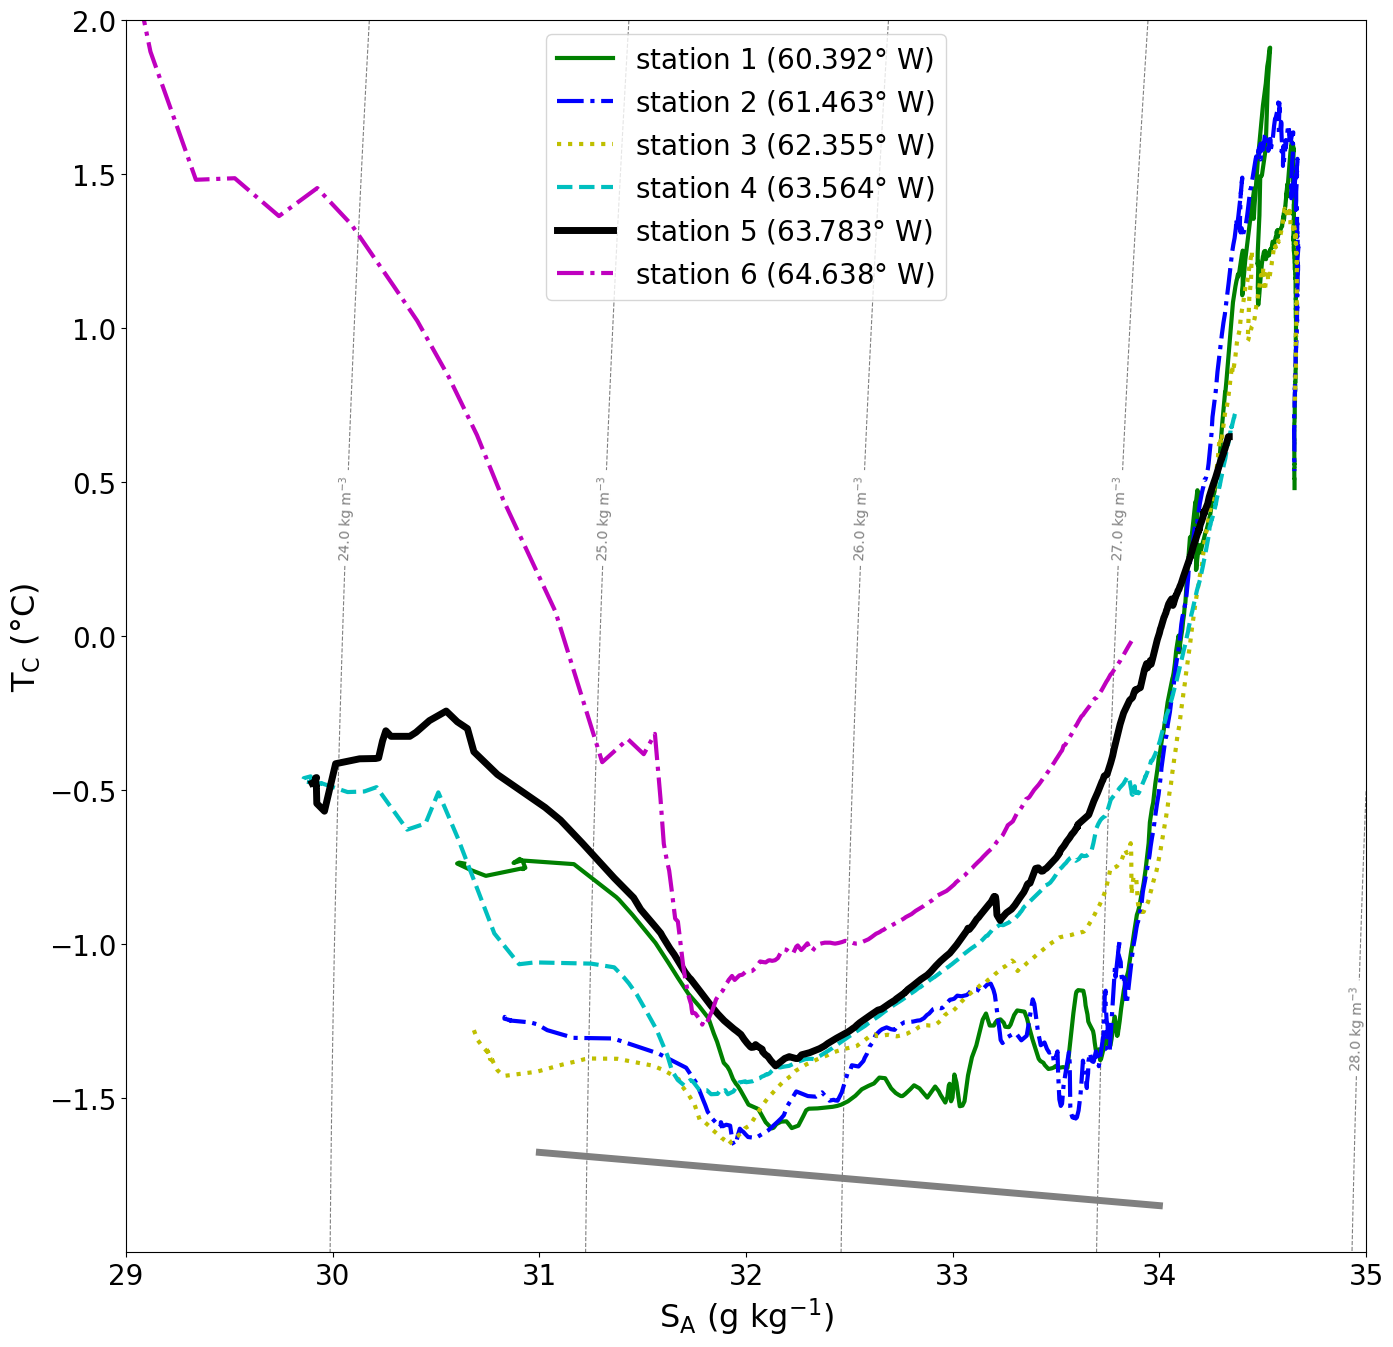

In [144]:
def make_plots(ax):
    # Colormap for depth
    colmap = mpl.cm.get_cmap("hot")
    normalization = mpl.colors.Normalize(vmin=0.0, vmax=1100.0)
    # Color each station
    cl = {"station 1": "g",
          "station 2": "b",
          "station 3": "y",
          "station 4": "c",
          "station 5": "k",
          "station 6": "m"}
    # Linestyle each station
    lstyle = {"station 1": "-",
              "station 2": "-.",
              "station 3": ":",
              "station 4": "--",
              "station 5": "-",
              "station 6": "-."}
    # Density lines
    sgrid = np.linspace(29, 35, 100)
    tgrid = np.linspace(-2, 2, 100)
    density_contour(ax, sgrid, tgrid)
    # Freeze curve
    Sf = np.linspace(31, 34, 10)
    Tf = gsw.CT_freezing(Sf, 0, 0)
    ax.plot(Sf, Tf, "-", color="gray", linewidth=5)

    # Loop
    for key in station_dic.keys():
        station_data=data.loc[station_dic[key]]
        # Longitude, latitude
        lon=station_data['Longitude [degrees_east]'].iloc[0]
        lat=station_data['Latitude [degrees_north]'].iloc[0]
        # Depth and normalization
        depth=np.array(station_data["Depth [metres]"]).astype(list)
        color_depth = [colmap(normalization(value)) for value in list(depth)]
        # Salinity, conservative temperature data
        salinity = np.array(station_data["Asal [g/kg]"]).astype(float)
        cons_temp = np.array(station_data["Cont [deg C]"]).astype(float)
        # Label
        lab = "{0} ({1:.3f}$\degree$ W)".format(key, -1*lon)
        # Plot data
        if key == "station 5":
            ax.plot(salinity, cons_temp, linewidth=5, color=cl[key], linestyle=lstyle[key], label=lab)
        else:
            ax.plot(salinity, cons_temp, linewidth=3, color=cl[key], linestyle=lstyle[key], label=lab)

    # Figure TS diagram
    ax.set_xlim(29, 35)
    ax.set_ylim(-2, 2)
    ax.set_yticks(np.arange(-1.5,2.5,0.5))
    ax.set_ylabel('$\mathrm{ T_C\ (\degree C) }$')
    ax.set_xlabel('$\mathrm{ S_A\ (g\ kg^{-1}) }$')
    ax.legend(loc="best")
    
with plt.style.context('mplstyles/ts.mplstyle'):    
    # Plot
    fig=plt.figure(figsize=(16, 16))
    ax=fig.add_subplot(111)
    make_plots(ax)

    # --- SAVE
    plt.savefig('figures_timing_sup_progress/sup_ts.'+ext,dpi=dpi)

# Plot: mean Chl $a$ and $\mathrm{ C_{phyto} }$

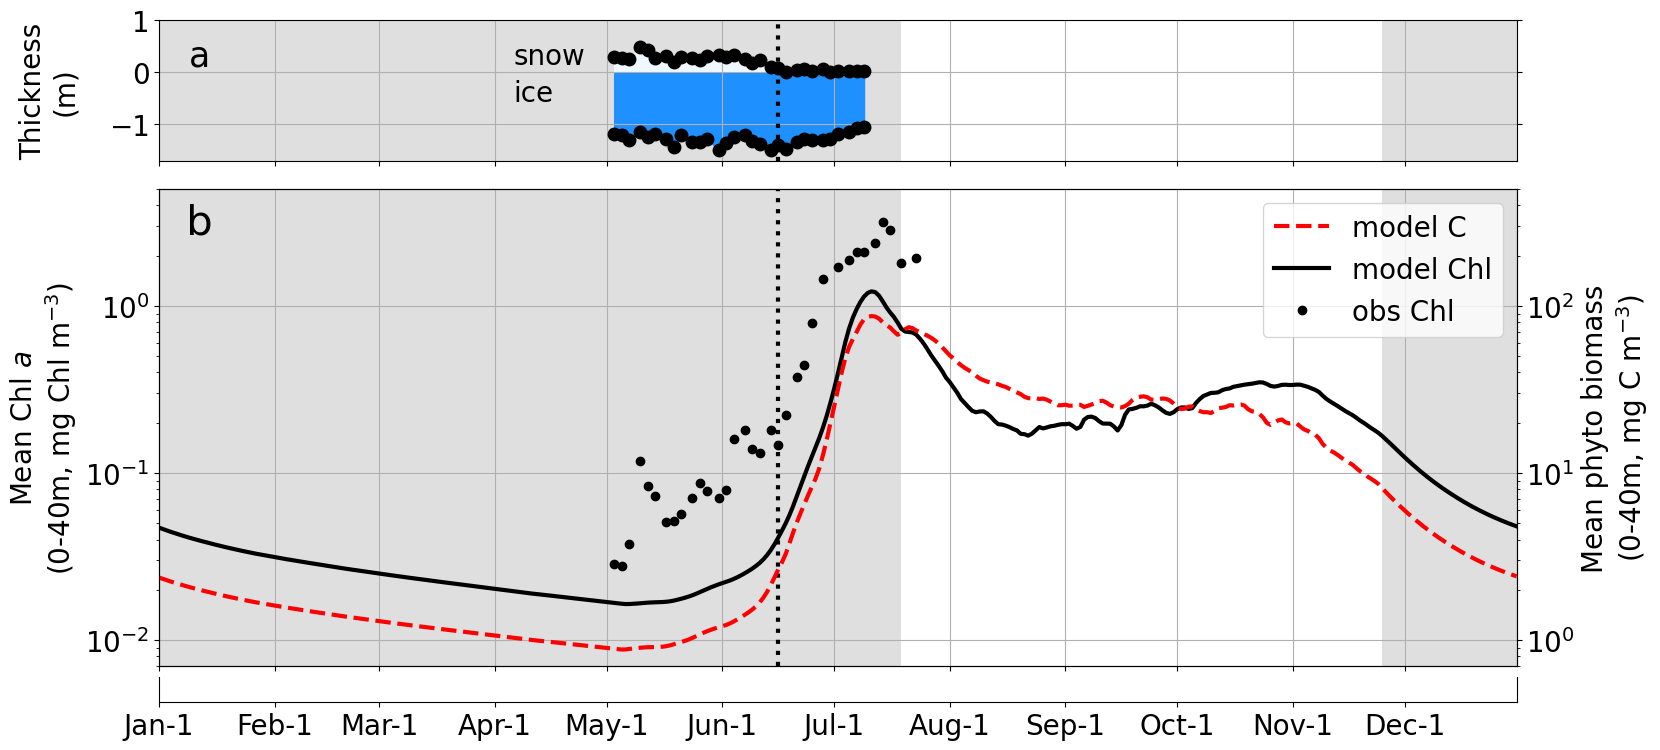

In [145]:
def make_plots(axs):
    box=dict(pad=5,alpha=0)
    locs=np.array([0, 31, 59, 90, 120, 151,
              181, 212, 243, 273, 304, 334])
    labels=('Jan-1','Feb-1','Mar-1','Apr-1','May-1','Jun-1',
            'Jul-1','Aug-1','Sep-1','Oct-1','Nov-1','Dec-1')
    xlims=(first_year[0],first_year[-1])
    xmin=xlims[0]
    xmax=xlims[1]

    # --- SNOW AND ICE THICKNESS
    ax=axs[0]
    ymin=-1.7
    ymax=1.0
    xsnow=(snow_thickness_df['doy']-1).to_numpy()
    ysnow=snow_thickness_df['sample_thickness_m_average'].to_numpy()
    h1=ax.plot(xsnow,ysnow,
               'o',color='black',label='obs')
    xsnow_to_fill=np.arange(xsnow[0],xsnow[-1]+1)
    ysnow_to_fill=np.interp(xsnow_to_fill,xsnow,ysnow)
    h2=ax.fill_between(xsnow_to_fill,ysnow_to_fill,
                       linestyle='-',color='aliceblue')
    ax.text(95,0.3,'snow',
            horizontalalignment = 'left',verticalalignment = 'center')
    xice=(ice_thickness_df['doy']-1).to_numpy()
    yice=-ice_thickness_df['sample_thickness_m_average'].to_numpy()
    h3=ax.plot(xice,yice,'o',color='black')
    xice_to_fill=np.arange(xice[0],xice[-1]+1)
    yice_to_fill=np.interp(xice_to_fill,xice,yice)
    h4=ax.fill_between(xice_to_fill,yice_to_fill,
                       linestyle='-',color='dodgerblue')
    ax.text(95,-0.40,'ice',
            horizontalalignment = 'left',verticalalignment = 'center')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylim(ymin,ymax)
    ax.yaxis.set_ticks_position('both')
    ax.set_ylabel('Thickness\n(m)',bbox=box)
    ax.grid()
#     ax.legend(loc='upper right')
    plt.text(0.03,0.75,' a ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=25)
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    ax.axvline(obs_nosnow,color='black',linestyle=':')
    
    # --- MEAN CHL A AND C_PHYTO 0-40M
    ax=axs[1]
    ymin=7E-3
    ymax=5E0
    # mg Chl m^-3
    h1=ax.plot(first_year,array1d_iT_modmeanchl,
               '-',lw=3,color='black',label='model Chl')
    h2=ax.plot(first_year,array1d_iT_obsmeanchlHPLC,
               'o',markersize=6,color='black',label='obs Chl')
    ax.set_yscale('log')
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels([])
    ax.set_ylim(ymin,ymax)
    ax.set_ylabel('Mean Chl $a$\n'
                  '(0-40m, $\mathrm{ mg\ Chl\ m^{-3} }$)')
    ax.grid()
    axt = ax.twinx()
    # mg C m^-3
    h3=axt.plot(first_year,array1d_iT_modmeancphyto,
                '--',lw=3,color='red',label='model C')
    axt.set_yscale('log')
    axt.set_ylim(*[100*l for l in ax.get_ylim()])
    axt.set_ylabel('Mean phyto biomass\n'
                  '(0-40m, $\mathrm{ mg\ C\ m^{-3} }$)')
    # ref: https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend
    # answer by Paul
#     lns=h1+h2+h3
    lns=h3+h1+h2
    labs = [l.get_label() for l in lns]
    ax.legend(lns,labs)
    plt.text(0.03,0.93,' b ',
             horizontalalignment = 'center',verticalalignment='center',
             transform=ax.transAxes, fontsize=30)
    rect=mpl.patches.Rectangle(xy=(xmin,ymin),
                               width=obs_breakup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    rect=mpl.patches.Rectangle(xy=(sim_freezeup,ymin),
                               width=364-sim_freezeup,height=ymax-ymin,
                               linewidth=0,facecolor='grey',alpha=0.25,
                               zorder=0)
    ax.add_patch(rect)
    ax.axvline(obs_nosnow,color='black',linestyle=':')
    
    # --- ADDITIONAL X-AXIS
    ax=axs[2]
    ax.set_xlim(xlims)
    ax.set_xticks(locs)
    ax.set_xticklabels(labels)
    ax.axes.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)

    # --- POSITION
    axs[0].set_position( [0.12,0.75   ,0.75,0.179])
    axs[1].set_position( [0.12,0.107  ,0.75,0.607])
    axs[2].set_position( [0.12,0.061  ,0.75,0.032])

with plt.style.context('mplstyles/Chla_C_mean40m.mplstyle'):
    # Plot
    fig,axs=plt.subplots(3,1,figsize=(18.1,7.858))
    make_plots(axs)
    fig.align_ylabels(axs[:])

    # --- SAVE
    outfile='figures_timing_sup_progress/sup_Chla_C_mean40m.'+ext
    plt.savefig(outfile,dpi=dpi)

**Figure S\<sup_Chla_C_mean40m\>.
Mean phytoplankton biomass and chlorophyll *a* (0-40m).**
**(a)** Observed snow and ice thickness.
**(b)** Mean (0-40m) Chl *a* and biomass.
Dots are *in situ* Chl *a*.
The black solid line is the model Chl *a*.
The red dashed line is the model phytoplankton biomass.
The black vertical dotted line is the date of snow melt completion.
The grey shading represents the time of year before the sea ice
break-up and after the sea ice freeze-up.